In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
#!pip3 install tensorflow
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN,LSTM,Activation,Dropout, Embedding
from keras import optimizers
from keras.metrics import MeanSquaredError
from keras.metrics import AUC

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
#!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
import lightgbm as lgb


In [2]:
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
#df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')
#df_final_train.columns
# df_final_train = read_hdf('storage_sample_stage_final.h5', 'train_df',mode='r')
# df_final_test = read_hdf('storage_sample_stage_final.h5', 'test_df',mode='r')
# df_final_train.columns
df_final_train.head()

source  destination  connected  jaccard_followers  jaccard_followees  \
0       1       690569          1                  0           0.090909   
1      18      1003537          1                  0           0.058824   
2      25       992602          1                  0           0.242424   
3      61      1408376          1                  0           0.315789   
4      62       402932          1                  0           0.000000   

   cosine_followers  cosine_followees  num_followers_s  num_followers_d  \
0          0.039817          0.251976                3               29   
1          0.092450          0.149071               13                3   
2          0.138866          0.440386               21               11   
3          0.151523          0.514496                8                7   
4          0.149071          0.000000                5                3   

   num_followees_s  ...   page_rank_s   page_rank_d    katz_s    katz_d  \
0                3  ...  2.979445e-07  3.726469e-06  0.000722  0.000819   
1               15  ...  1.111717e-06  3.046637e-07  0.000759  0.000721   
2               30  ...  1.249942e-06  6.286333e-07  0.000790  0.000753   
3               17  ...  6.565506e-07  4.826817e-07  0.000740  0.000736   
4                3  ...  4.097580e-07  8.216330e-07  0.000729  0.000721   

         hubs_s        hubs_d  authorities_s  authorities_d  \
0  8.549207e-18  1.690629e-16   3.812413e-18   3.942273e-16   
1  1.583866e-17  9.329002e-20   6.343111e-18   1.297053e-19   
2  1.054783e-13  6.601673e-14   6.990593e-15   3.079403e-15   
3  2.768741e-19  2.050358e-19   6.563911e-21   6.826043e-21   
4  3.984634e-18 -0.000000e+00   1.731093e-16   2.732624e-19   

   prefer_Attach_followers  prefer_Attach_followees  
0                       87                       63  
1                       39                       45  
2                      231                      330  
3                       56                      136  
4                       15                        0  

[5 rows x 33 columns]

In [3]:
y_train = df_final_train.connected

In [4]:
df_final_train.drop(['source', 'destination','connected'],axis=1,inplace=True)

## Neural Network

In [5]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [76]:
%%time

hidden_units=150
learning_rate=0.01
hidden_layer_act='relu'
output_layer_act='sigmoid'
no_epochs=40

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
scorers = ['f1_score']
from IPython.display import display



        


feature_names = list(df_final_train.columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)

count = 1
# test data is not needed for fitting
for train_ix, test_ix in kf.split(df_final_train, y_train):
    
    X_train, X_test = df_final_train.iloc[train_ix, :], df_final_train.iloc[test_ix, :]
    y_train_lgb, y_test_lgb = y_train.iloc[train_ix], y_train.iloc[test_ix]

    
    model = Sequential()

    model.add(Dense(hidden_units, activation=hidden_layer_act))
    model.add(Dense(hidden_units, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(1, activation=output_layer_act))

    sgd=optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
    model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=[f1_m,recall_m])
    
    history=model.fit(X_train, y_train_lgb, epochs=no_epochs, batch_size=50,  verbose=2)
    
    y_pred = model.predict(X_test)

    rounded = [int(round(x[0])) for x in y_pred]
    print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_lgb, rounded)))
    print('LightGBM Model f1 score: {0:0.4f}'.format(f1_score(y_test_lgb, rounded)))
    print('LightGBM Model recall score: {0:0.4f}'.format(recall_score(y_test_lgb, rounded)))



model.save("nn_model")
perm = PermutationImportance(model, random_state=0,scoring='neg_mean_squared_error').fit(X_train,y_train_lgb,epochs=no_epochs)
display(eli5.show_weights(perm, feature_names = X_train.columns.tolist()))

predictions = model.predict(X_test)

rounded = [int(round(x[0])) for x in predictions]



Epoch 1/40
1600/1600 - 3s - loss: 0.3412 - f1_m: 0.9030 - recall_m: 0.9009 - 3s/epoch - 2ms/step
Epoch 2/40
1600/1600 - 3s - loss: 0.1156 - f1_m: 0.9589 - recall_m: 0.9559 - 3s/epoch - 2ms/step
Epoch 3/40
1600/1600 - 3s - loss: 0.1086 - f1_m: 0.9629 - recall_m: 0.9575 - 3s/epoch - 2ms/step
Epoch 4/40
1600/1600 - 2s - loss: 0.0850 - f1_m: 0.9689 - recall_m: 0.9638 - 2s/epoch - 2ms/step
Epoch 5/40
1600/1600 - 2s - loss: 0.0745 - f1_m: 0.9720 - recall_m: 0.9664 - 2s/epoch - 2ms/step
Epoch 6/40
1600/1600 - 3s - loss: 0.0770 - f1_m: 0.9720 - recall_m: 0.9666 - 3s/epoch - 2ms/step
Epoch 7/40
1600/1600 - 2s - loss: 0.0718 - f1_m: 0.9738 - recall_m: 0.9668 - 2s/epoch - 1ms/step
Epoch 8/40
1600/1600 - 2s - loss: 0.0651 - f1_m: 0.9757 - recall_m: 0.9692 - 2s/epoch - 1ms/step
Epoch 9/40
1600/1600 - 2s - loss: 0.0630 - f1_m: 0.9759 - recall_m: 0.9690 - 2s/epoch - 1ms/step
Epoch 10/40
1600/1600 - 2s - loss: 0.0710 - f1_m: 0.9740 - recall_m: 0.9683 - 2s/epoch - 1ms/step
Epoch 11/40
1600/1600 - 2s - 

Epoch 2/40
1601/1601 - 2s - loss: 0.1509 - f1_m: 0.9571 - recall_m: 0.9532 - 2s/epoch - 1ms/step
Epoch 3/40
1601/1601 - 2s - loss: 0.1028 - f1_m: 0.9659 - recall_m: 0.9584 - 2s/epoch - 1ms/step
Epoch 4/40
1601/1601 - 2s - loss: 0.0758 - f1_m: 0.9721 - recall_m: 0.9655 - 2s/epoch - 1ms/step
Epoch 5/40
1601/1601 - 2s - loss: 0.0752 - f1_m: 0.9716 - recall_m: 0.9661 - 2s/epoch - 1ms/step
Epoch 6/40
1601/1601 - 2s - loss: 0.0676 - f1_m: 0.9745 - recall_m: 0.9675 - 2s/epoch - 1ms/step
Epoch 7/40
1601/1601 - 2s - loss: 0.0658 - f1_m: 0.9747 - recall_m: 0.9675 - 2s/epoch - 1ms/step
Epoch 8/40
1601/1601 - 2s - loss: 0.0651 - f1_m: 0.9752 - recall_m: 0.9689 - 2s/epoch - 1ms/step
Epoch 9/40
1601/1601 - 2s - loss: 0.0747 - f1_m: 0.9718 - recall_m: 0.9658 - 2s/epoch - 1ms/step
Epoch 10/40
1601/1601 - 2s - loss: 0.0623 - f1_m: 0.9768 - recall_m: 0.9700 - 2s/epoch - 1ms/step
Epoch 11/40
1601/1601 - 2s - loss: 0.0597 - f1_m: 0.9766 - recall_m: 0.9694 - 2s/epoch - 1ms/step
Epoch 12/40
1601/1601 - 2s -

Epoch 3/40
1601/1601 - 2s - loss: 0.0989 - f1_m: 0.9642 - recall_m: 0.9591 - 2s/epoch - 1ms/step
Epoch 4/40
1601/1601 - 2s - loss: 0.0845 - f1_m: 0.9685 - recall_m: 0.9625 - 2s/epoch - 1ms/step
Epoch 5/40
1601/1601 - 2s - loss: 0.0849 - f1_m: 0.9681 - recall_m: 0.9613 - 2s/epoch - 1ms/step
Epoch 6/40
1601/1601 - 2s - loss: 0.0717 - f1_m: 0.9720 - recall_m: 0.9645 - 2s/epoch - 1ms/step
Epoch 7/40
1601/1601 - 2s - loss: 0.0704 - f1_m: 0.9730 - recall_m: 0.9665 - 2s/epoch - 1ms/step
Epoch 8/40
1601/1601 - 2s - loss: 0.0800 - f1_m: 0.9729 - recall_m: 0.9663 - 2s/epoch - 1ms/step
Epoch 9/40
1601/1601 - 2s - loss: 0.0661 - f1_m: 0.9756 - recall_m: 0.9689 - 2s/epoch - 1ms/step
Epoch 10/40
1601/1601 - 2s - loss: 0.0611 - f1_m: 0.9760 - recall_m: 0.9690 - 2s/epoch - 1ms/step
Epoch 11/40
1601/1601 - 2s - loss: 0.0636 - f1_m: 0.9764 - recall_m: 0.9693 - 2s/epoch - 1ms/step
Epoch 12/40
1601/1601 - 2s - loss: 0.0591 - f1_m: 0.9772 - recall_m: 0.9702 - 2s/epoch - 1ms/step
Epoch 13/40
1601/1601 - 2s 

625/625 [==============================] - 1s 1ms/step
Wall time: 15min 35s


In [77]:
# f1_m(y_test_split, rounded)
# recall_m(y_test_split, rounded)
print(f1_score(y_test_lgb, rounded, average="binary"))
recall_score(y_test_lgb, rounded, average="binary")

0.9817836052447202


0.9770893515290368

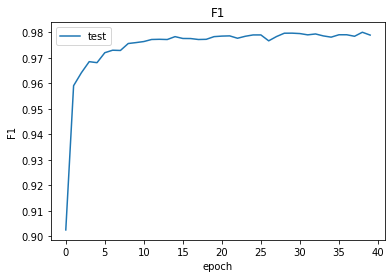

In [78]:
plt.plot(history.history['f1_m'])
#plt.plot(history.history['val_acc'])
plt.title('F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

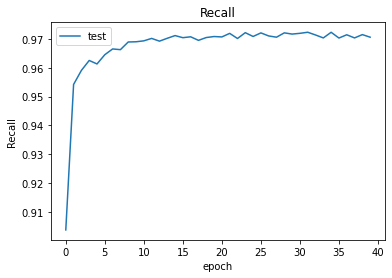

In [79]:
plt.plot(history.history['recall_m'])
#plt.plot(history.history['val_acc'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

In [18]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(3,130),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf1 = RandomForestClassifier(random_state=25,n_jobs=-1)

# clf2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
#               gamma=0, gpu_id=-1, importance_type=None,
#               interaction_constraints='', learning_rate=0.300000012,
#               max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
#               monotone_constraints='()', n_estimators=109, n_jobs=4,
#               num_parallel_tree=1, predictor='auto', random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
#               tree_method='exact', validate_parameters=1, verbosity=None)


param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__criterion'] = ["gini", "entropy"]
param1['classifier__max_depth'] = [40,80]
param1['classifier__min_samples_split'] = [130]
param1['classifier__min_samples_leaf'] = [40]
param1['classifier'] = [clf1]

# param2 = {}
# param2['classifier'] = [clf2]



pipeline = Pipeline([('classifier', clf1)])
params = [param1, ]#param2]



rf_random = RandomizedSearchCV(pipeline, param_distributions=params,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')
                                   #n_iter=5,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')

rf_random.fit(df_final_train,y_train)
print('mean test f1',rf_random.cv_results_['mean_test_f1'])
print('mean train f1',rf_random.cv_results_['mean_train_f1'])

mean test f1 [0.9756988  0.97467033 0.97330902 0.97498916 0.97581124 0.9756988
 0.97440578 0.97440578 0.97581124 0.97467033]
mean train f1 [0.97651689 0.97537326 0.97404323 0.97577185 0.97660919 0.97651689
 0.97514738 0.97514738 0.97660919 0.97537326]


In [19]:
rf_random.cv_results_

{'mean_fit_time': array([2.14369082, 0.58040395, 0.53517156, 8.78467302, 8.23942938,
        1.80195303, 1.87167773, 1.80342393, 8.16780248, 0.58548231]),
 'std_fit_time': array([0.98996841, 0.0755976 , 0.08515737, 0.93642295, 0.66075291,
        0.23407591, 0.20138568, 0.1751734 , 0.18559312, 0.06309735]),
 'mean_score_time': array([0.11490645, 0.07288632, 0.07492323, 0.3743319 , 0.35044665,
        0.11713076, 0.12429128, 0.12209325, 0.35146227, 0.07373285]),
 'std_score_time': array([0.01920244, 0.00880425, 0.00625443, 0.0560359 , 0.0590784 ,
        0.02314672, 0.00074993, 0.02057501, 0.04885848, 0.00995147]),
 'param_classifier__n_estimators': masked_array(data=[50, 10, 10, 250, 250, 50, 50, 50, 250, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__min_samples_split': masked_array(data=[130, 130, 130, 130, 130, 130, 130, 130, 130, 130],
       

In [20]:
print(rf_random.best_estimator_)
rf_random.best_params_

Pipeline(steps=[('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=40,
                                        min_samples_leaf=40,
                                        min_samples_split=130, n_estimators=250,
                                        n_jobs=-1, random_state=25))])


{'classifier__n_estimators': 250,
 'classifier__min_samples_split': 130,
 'classifier__min_samples_leaf': 40,
 'classifier__max_depth': 40,
 'classifier__criterion': 'entropy',
 'classifier': RandomForestClassifier(criterion='entropy', max_depth=40, min_samples_leaf=40,
                        min_samples_split=130, n_estimators=250, n_jobs=-1,
                        random_state=25)}

In [21]:
pd.DataFrame(rf_random.cv_results_)['params']

0    {'classifier__n_estimators': 50, 'classifier__...
1    {'classifier__n_estimators': 10, 'classifier__...
2    {'classifier__n_estimators': 10, 'classifier__...
3    {'classifier__n_estimators': 250, 'classifier_...
4    {'classifier__n_estimators': 250, 'classifier_...
5    {'classifier__n_estimators': 50, 'classifier__...
6    {'classifier__n_estimators': 50, 'classifier__...
7    {'classifier__n_estimators': 50, 'classifier__...
8    {'classifier__n_estimators': 250, 'classifier_...
9    {'classifier__n_estimators': 10, 'classifier__...
Name: params, dtype: object

In [22]:
rf_pd=pd.DataFrame(rf_random.cv_results_)
rf_pd = rf_pd.set_index(rf_pd["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
list(rf_pd.params)

[{'classifier__n_estimators': 50,
  'classifier__min_samples_split': 130,
  'classifier__min_samples_leaf': 40,
  'classifier__max_depth': 80,
  'classifier__criterion': 'entropy',
  'classifier': RandomForestClassifier(criterion='entropy', max_depth=40, min_samples_leaf=40,
                         min_samples_split=130, n_estimators=250, n_jobs=-1,
                         random_state=25)},
 {'classifier__n_estimators': 10,
  'classifier__min_samples_split': 130,
  'classifier__min_samples_leaf': 40,
  'classifier__max_depth': 80,
  'classifier__criterion': 'entropy',
  'classifier': RandomForestClassifier(criterion='entropy', max_depth=40, min_samples_leaf=40,
                         min_samples_split=130, n_estimators=250, n_jobs=-1,
                         random_state=25)},
 {'classifier__n_estimators': 10,
  'classifier__min_samples_split': 130,
  'classifier__min_samples_leaf': 40,
  'classifier__max_depth': 40,
  'classifier__criterion': 'gini',
  'classifier': RandomForest

In [23]:
rf_pd[["params"]]

params
params                                                                                               
50_130_40_80_entropy_RandomForestClassifier(cri...  {'classifier__n_estimators': 50, 'classifier__...
10_130_40_80_entropy_RandomForestClassifier(cri...  {'classifier__n_estimators': 10, 'classifier__...
10_130_40_40_gini_RandomForestClassifier(criter...  {'classifier__n_estimators': 10, 'classifier__...
250_130_40_40_gini_RandomForestClassifier(crite...  {'classifier__n_estimators': 250, 'classifier_...
250_130_40_40_entropy_RandomForestClassifier(cr...  {'classifier__n_estimators': 250, 'classifier_...
50_130_40_40_entropy_RandomForestClassifier(cri...  {'classifier__n_estimators': 50, 'classifier__...
50_130_40_80_gini_RandomForestClassifier(criter...  {'classifier__n_estimators': 50, 'classifier__...
50_130_40_40_gini_RandomForestClassifier(criter...  {'classifier__n_estimators': 50, 'classifier__...
250_130_40_80_entropy_RandomForestClassifier(cr...  {'classifier__n_estimators': 250, 'classifier_...
10_130_40_40_entropy_RandomForestClassifier(cri...  {'classifier__n_estimators': 10, 'classifier__...

In [24]:
names=rf_pd.params

## Barplot for each model in every slit for recall

The score for the first split with each parameter


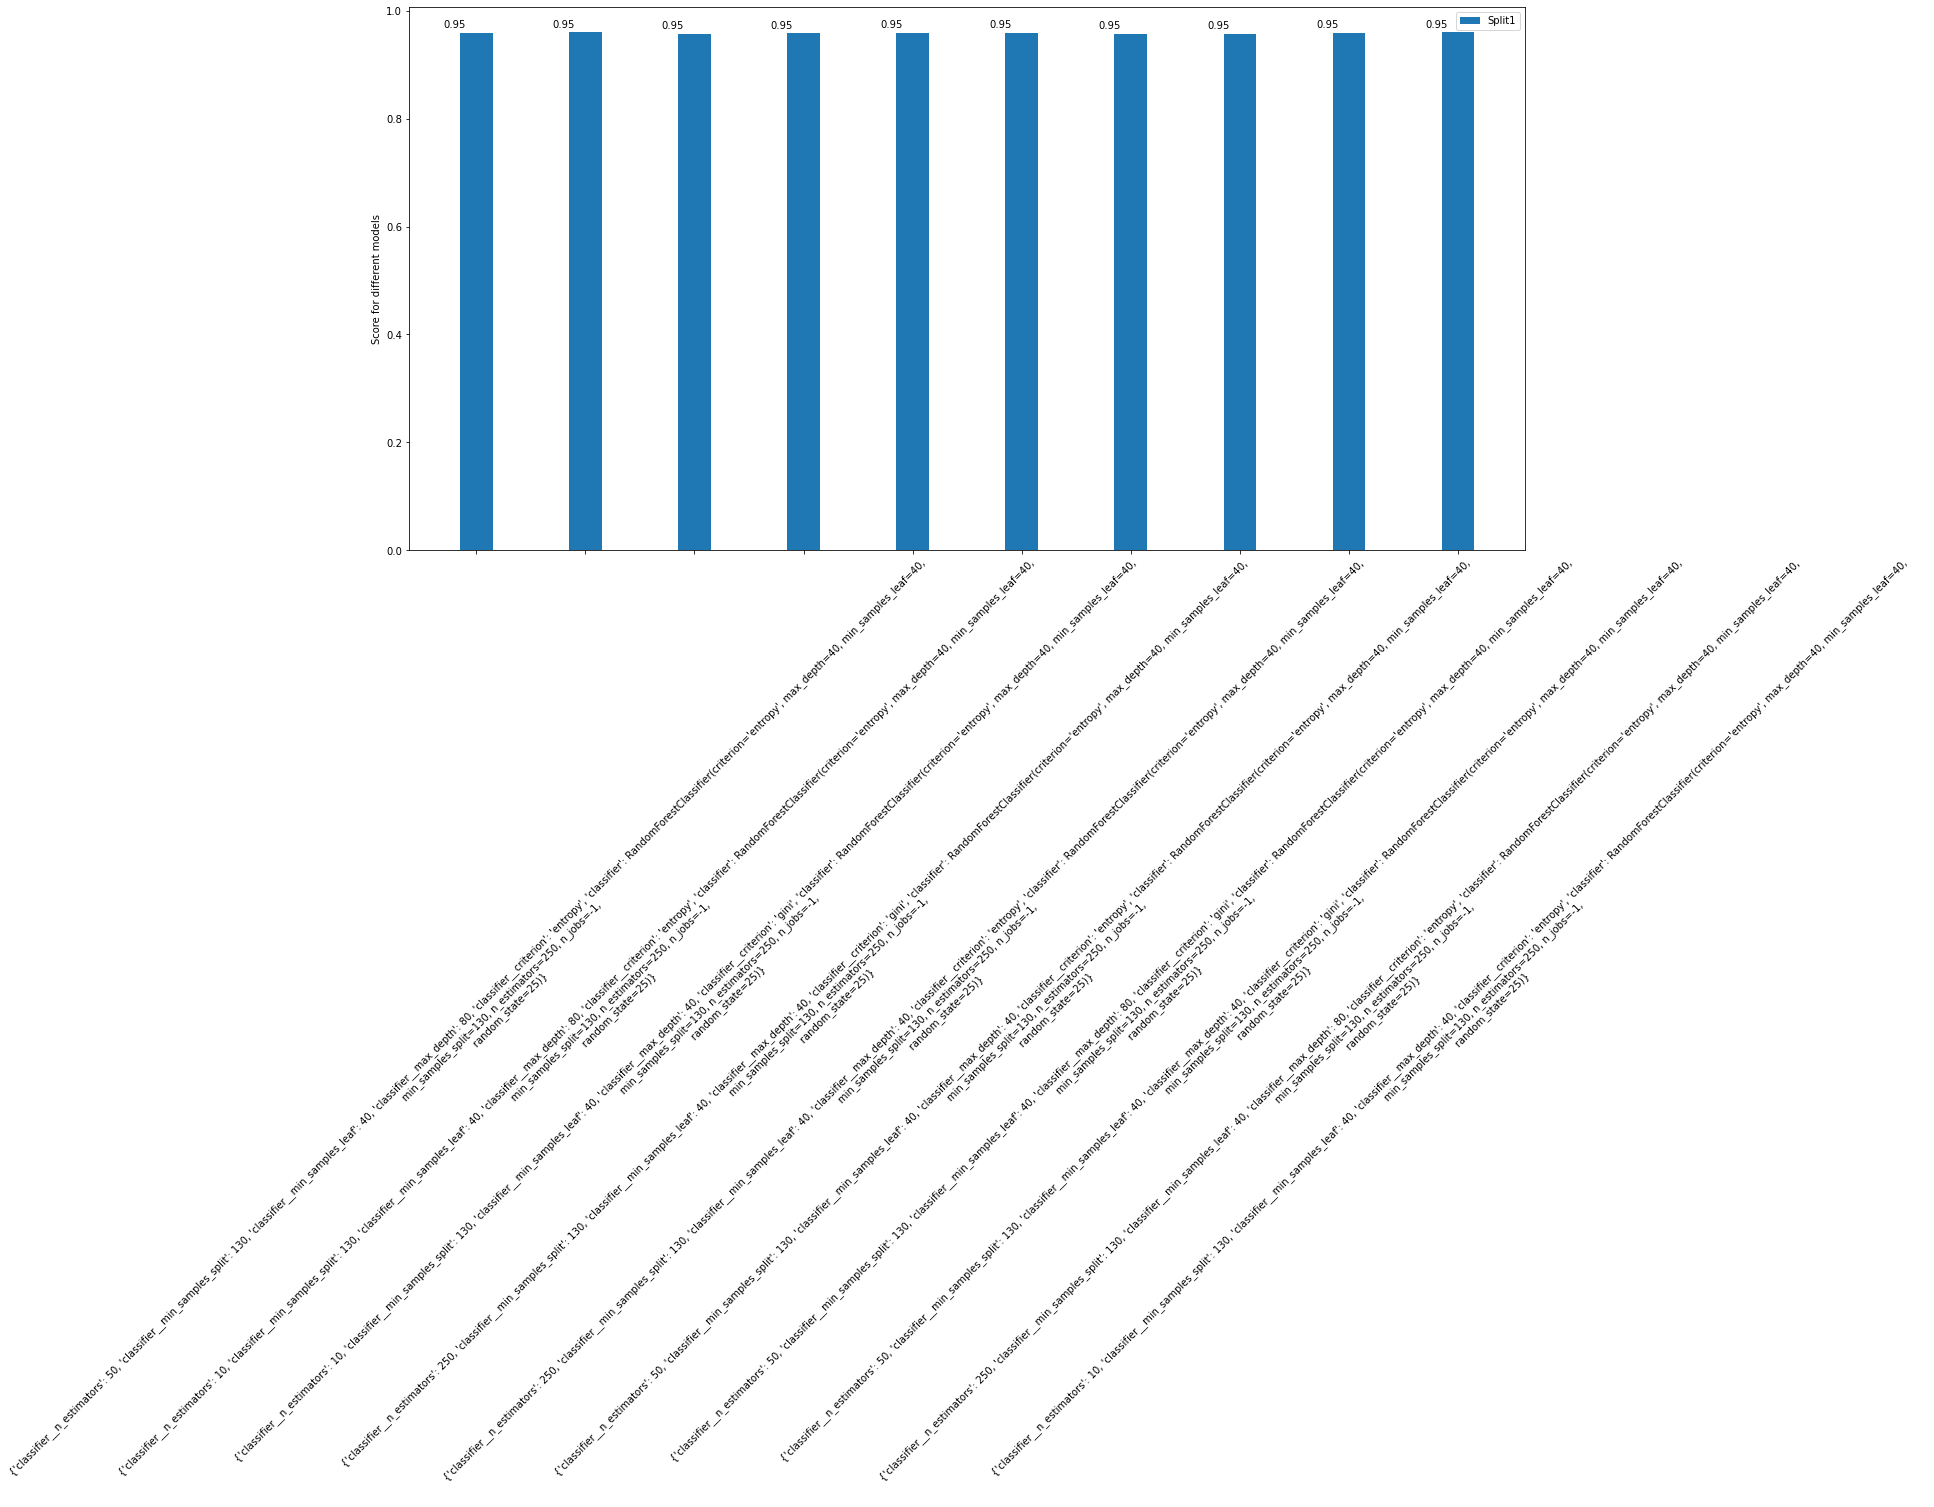

The score for the second split with each parameter


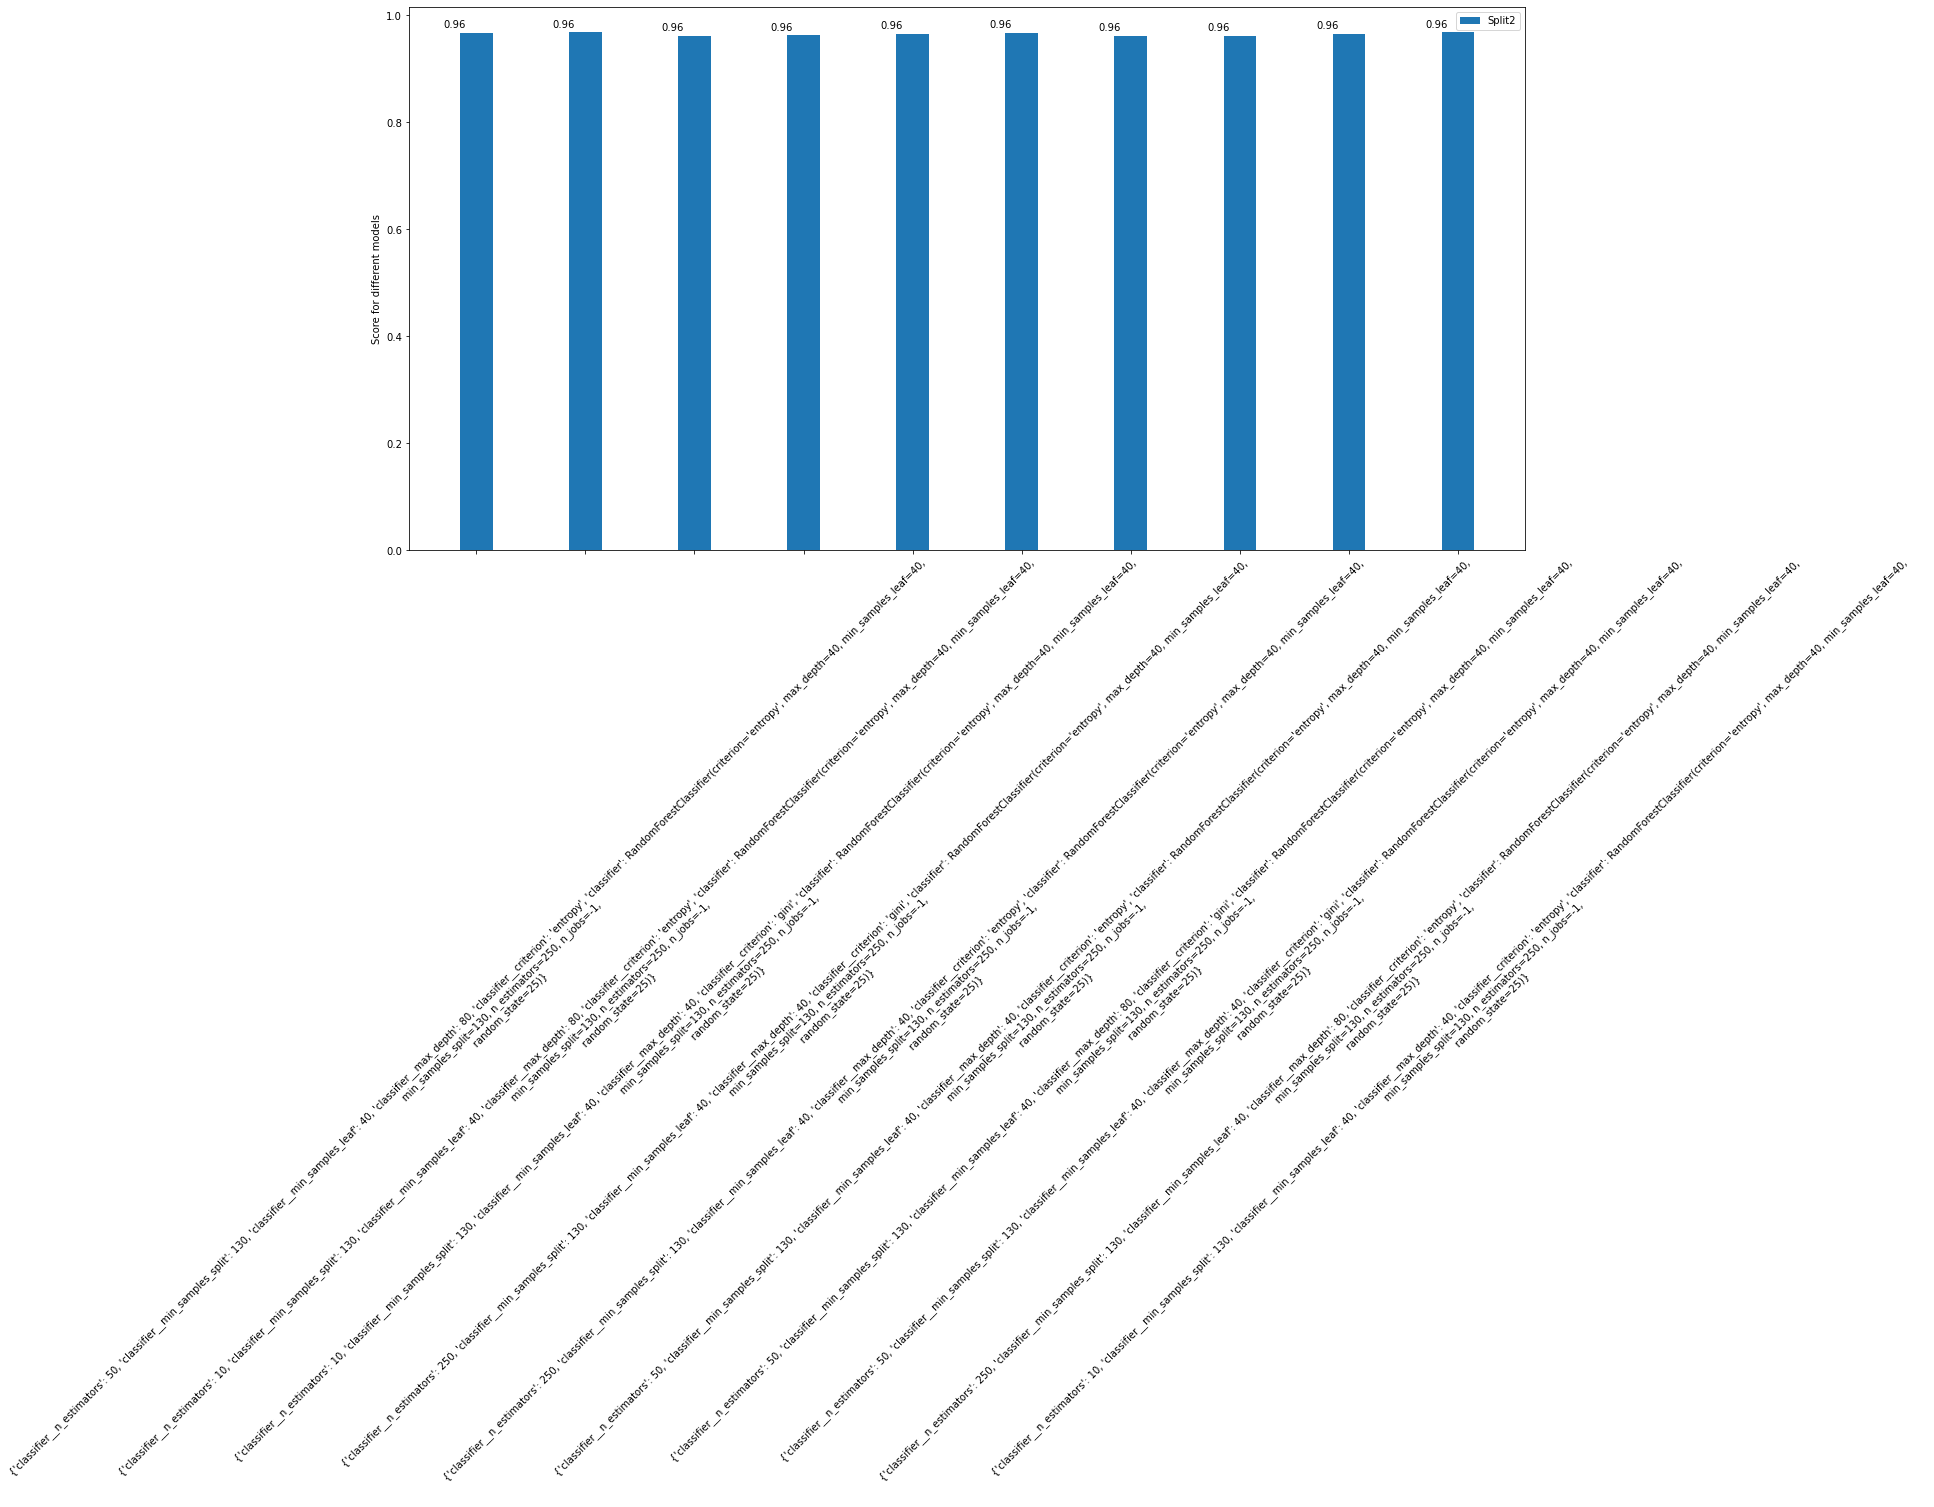

The score for the third split with each parameter


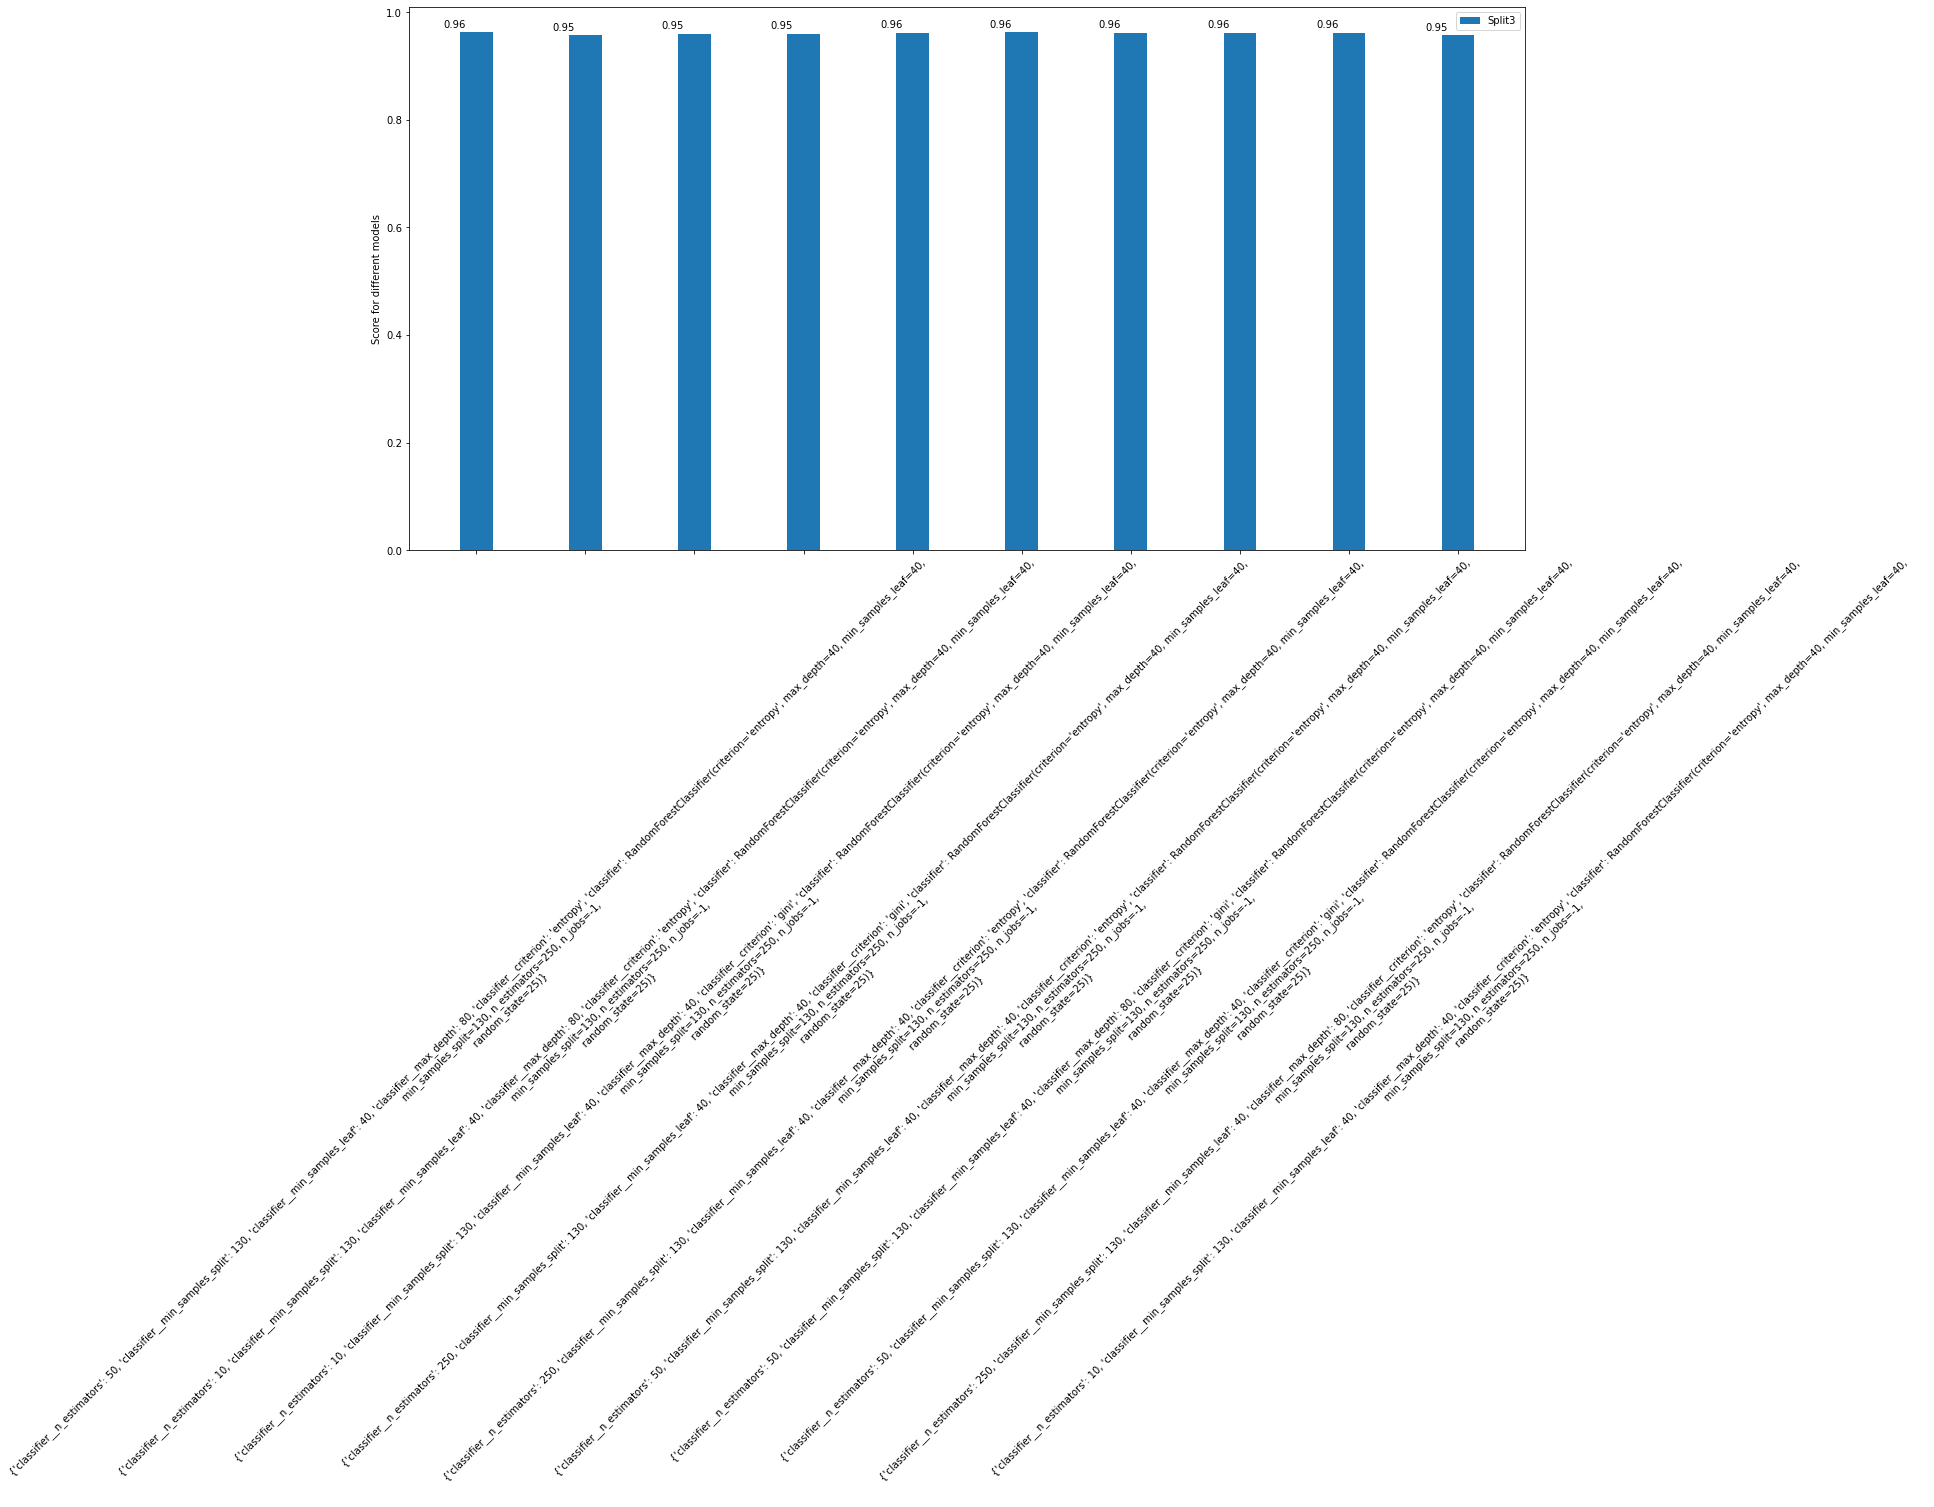

The score for the fouth split with each parameter


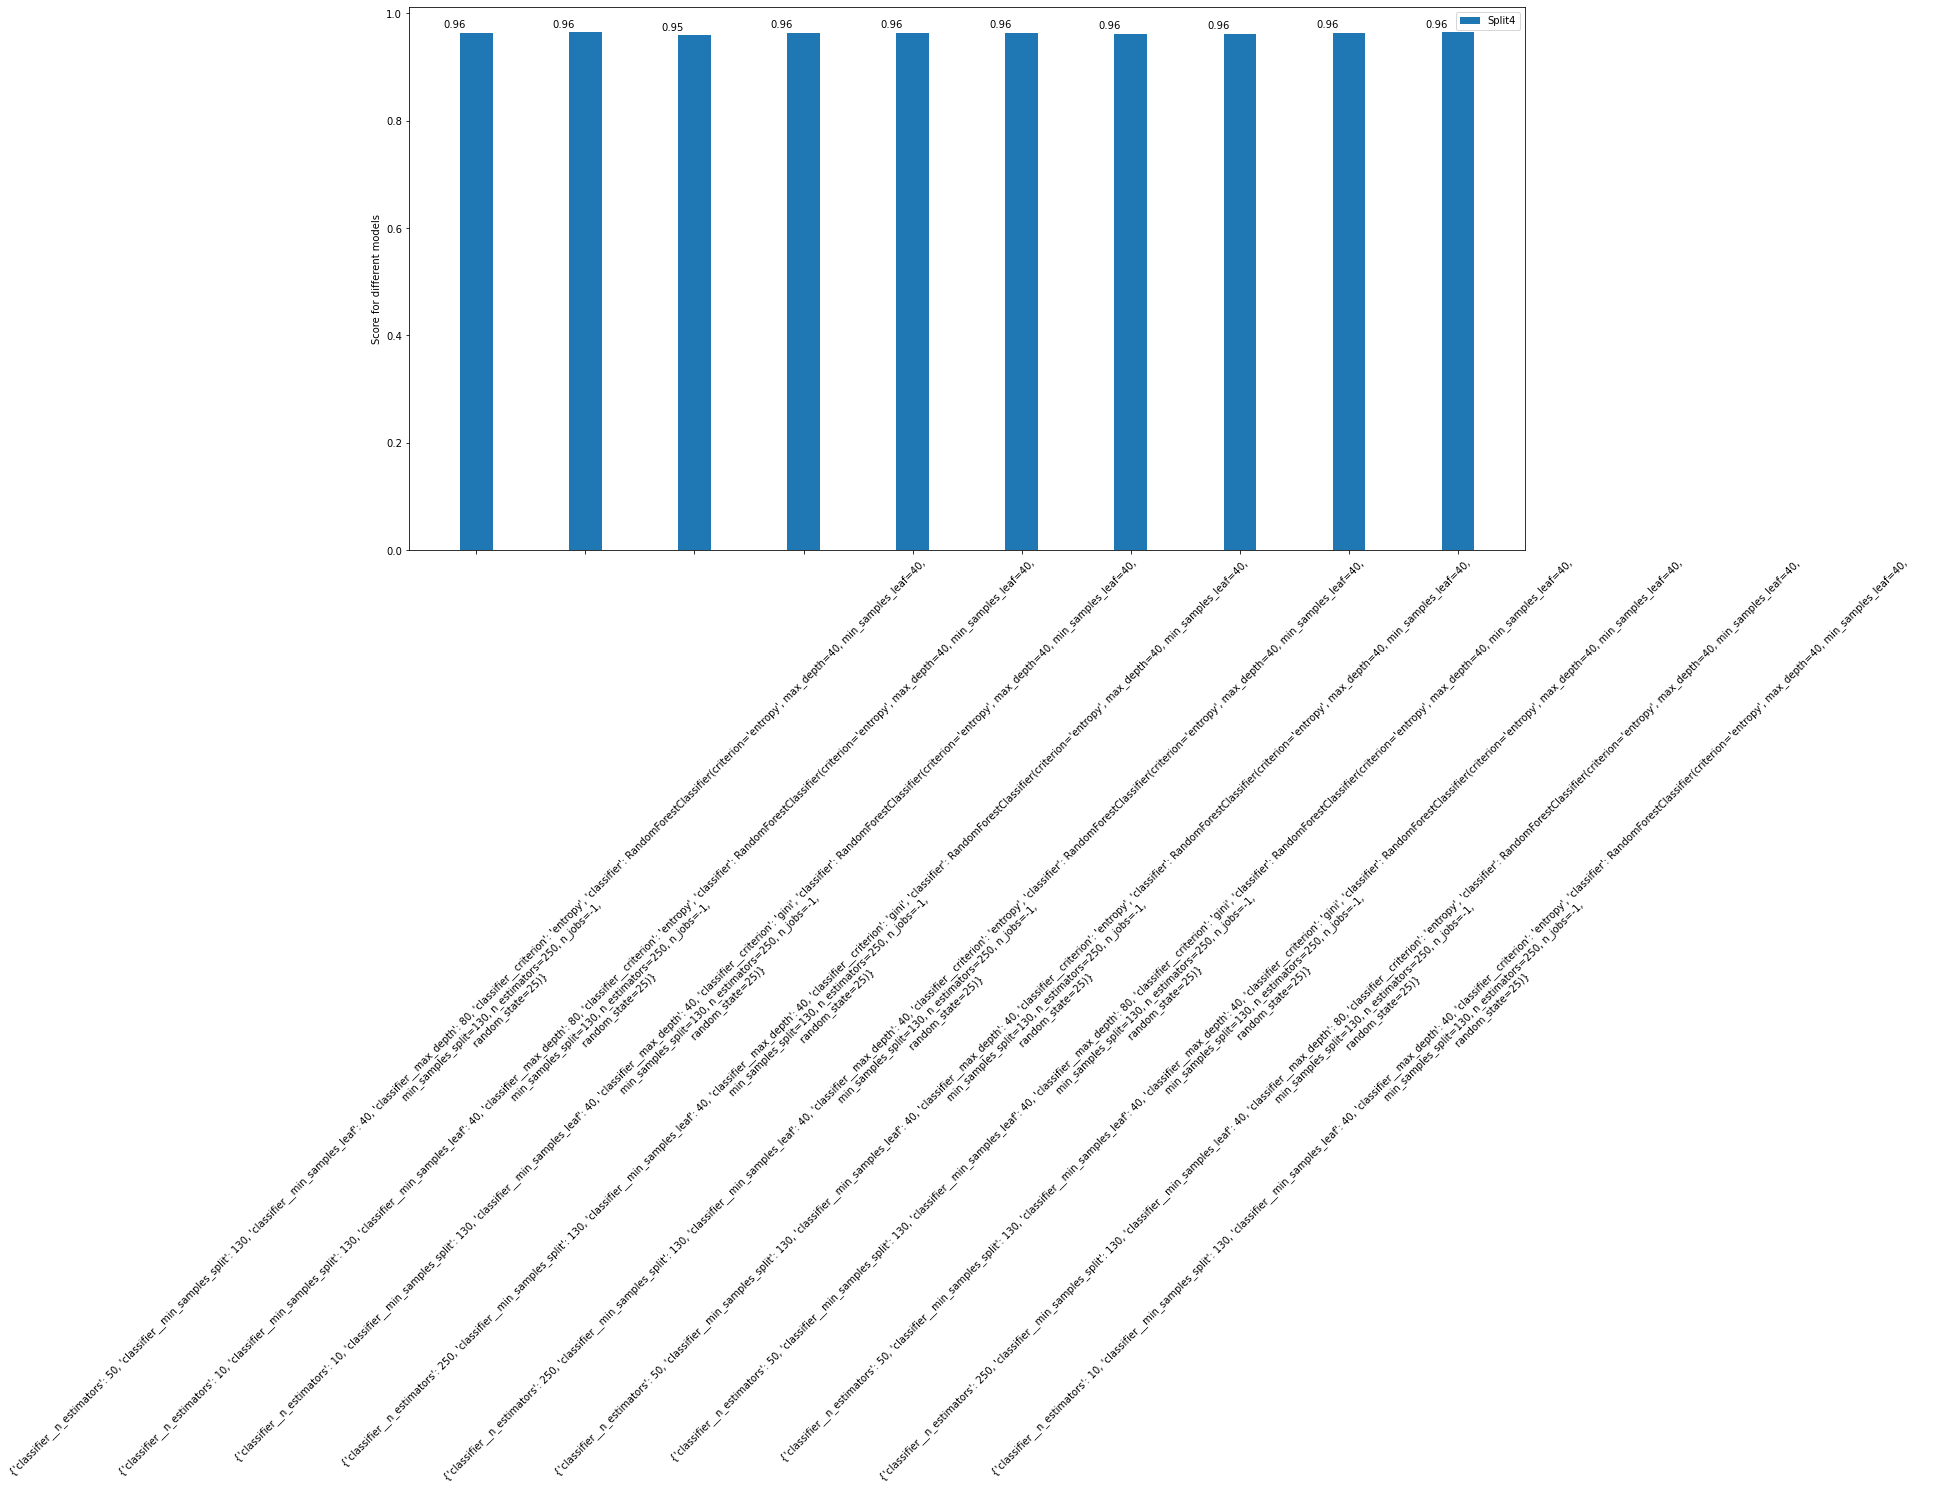

The score for the fifth split with each parameter


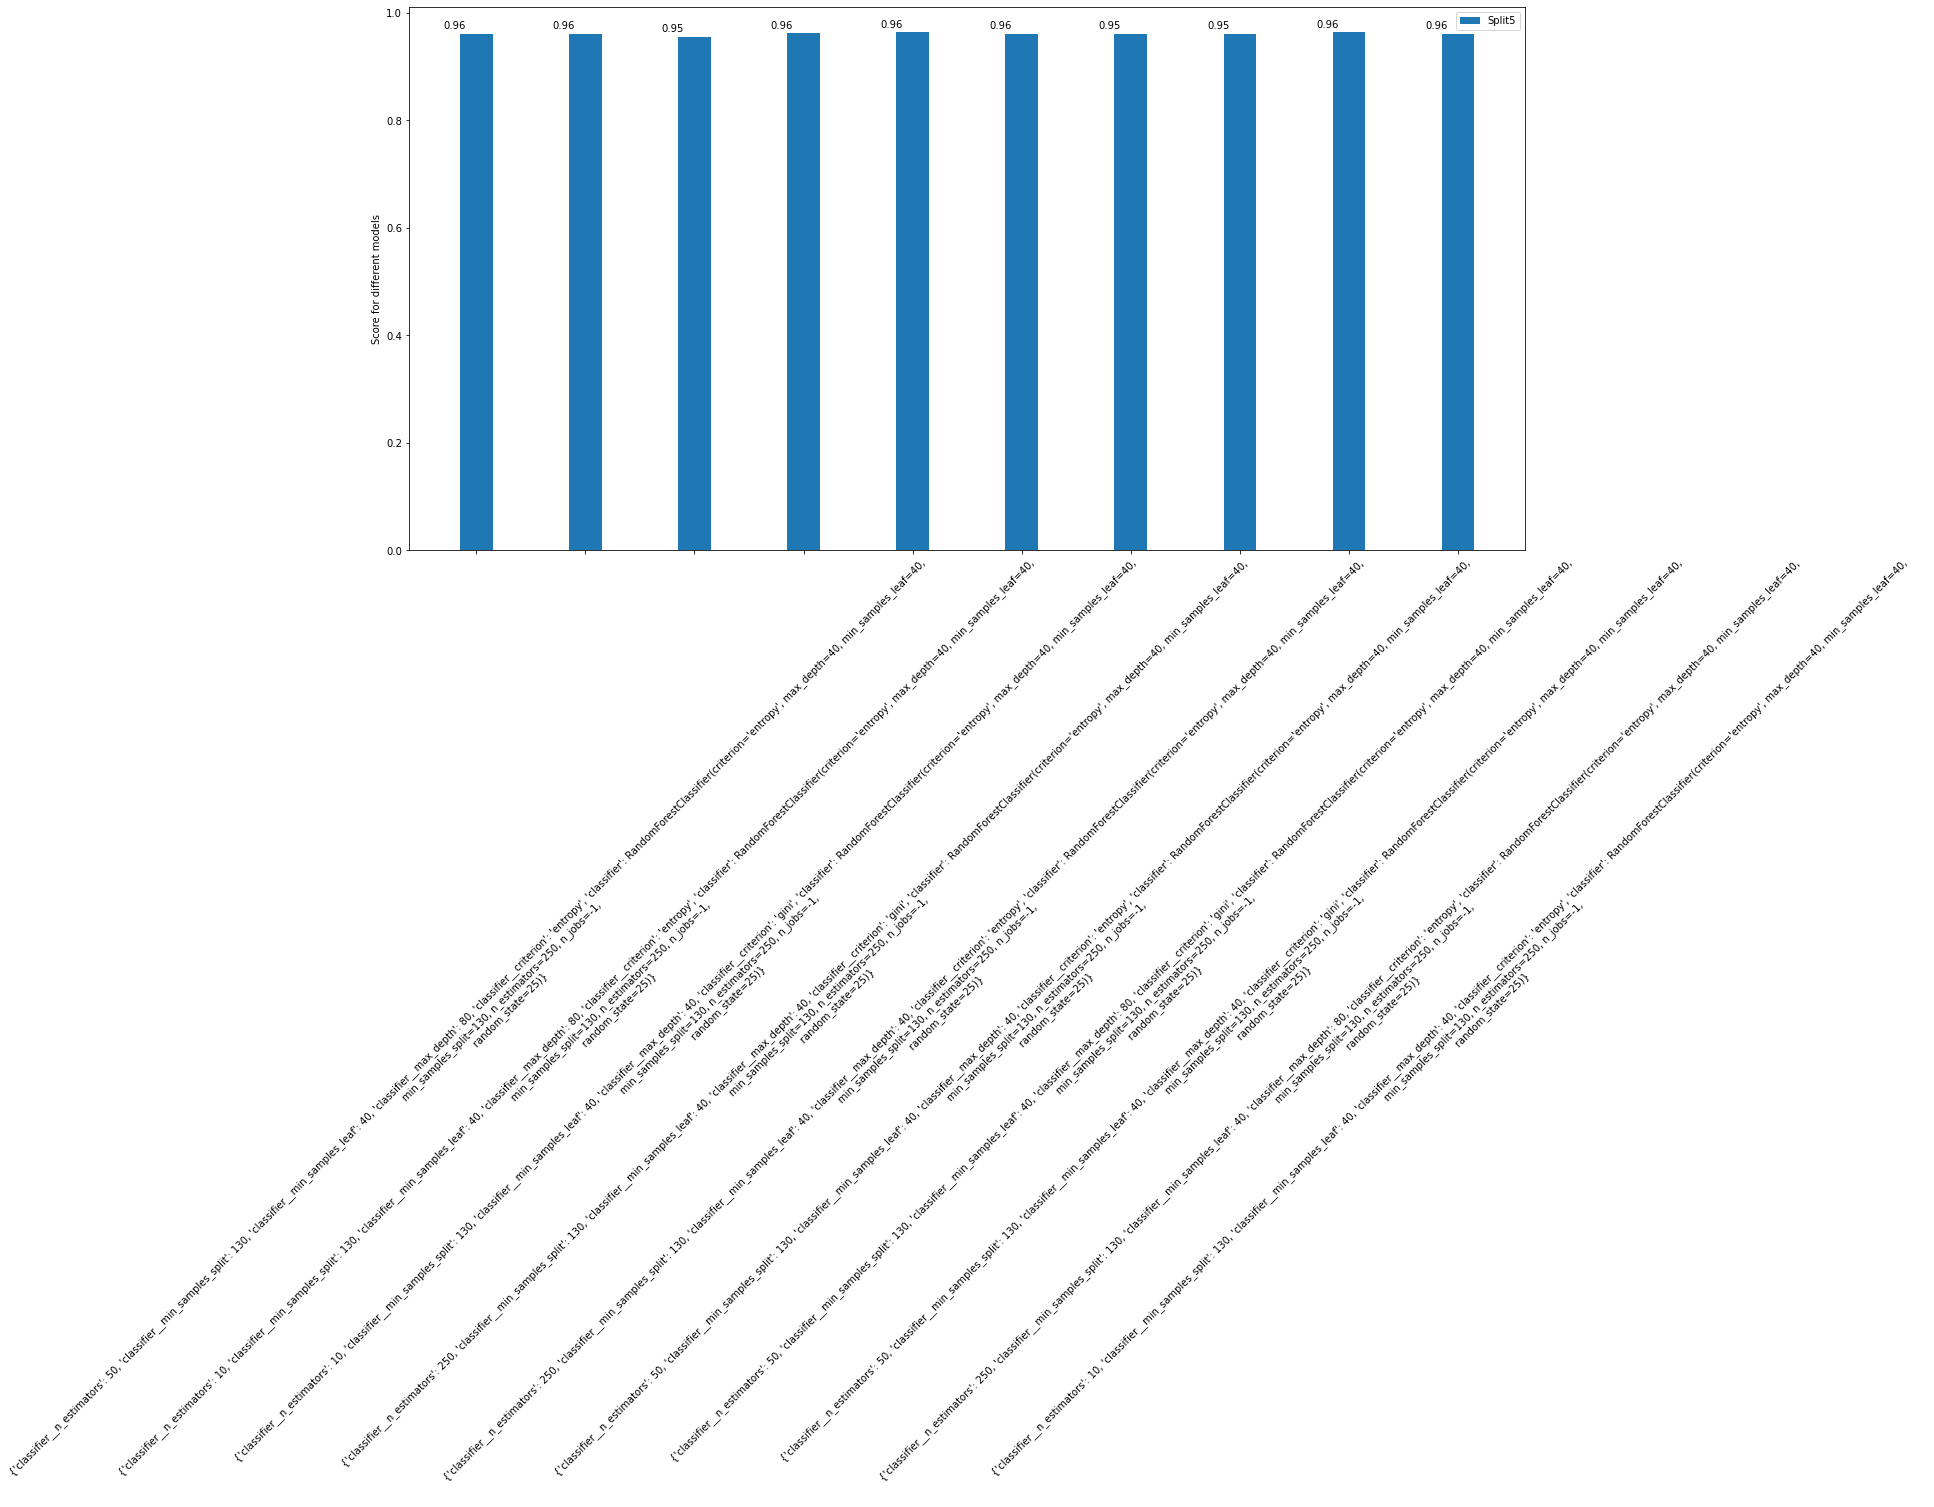

In [25]:
x = np.arange(len(pd.DataFrame(rf_random.cv_results_)["split0_test_recall"]))

print("The score for the first split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split0_test_recall"], width, label='Split1')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split0_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the second split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split1_test_recall"], width, label='Split2')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split1_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the third split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split2_test_recall"], width, label='Split3')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split2_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the fouth split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split3_test_recall"], width, label='Split4')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split3_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the fifth split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split4_test_recall"], width, label='Split5')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split4_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()


## Barplot for each model in every slit for f1

The score for the first split with each parameter


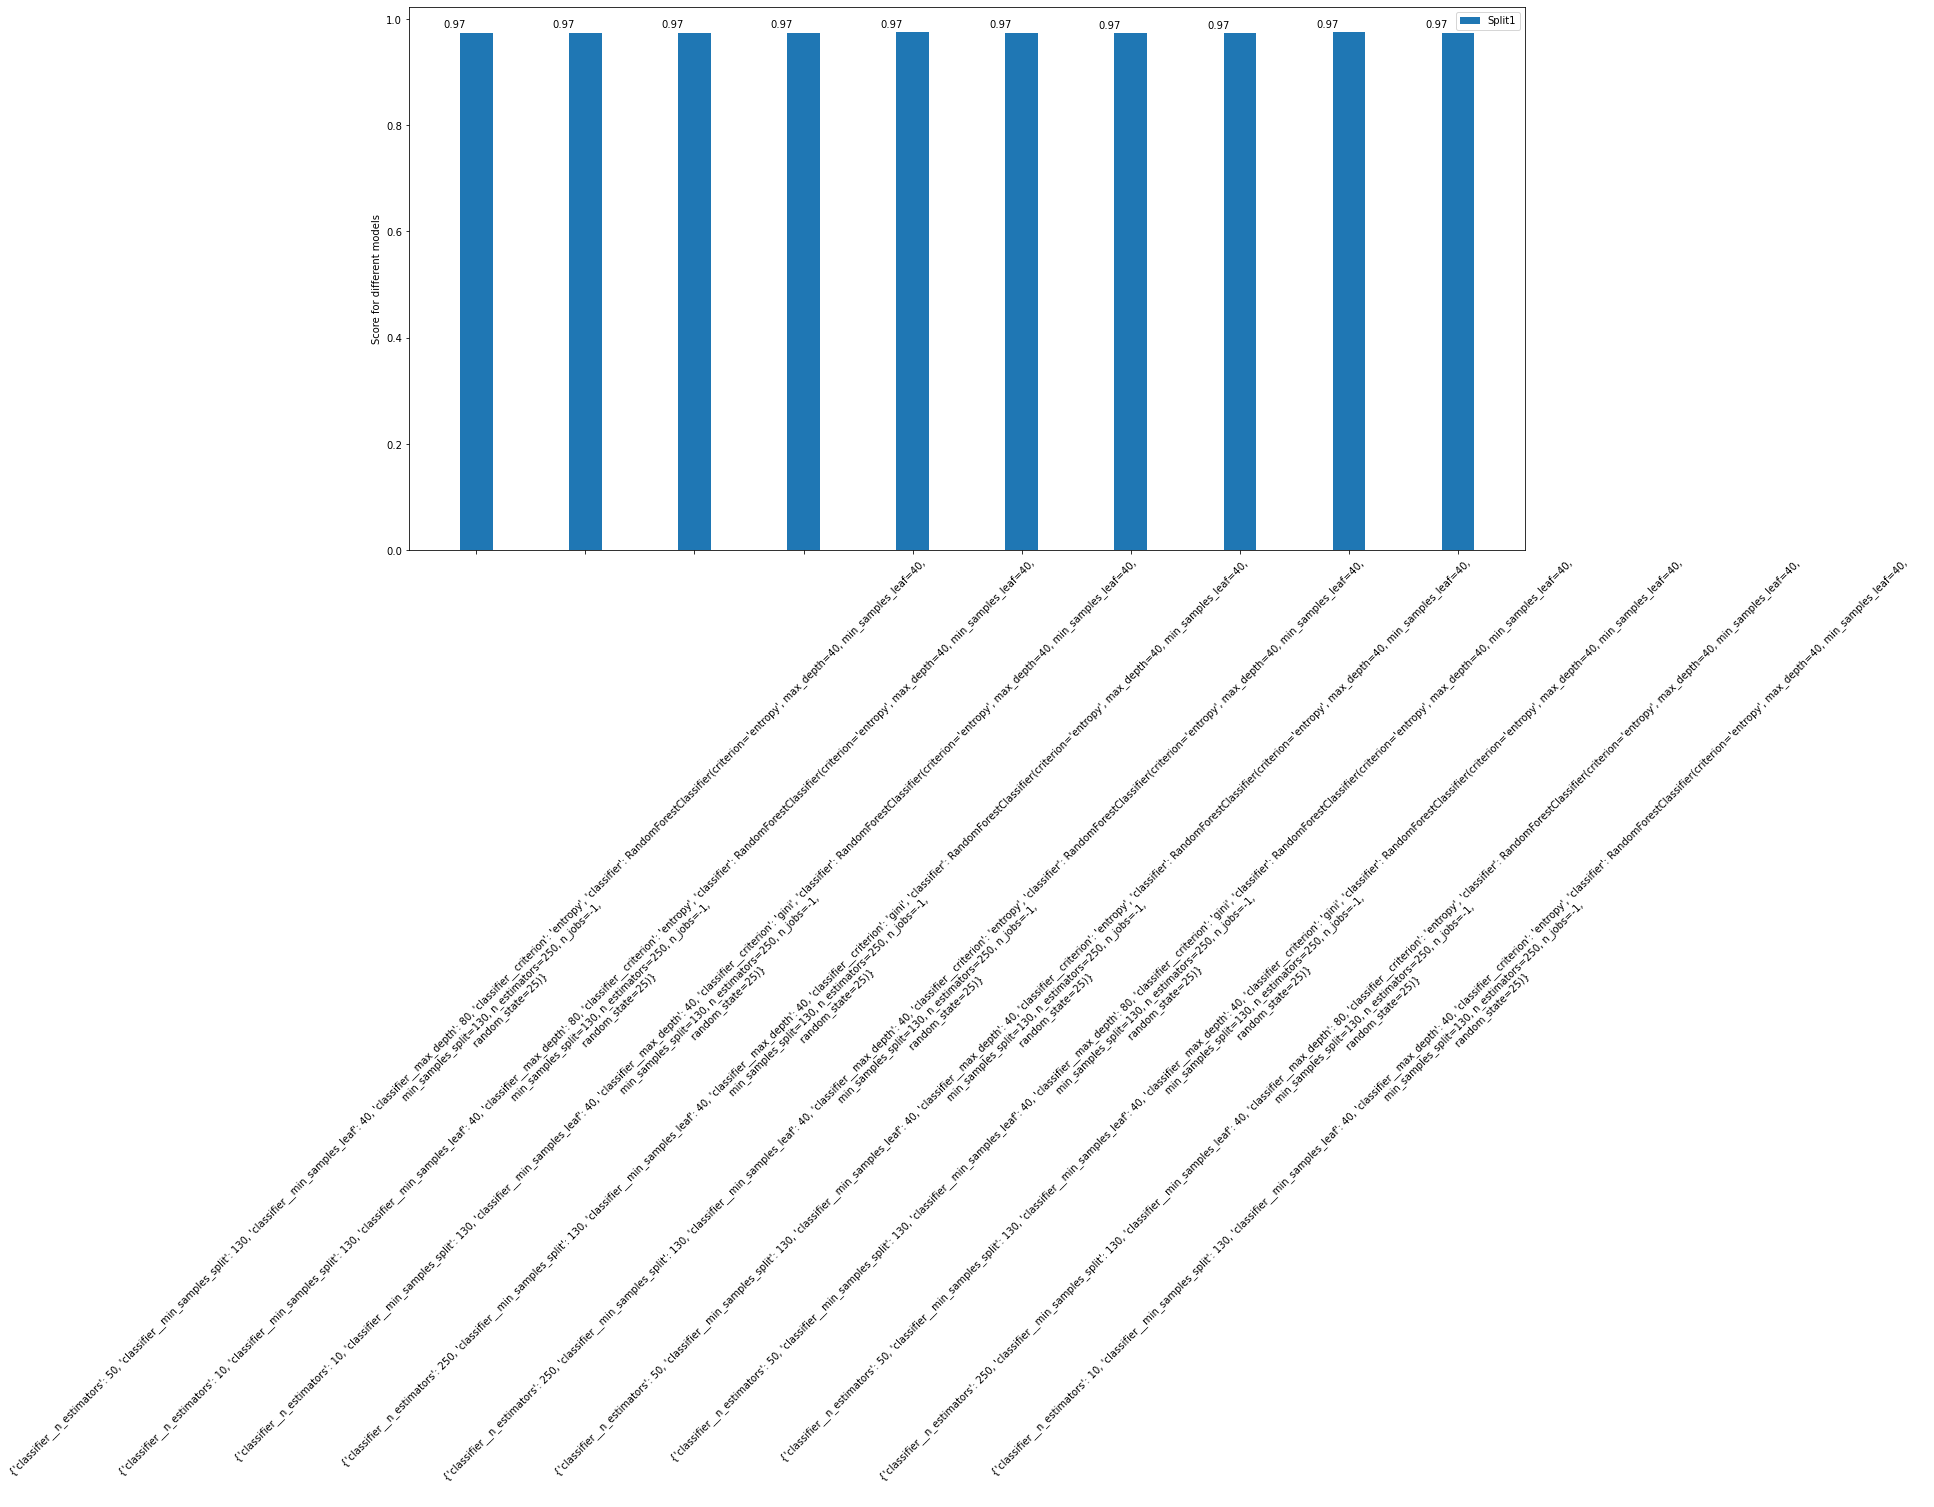

The score for the second split with each parameter


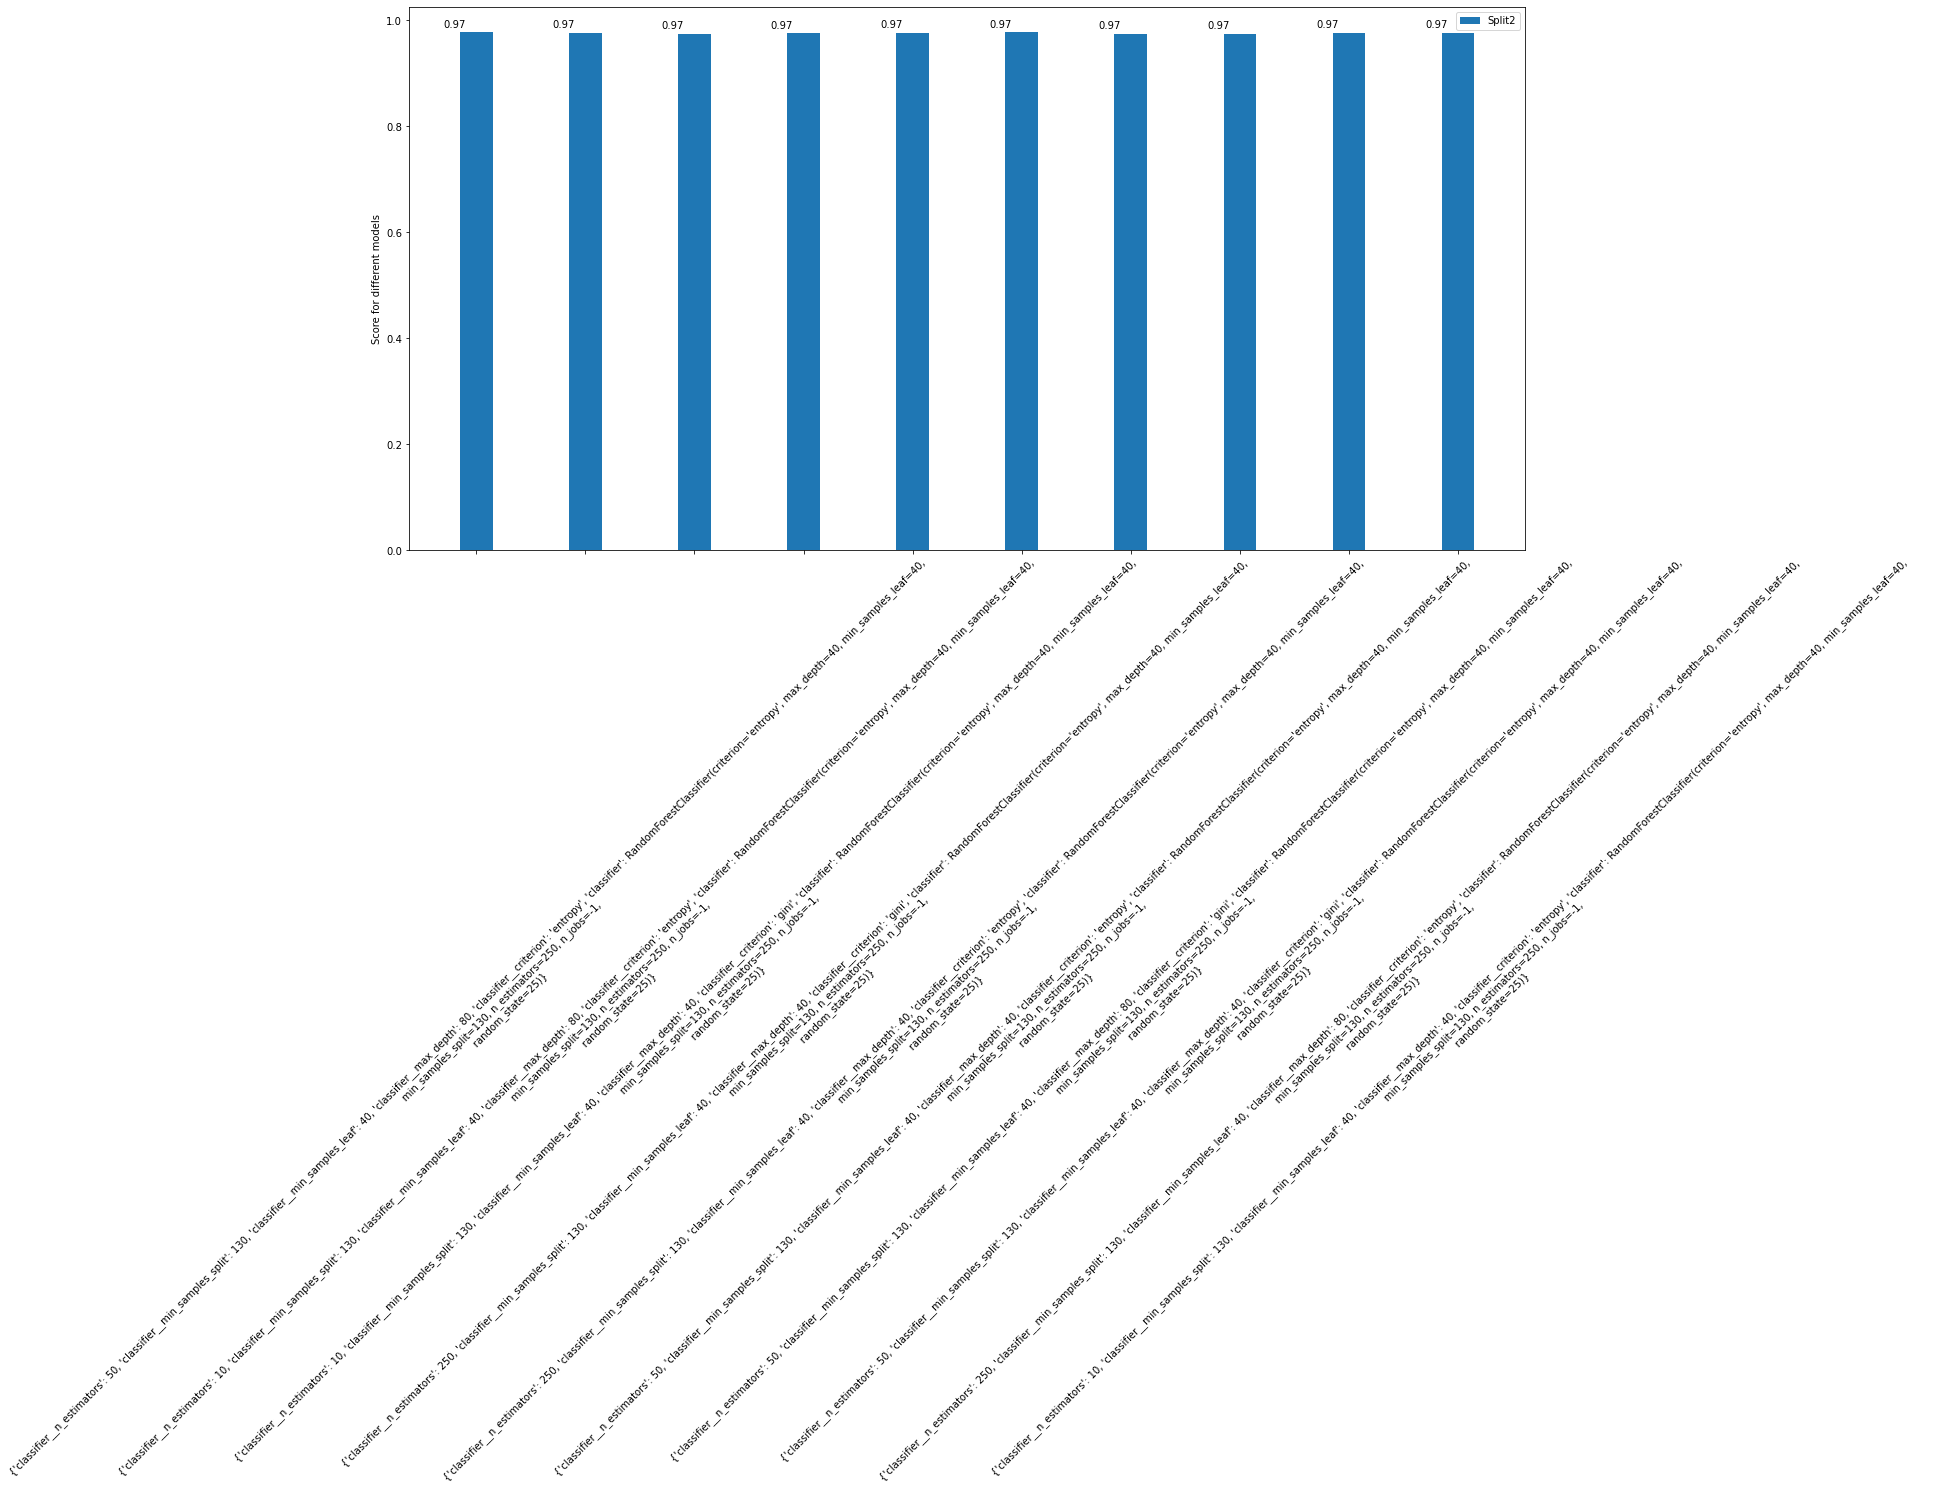

The score for the third split with each parameter


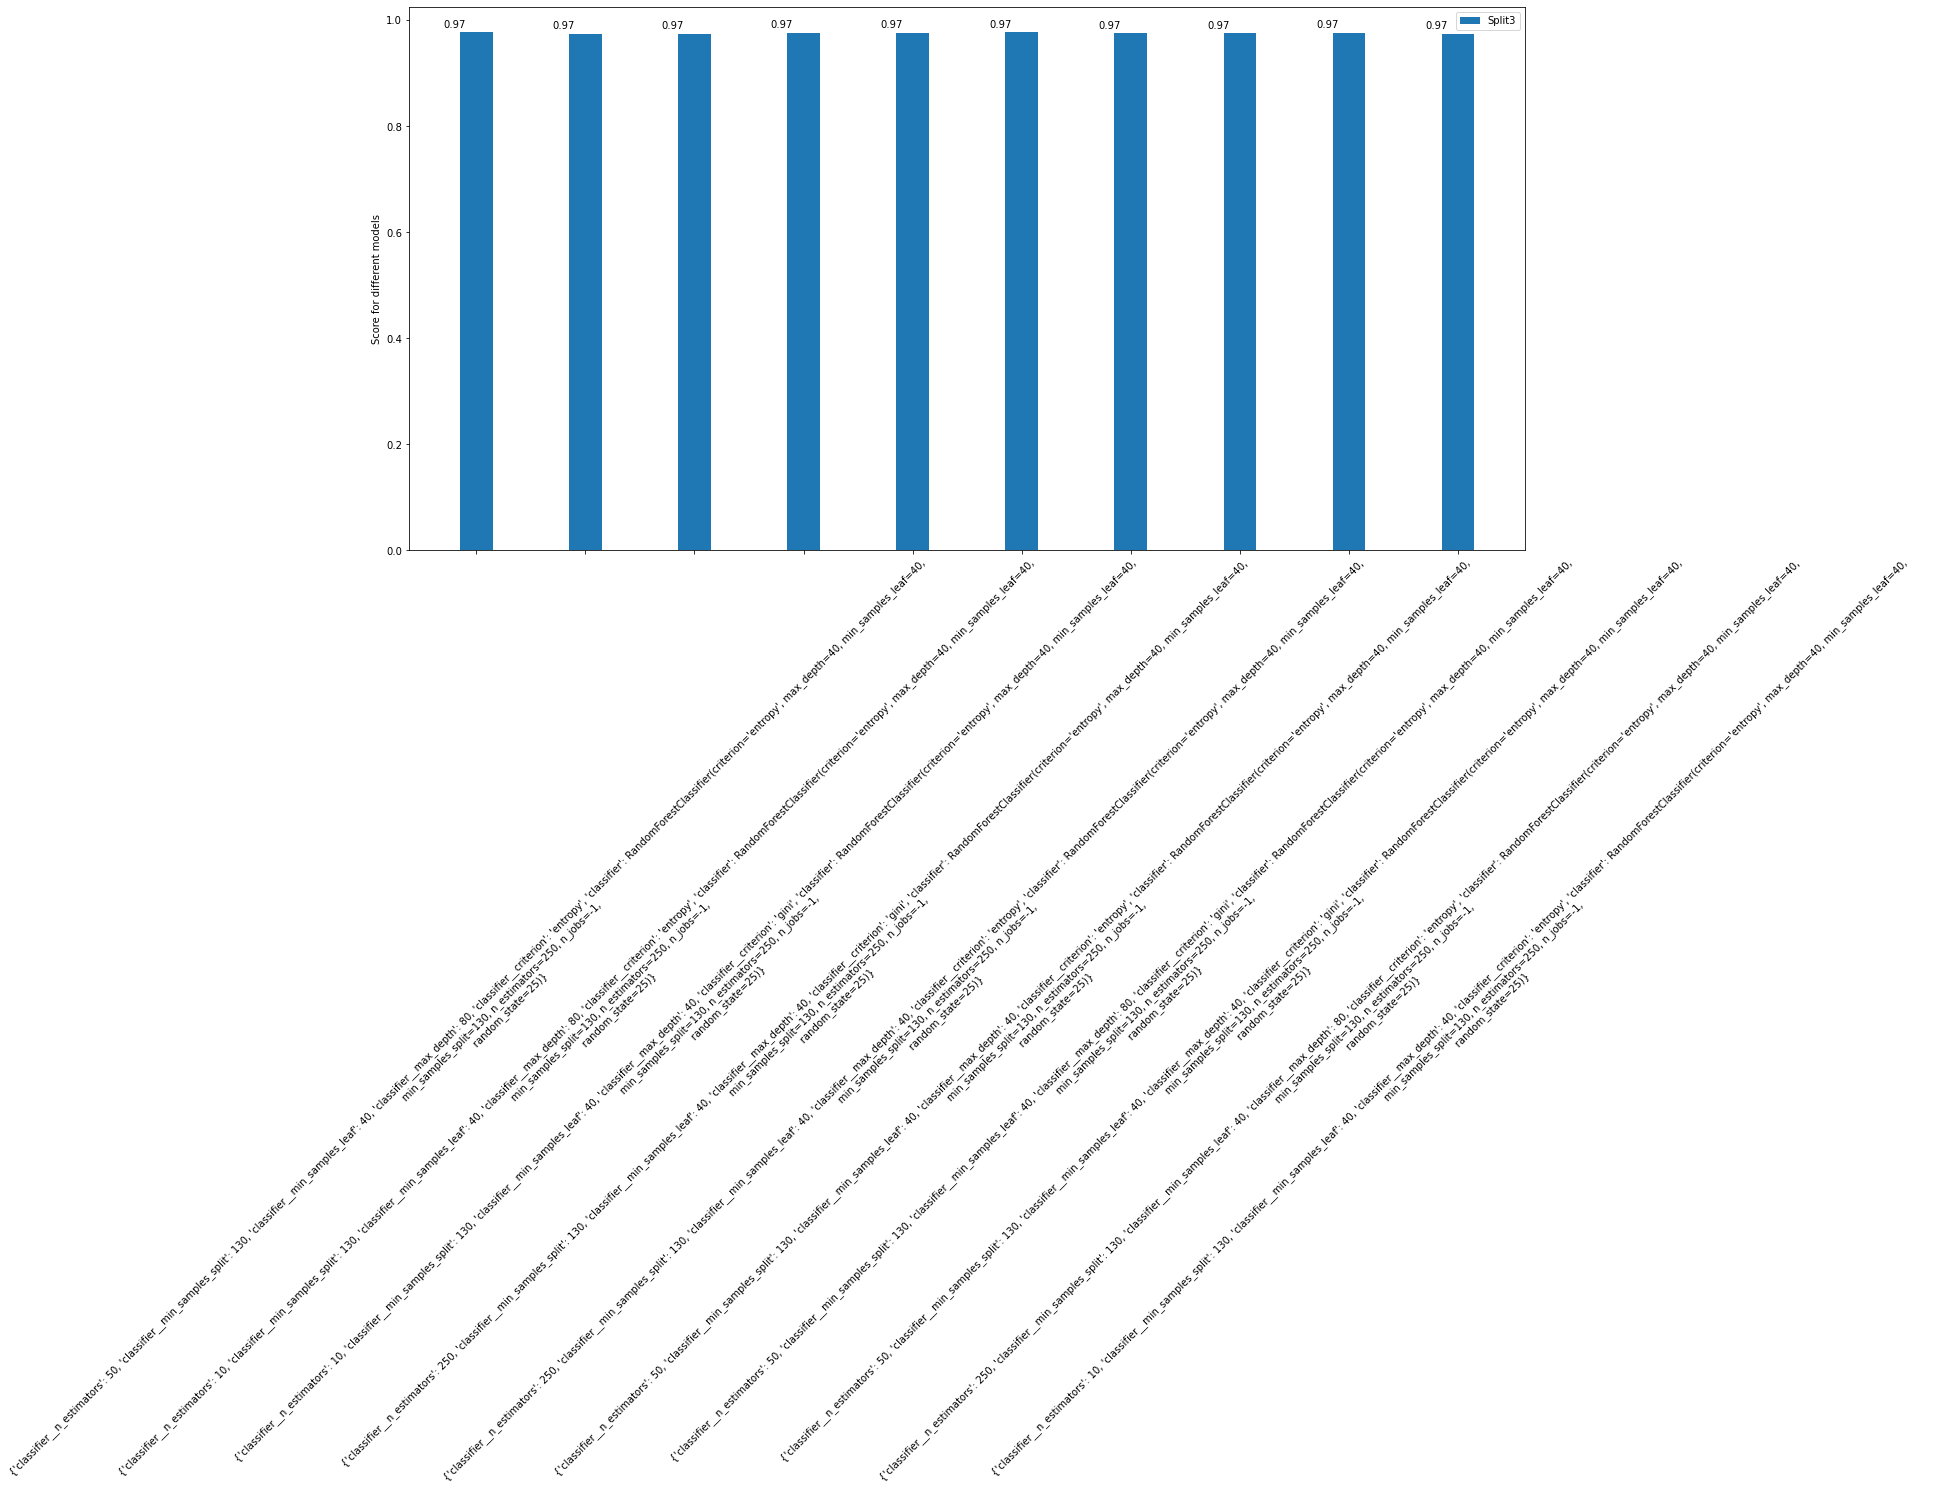

The score for the fouth split with each parameter


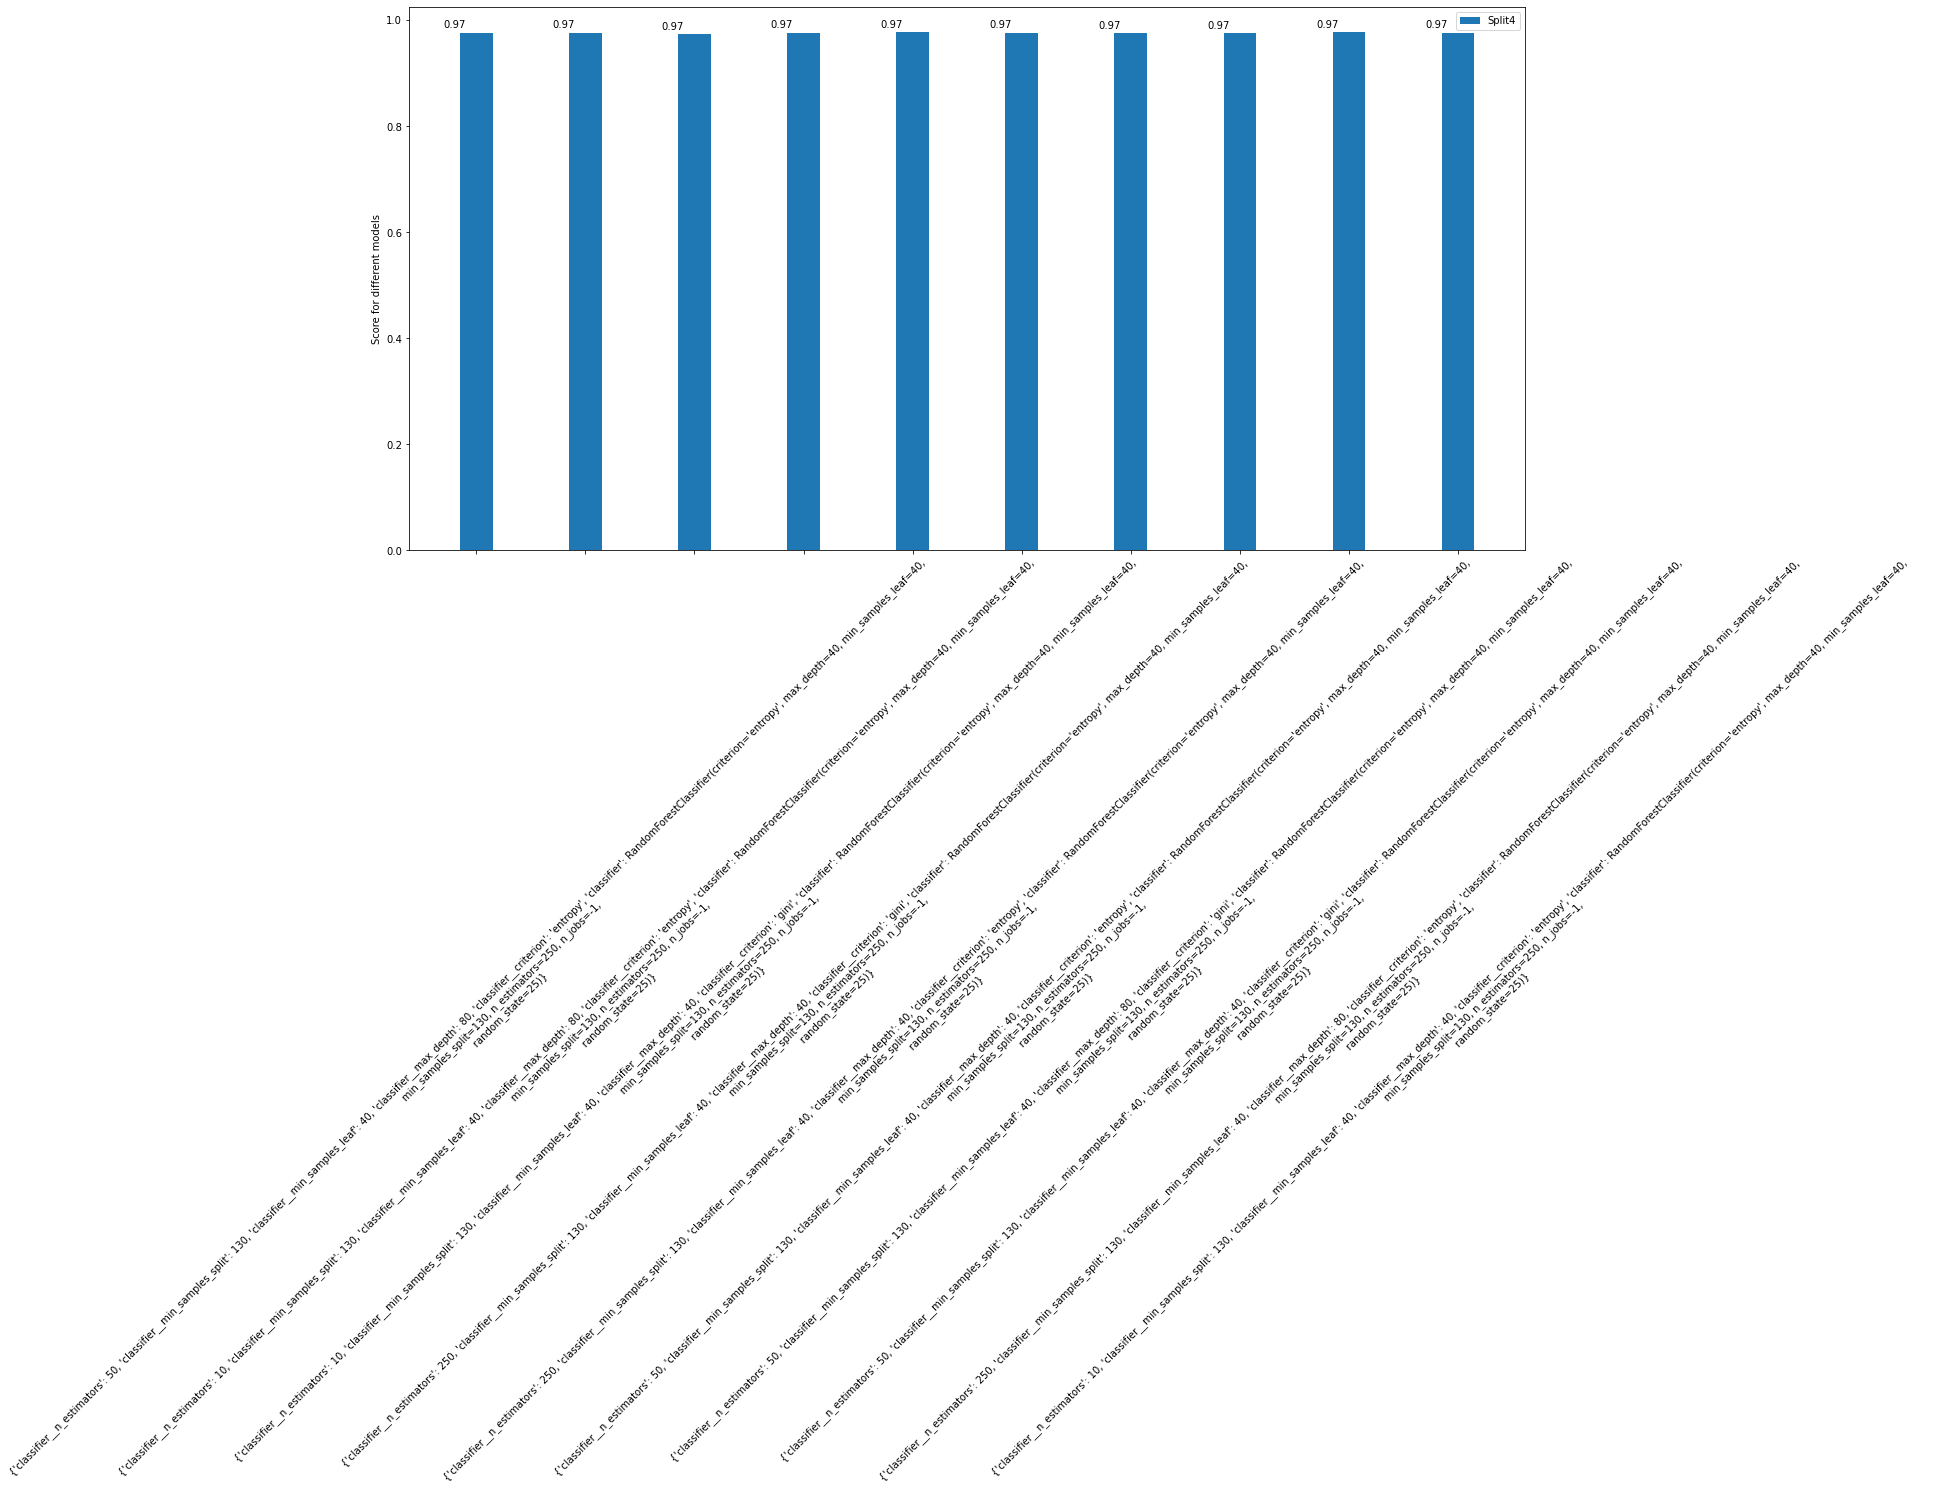

The score for the fifth split with each parameter


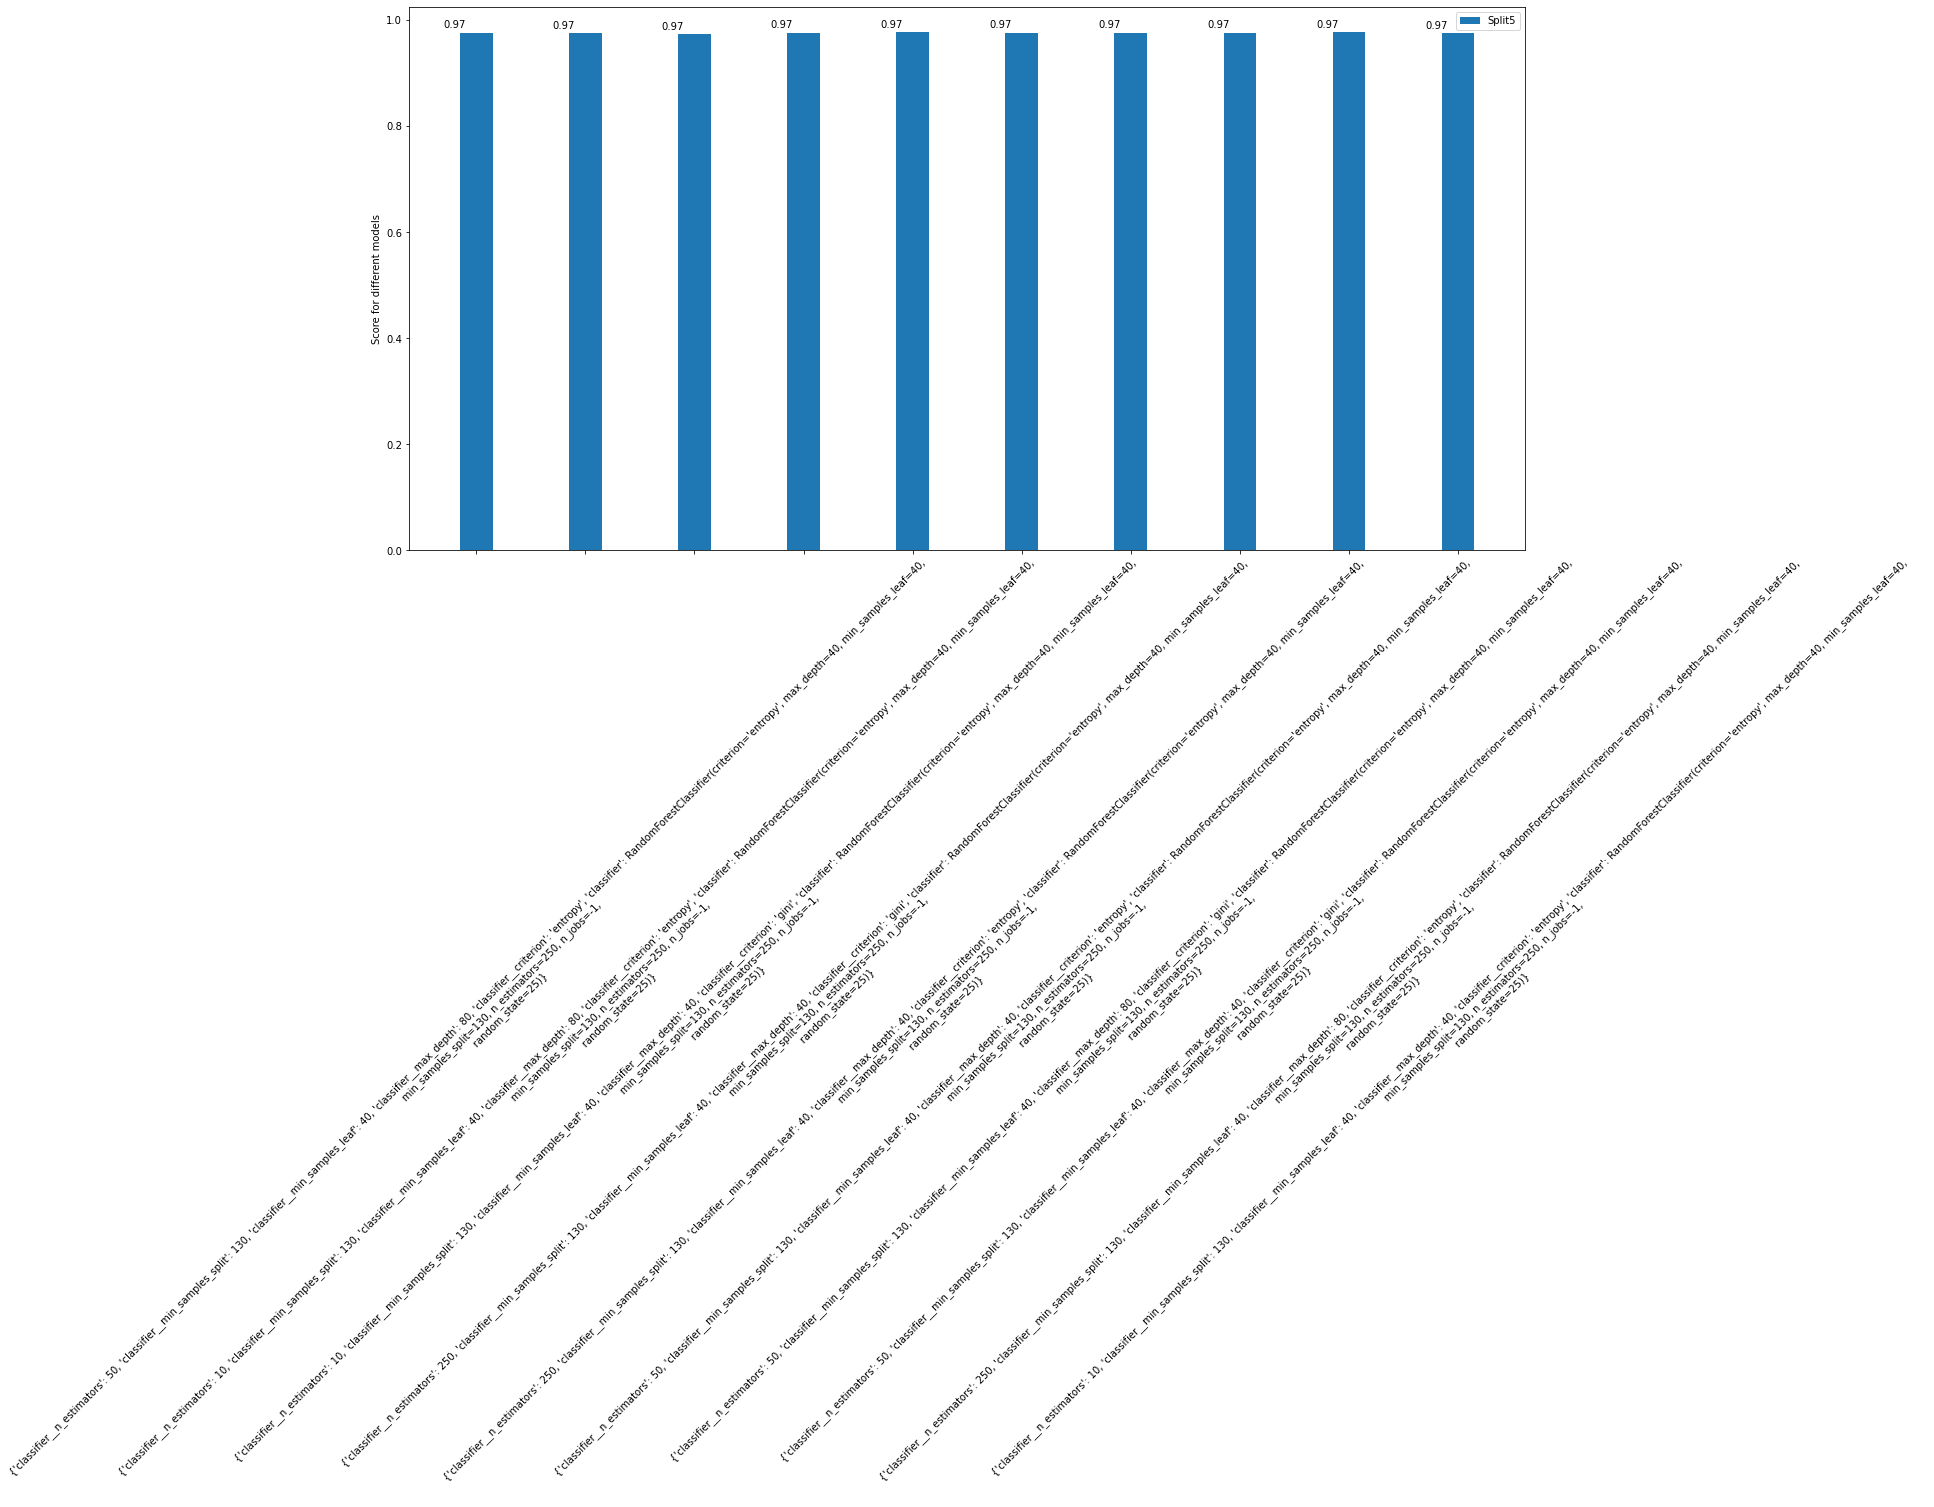

In [26]:
x = np.arange(len(pd.DataFrame(rf_random.cv_results_)["split0_test_f1"]))

print("The score for the first split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split0_test_f1"], width, label='Split1')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split0_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the second split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split1_test_f1"], width, label='Split2')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split1_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the third split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split2_test_f1"], width, label='Split3')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split2_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the fouth split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split3_test_f1"], width, label='Split4')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split3_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the fifth split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split4_test_f1"], width, label='Split5')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split4_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()


## Rank and numeric results of each model

In [27]:
results_df = pd.DataFrame(rf_random.cv_results_)
results_df = results_df.sort_values(by=["mean_test_f1"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
results_df[["params", "mean_test_f1", "mean_test_roc_auc", "mean_test_recall","mean_test_precision","mean_test_balanced_accuracy"]].head(50)

params  \
params                                                                                                  
10_130_40_40_gini_RandomForestClassifier(criter...  {'classifier__n_estimators': 10, 'classifier__...   
50_130_40_80_gini_RandomForestClassifier(criter...  {'classifier__n_estimators': 50, 'classifier__...   
50_130_40_40_gini_RandomForestClassifier(criter...  {'classifier__n_estimators': 50, 'classifier__...   
10_130_40_80_entropy_RandomForestClassifier(cri...  {'classifier__n_estimators': 10, 'classifier__...   
10_130_40_40_entropy_RandomForestClassifier(cri...  {'classifier__n_estimators': 10, 'classifier__...   
250_130_40_40_gini_RandomForestClassifier(crite...  {'classifier__n_estimators': 250, 'classifier_...   
50_130_40_80_entropy_RandomForestClassifier(cri...  {'classifier__n_estimators': 50, 'classifier__...   
50_130_40_40_entropy_RandomForestClassifier(cri...  {'classifier__n_estimators': 50, 'classifier__...   
250_130_40_40_entropy_RandomForestClassifier(cr...  {'classifier__n_estimators': 250, 'classifier_...   
250_130_40_80_entropy_RandomForestClassifier(cr...  {'classifier__n_estimators': 250, 'classifier_...   

                                                    mean_test_f1  \
params                                                             
10_130_40_40_gini_RandomForestClassifier(criter...      0.973309   
50_130_40_80_gini_RandomForestClassifier(criter...      0.974406   
50_130_40_40_gini_RandomForestClassifier(criter...      0.974406   
10_130_40_80_entropy_RandomForestClassifier(cri...      0.974670   
10_130_40_40_entropy_RandomForestClassifier(cri...      0.974670   
250_130_40_40_gini_RandomForestClassifier(crite...      0.974989   
50_130_40_80_entropy_RandomForestClassifier(cri...      0.975699   
50_130_40_40_entropy_RandomForestClassifier(cri...      0.975699   
250_130_40_40_entropy_RandomForestClassifier(cr...      0.975811   
250_130_40_80_entropy_RandomForestClassifier(cr...      0.975811   

                                                    mean_test_roc_auc  \
params                                                                  
10_130_40_40_gini_RandomForestClassifier(criter...           0.996426   
50_130_40_80_gini_RandomForestClassifier(criter...           0.996910   
50_130_40_40_gini_RandomForestClassifier(criter...           0.996910   
10_130_40_80_entropy_RandomForestClassifier(cri...           0.996654   
10_130_40_40_entropy_RandomForestClassifier(cri...           0.996654   
250_130_40_40_gini_RandomForestClassifier(crite...           0.996979   
50_130_40_80_entropy_RandomForestClassifier(cri...           0.997001   
50_130_40_40_entropy_RandomForestClassifier(cri...           0.997001   
250_130_40_40_entropy_RandomForestClassifier(cr...           0.997081   
250_130_40_80_entropy_RandomForestClassifier(cr...           0.997081   

                                                    mean_test_recall  \
params                                                                 
10_130_40_40_gini_RandomForestClassifier(criter...          0.958714   
50_130_40_80_gini_RandomForestClassifier(criter...          0.960059   
50_130_40_40_gini_RandomForestClassifier(criter...          0.960059   
10_130_40_80_entropy_RandomForestClassifier(cri...          0.961944   
10_130_40_40_entropy_RandomForestClassifier(cri...          0.961944   
250_130_40_40_gini_RandomForestClassifier(crite...          0.961142   
50_130_40_80_entropy_RandomForestClassifier(cri...          0.962566   
50_130_40_40_entropy_RandomForestClassifier(cri...          0.962566   
250_130_40_40_entropy_RandomForestClassifier(cr...          0.962687   
250_130_40_80_entropy_RandomForestClassifier(cr...          0.962687   

                                                    mean_test_precision  \
params                                                                    
10_130_40_40_gini_RandomForestClassifier(criter...             0.988360   
50_130_40_80_gini_RandomForestClassifier(criter...

## Dependency between cv fold and AUC scores

                                                    split0_test_f1  \
params                                                               
10_130_40_40_gini_RandomForestClassifier(criter...        0.973392   
50_130_40_80_gini_RandomForestClassifier(criter...        0.972967   
50_130_40_40_gini_RandomForestClassifier(criter...        0.972967   
10_130_40_80_entropy_RandomForestClassifier(cri...        0.973253   
10_130_40_40_entropy_RandomForestClassifier(cri...        0.973253   
250_130_40_40_gini_RandomForestClassifier(crite...        0.973706   
50_130_40_80_entropy_RandomForestClassifier(cri...        0.973994   
50_130_40_40_entropy_RandomForestClassifier(cri...        0.973994   
250_130_40_40_entropy_RandomForestClassifier(cr...        0.974490   
250_130_40_80_entropy_RandomForestClassifier(cr...        0.974490   

                                                    split1_test_f1  \
params                                                               
10_130_40_40_gini_R

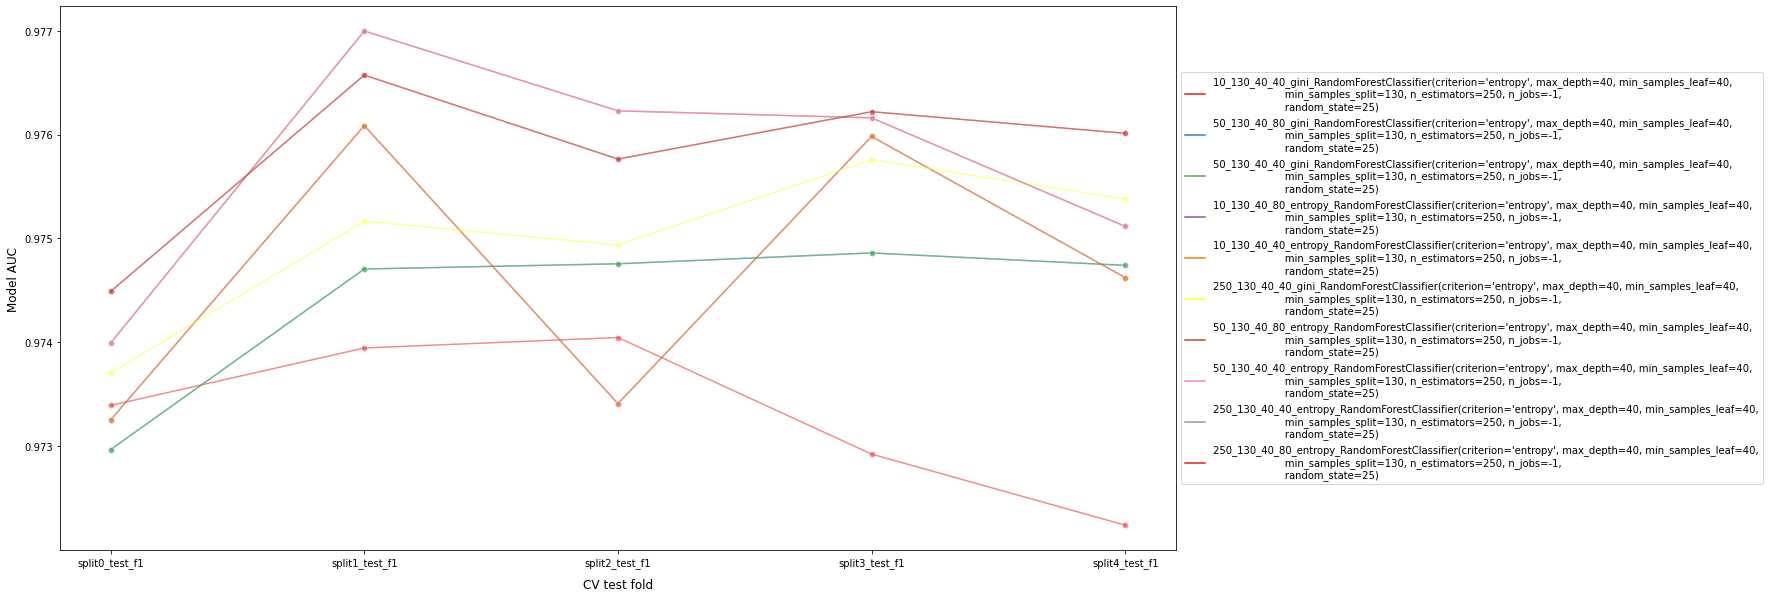

In [28]:
import seaborn as sns
model_scores = results_df.filter(regex=r"split\d*_test_f1")
print(model_scores)

fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(
    data=model_scores.transpose().iloc[:5],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [29]:
print(rf_random.best_estimator_)
rf_random.best_params_

Pipeline(steps=[('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=40,
                                        min_samples_leaf=40,
                                        min_samples_split=130, n_estimators=250,
                                        n_jobs=-1, random_state=25))])


{'classifier__n_estimators': 250,
 'classifier__min_samples_split': 130,
 'classifier__min_samples_leaf': 40,
 'classifier__max_depth': 40,
 'classifier__criterion': 'entropy',
 'classifier': RandomForestClassifier(criterion='entropy', max_depth=40, min_samples_leaf=40,
                        min_samples_split=130, n_estimators=250, n_jobs=-1,
                        random_state=25)}

# Xgboost

RandomForestClassifier(max_depth=35, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)
[21:36:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The f1 score is =  0.9852978072156154
[21:36:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The f1 score is =  0.9841367311431788
[21:37:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

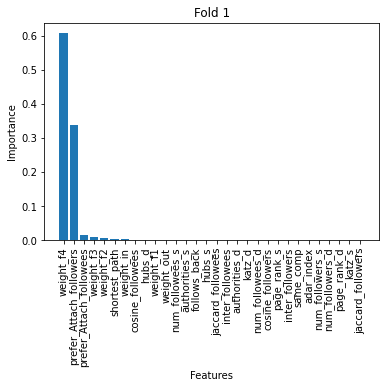

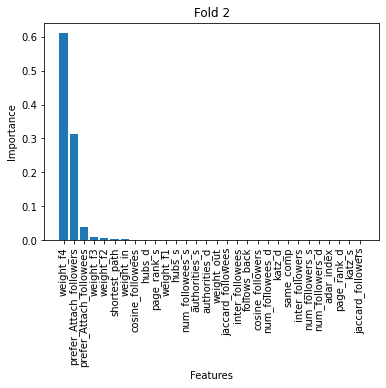

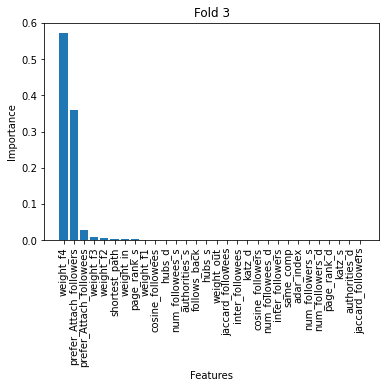

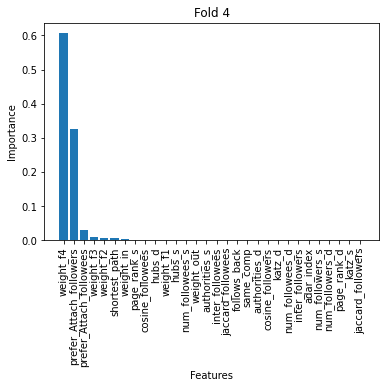

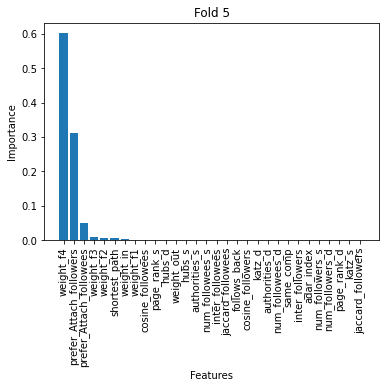

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification



# classification dataset
#data_x, data_y = make_classification(n_features=9)

# feature names must be declared outside the function
feature_names = list(df_final_train.columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)

count = 1
# test data is not needed for fitting
for train_index, test_index in kf.split(df_final_train, y_train):
    X_train, X_test = df_final_train.iloc[train_index], df_final_train.iloc[test_index]
    y_train_rfc, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
    rfc = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
    rfc.fit(X_train, y_train_rfc)
    pr=rfc.predict(X_test)
    print("The f1 score is = ",f1_score(y_test,pr))
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfc.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, rfc.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()

filename = 'finalized_model_xgb.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [70]:
[feature_names[-i] for i in importances_index_desc]

['weight_f4',
 'prefer_Attach_followers',
 'prefer_Attach_followees',
 'weight_f3',
 'weight_f2',
 'shortest_path',
 'weight_in',
 'weight_f1',
 'cosine_followees',
 'page_rank_s',
 'hubs_d',
 'weight_out',
 'hubs_s',
 'authorities_s',
 'num_followees_s',
 'inter_followees',
 'jaccard_followees',
 'follows_back',
 'cosine_followers',
 'katz_d',
 'authorities_d',
 'num_followees_d',
 'same_comp',
 'inter_followers',
 'adar_index',
 'num_followers_s',
 'num_followers_d',
 'page_rank_d',
 'katz_s',
 'jaccard_followers']

## Xgboost Features

[17:02:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The f1 score is =  0.9845350471982326
[17:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The f1 score is =  0.9828442669124801
[17:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old beha

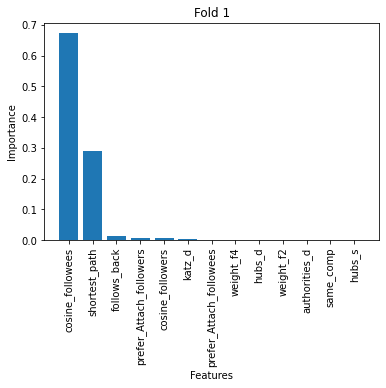

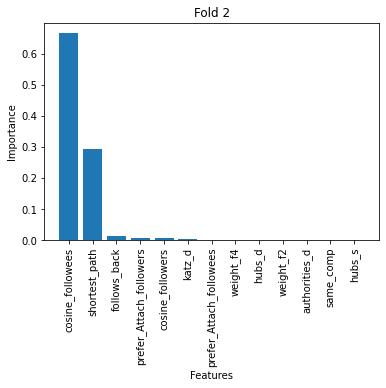

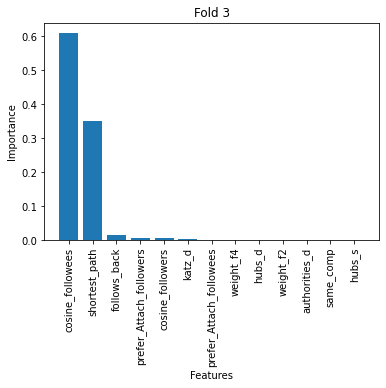

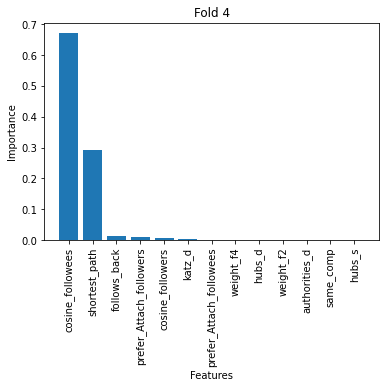

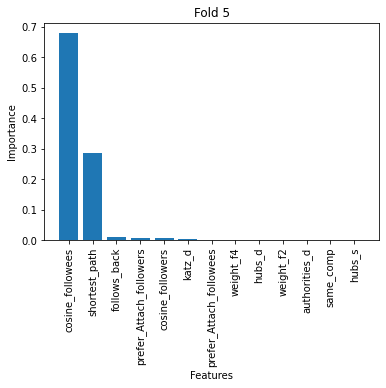

Wall time: 41.3 s


In [16]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification



# classification dataset
#data_x, data_y = make_classification(n_features=9)

# feature names must be declared outside the function
feature_names = list(df_final_train[['weight_f4', 'prefer_Attach_followers', 'prefer_Attach_followees', 'weight_f2', 'shortest_path', 'cosine_followees', 'hubs_d','hubs_s', 'follows_back', 'cosine_followers', 'katz_d', 'authorities_d', 'same_comp']].columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)

count = 1
# test data is not needed for fitting
for train_index, test_index in kf.split(df_final_train, y_train):
    X_train, X_test = df_final_train[['weight_f4', 'prefer_Attach_followers', 'prefer_Attach_followees', 'weight_f2', 'shortest_path', 'cosine_followees', 'hubs_d','hubs_s', 'follows_back', 'cosine_followers', 'katz_d', 'authorities_d', 'same_comp']].iloc[train_index], df_final_train[['weight_f4', 'prefer_Attach_followers', 'prefer_Attach_followees', 'weight_f2', 'shortest_path', 'cosine_followees', 'hubs_d','hubs_s', 'follows_back', 'cosine_followers', 'katz_d', 'authorities_d', 'same_comp']].iloc[test_index]
    y_train_rfc, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
    rfc = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
    rfc.fit(X_train, y_train_rfc)
    pr=rfc.predict(X_test)
    print("The f1 score is = ",f1_score(y_test,pr))
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfc.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, rfc.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()

filename = 'finalized_model_xgb_big.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [94]:
len([feature_names[-i] for i in importances_index_desc])

12

## Xgb Small feat

[17:02:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The f1 score is =  0.9686961807314355
[17:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The f1 score is =  0.968508002065049
[17:02:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behav

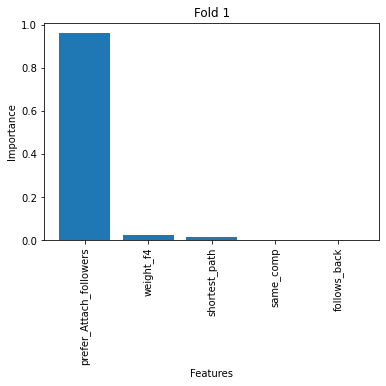

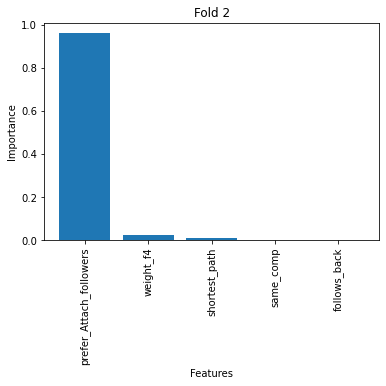

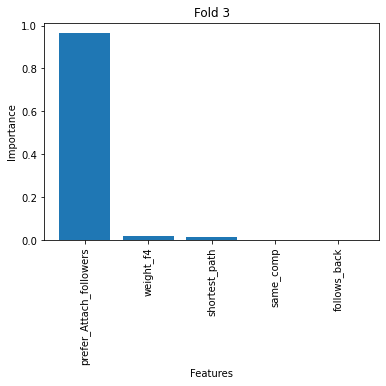

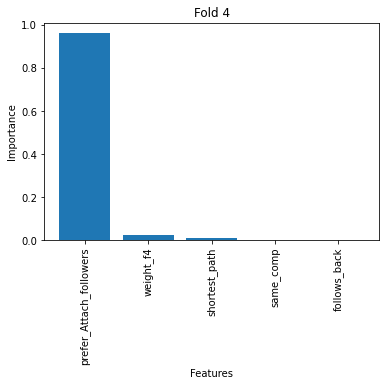

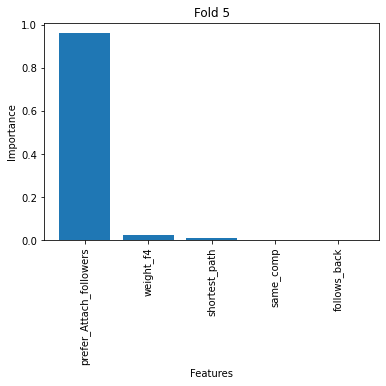

Wall time: 15.4 s


In [15]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification



# classification dataset
#data_x, data_y = make_classification(n_features=9)
clm=[
 'shortest_path',
 'follows_back',
 'same_comp',
 'weight_f4',
 'prefer_Attach_followers'
]

clm2=['weight_f4', 'follows_back', 'cosine_followers', 'katz_d', 'authorities_d']
# feature names must be declared outside the function
feature_names = list(df_final_train[clm].columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)

count = 1
# test data is not needed for fitting
for train_index, test_index in kf.split(df_final_train, y_train):
    X_train, X_test = df_final_train[clm].iloc[train_index], df_final_train[clm].iloc[test_index]
    y_train_rfc, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
    rfc = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
    rfc.fit(X_train, y_train_rfc)
    pr=rfc.predict(X_test)
    print("The f1 score is = ",f1_score(y_test,pr))
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfc.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, rfc.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()

filename = 'finalized_model_xgb_small.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [118]:
len([feature_names[-i] for i in importances_index_desc])

5

## Random Forest

RandomForestClassifier(max_depth=35, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)
The f1 score is =  0.976916067631872
The f1 score is =  0.975609756097561
The f1 score is =  0.9755458074925629
The f1 score is =  0.9733887094293187
The f1 score is =  0.9772979517707598


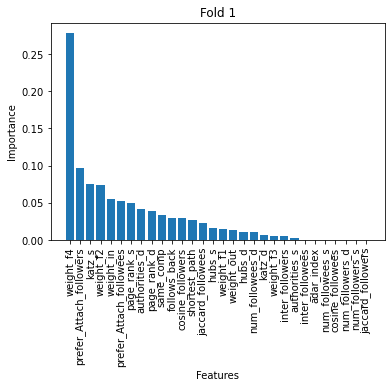

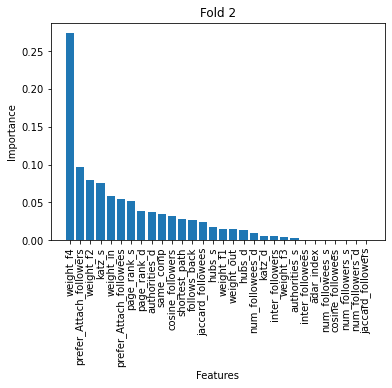

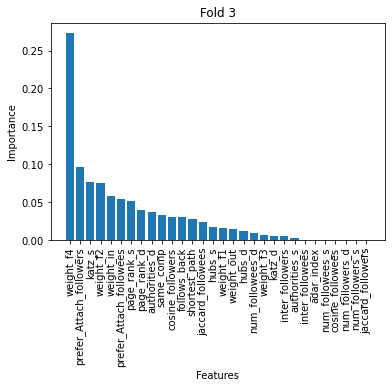

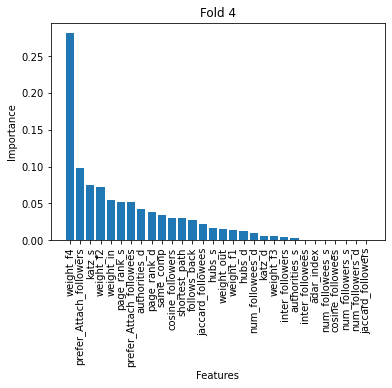

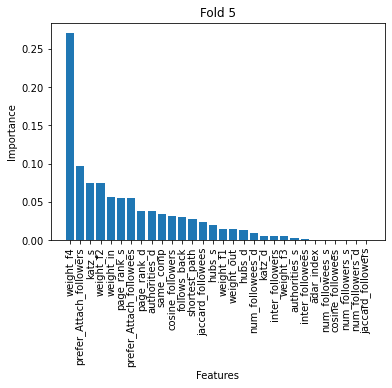

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

# classification dataset
#data_x, data_y = make_classification(n_features=9)

# feature names must be declared outside the function
feature_names = list(df_final_train.columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)
rfc = RandomForestClassifier(max_depth=35, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)
print(rfc)
count = 1
# test data is not needed for fitting
for train_index, test_index in kf.split(df_final_train, y_train):
    X_train, X_test = df_final_train.iloc[train_index], df_final_train.iloc[test_index]
    y_train_rfc, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
    rfc.fit(X_train, y_train_rfc)
    pr=rfc.predict(X_test)
    print("The f1 score is = ",f1_score(y_test,pr))
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfc.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, rfc.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()

filename = 'finalized_model_rfc.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [23]:
[feature_names[-i] for i in importances_index_desc]

['weight_f4',
 'prefer_Attach_followers',
 'katz_s',
 'weight_f2',
 'weight_in',
 'page_rank_s',
 'prefer_Attach_followees',
 'page_rank_d',
 'authorities_d',
 'same_comp',
 'cosine_followers',
 'follows_back',
 'shortest_path',
 'jaccard_followees',
 'hubs_s',
 'weight_f1',
 'weight_out',
 'hubs_d',
 'num_followees_d',
 'katz_d',
 'inter_followers',
 'weight_f3',
 'authorities_s',
 'inter_followees',
 'adar_index',
 'num_followees_s',
 'cosine_followees',
 'num_followers_s',
 'num_followers_d',
 'jaccard_followers']

## Random Forest big Feature Sample

RandomForestClassifier(max_depth=35, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)
[1 1 1 ... 0 0 0]
The f1 score is =  0.9503246418633412
[1 1 1 ... 0 0 0]
The f1 score is =  0.9496018440905281
[1 1 1 ... 0 0 0]
The f1 score is =  0.9481969237100674
[1 1 1 ... 0 0 0]
The f1 score is =  0.9490253309704993
[1 1 1 ... 0 0 0]
The f1 score is =  0.9530945294057273


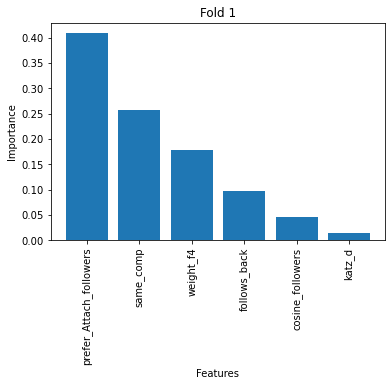

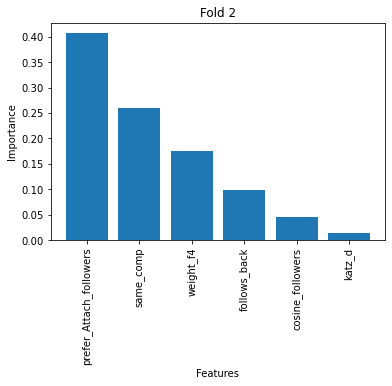

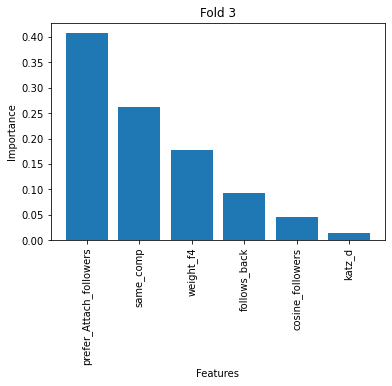

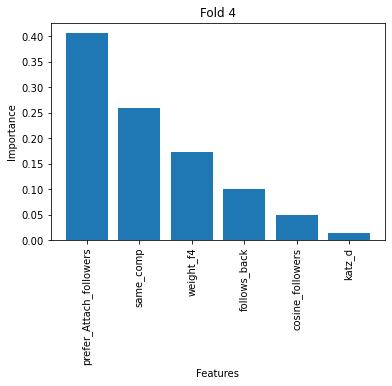

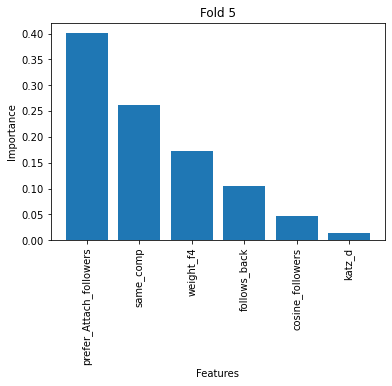

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

# classification dataset
#data_x, data_y = make_classification(n_features=9)

# feature names must be declared outside the function
# feature names must be declared outside the function
feature_names = list(df_final_train[['weight_f4', 'prefer_Attach_followers', 'same_comp','katz_d', 'cosine_followers', 'follows_back']].columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)
rfc = RandomForestClassifier(max_depth=35, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)
print(rfc)
count = 1
# test data is not needed for fitting
for train_index, test_index in kf.split(df_final_train, y_train):
    X_train, X_test = df_final_train[['weight_f4', 'prefer_Attach_followers','katz_d', 'same_comp', 'cosine_followers', 'follows_back' ]].iloc[train_index], df_final_train[['weight_f4', 'prefer_Attach_followers','katz_d', 'same_comp', 'cosine_followers', 'follows_back']].iloc[test_index]
    y_train_rfc, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
    rfc.fit(X_train, y_train_rfc)
    pr=rfc.predict(X_test)
    print(pr)
    print("The f1 score is = ",f1_score(y_test,pr))
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfc.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, rfc.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()

filename = 'finalized_model_rfc_sample.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [67]:
[feature_names[-i] for i in importances_index_desc]

['prefer_Attach_followers',
 'same_comp',
 'weight_f4',
 'follows_back',
 'cosine_followers',
 'katz_d']

## Random Forest Featurization

RandomForestClassifier(max_depth=35, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)
[1 1 1 ... 1 0 1]
The f1 score is =  0.9649560042724175
[1 1 1 ... 0 0 0]
The f1 score is =  0.9641575196379337
[1 1 1 ... 0 0 0]
The f1 score is =  0.9644958409413673
[1 1 1 ... 0 0 0]
The f1 score is =  0.962867457452295
[1 1 1 ... 0 0 0]
The f1 score is =  0.9676862983817786


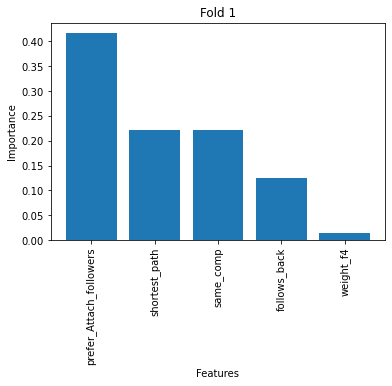

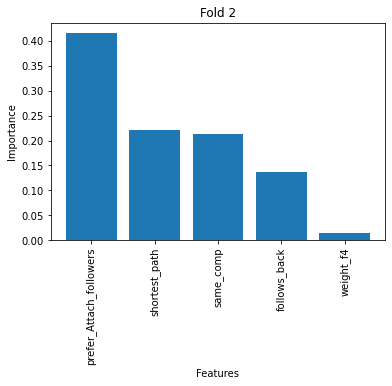

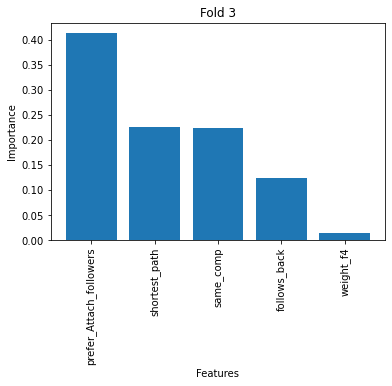

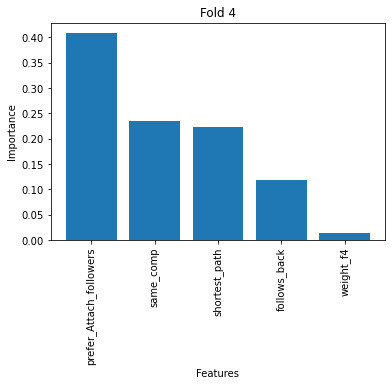

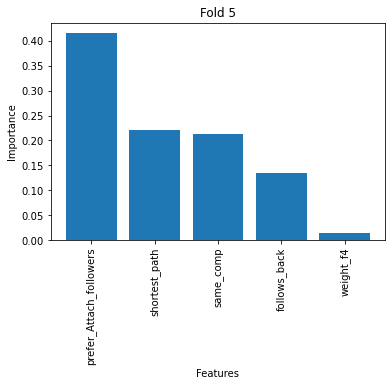

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

# classification dataset
#data_x, data_y = make_classification(n_features=9)

clm=[
 'shortest_path',
 'follows_back',
 'same_comp',
 'weight_f4',
 'prefer_Attach_followers'
]


# feature names must be declared outside the function
feature_names = list(df_final_train[clm].columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)
rfc = RandomForestClassifier(max_depth=35, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)
print(rfc)
count = 1
# test data is not needed for fitting
for train_index, test_index in kf.split(df_final_train, y_train):
    X_train, X_test = df_final_train[clm].iloc[train_index], df_final_train[clm].iloc[test_index]
    y_train_rfc, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
    
    rfc = RandomForestClassifier(max_depth=35, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)
    rfc.fit(X_train, y_train_rfc)
    pr=rfc.predict(X_test)
    print(pr)
    print("The f1 score is = ",f1_score(y_test,pr))
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfc.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, rfc.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()


filename = 'finalized_model_rfc_small_sample.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [76]:
[feature_names[-i] for i in importances_index_desc]

['prefer_Attach_followers',
 'shortest_path',
 'same_comp',
 'follows_back',
 'weight_f4']

## Lightgbm

LightGBM Model accuracy score: 0.9851
LightGBM Model f1 score: 0.9850
LightGBM Model recall score: 0.9782


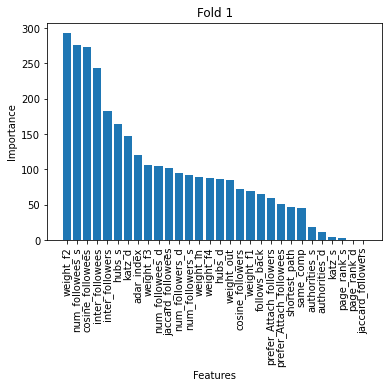

LightGBM Model accuracy score: 0.9829
LightGBM Model f1 score: 0.9825
LightGBM Model recall score: 0.9757


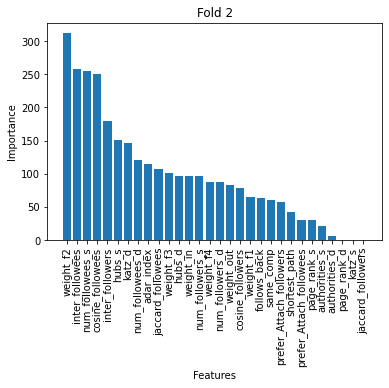

LightGBM Model accuracy score: 0.9838
LightGBM Model f1 score: 0.9838
LightGBM Model recall score: 0.9769


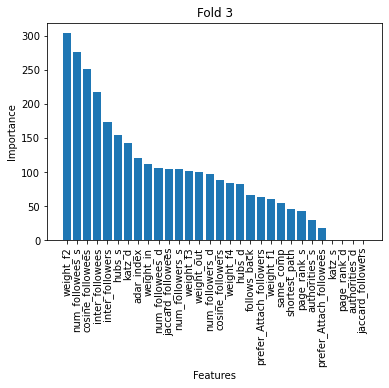

LightGBM Model accuracy score: 0.9830
LightGBM Model f1 score: 0.9827
LightGBM Model recall score: 0.9751


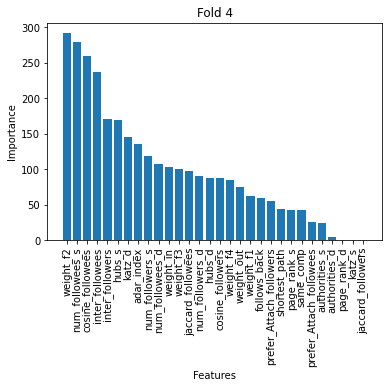

LightGBM Model accuracy score: 0.9843
LightGBM Model f1 score: 0.9843
LightGBM Model recall score: 0.9779


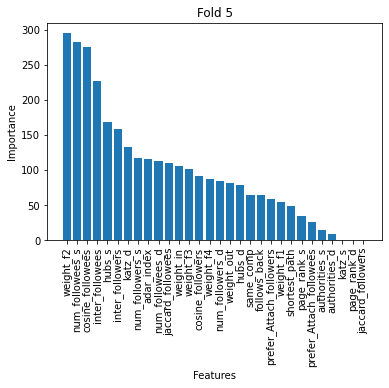

In [5]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


feature_names = list(df_final_train.columns)


cv = KFold(n_splits=5, random_state=25,shuffle=True)
# perform cross-validation procedure
count=1
for train_ix, test_ix in cv.split(df_final_train):
    # split data
    X_train, X_test = df_final_train.iloc[train_ix, :], df_final_train.iloc[test_ix, :]
    y_train_lgb, y_test_lgb = y_train.iloc[train_ix], y_train.iloc[test_ix]
    clf = lgb.LGBMClassifier()
    clf.fit(X_train, y_train_lgb)

    y_pred=clf.predict(X_test)
    print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_lgb, y_pred)))
    print('LightGBM Model f1 score: {0:0.4f}'.format(f1_score(y_test_lgb, y_pred)))
    print('LightGBM Model recall score: {0:0.4f}'.format(recall_score(y_test_lgb, y_pred)))
    
    importances_index_desc = np.argsort(clf.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, clf.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count=count+1
    plt.show()
    
filename = 'finalized_model_lgb.sav'
pickle.dump(clf, open(filename, 'wb'))

In [6]:
[feature_names[-i] for i in importances_index_desc]

['weight_f2',
 'num_followees_s',
 'cosine_followees',
 'inter_followees',
 'hubs_s',
 'inter_followers',
 'katz_d',
 'num_followers_s',
 'adar_index',
 'num_followees_d',
 'jaccard_followees',
 'weight_in',
 'weight_f3',
 'cosine_followers',
 'weight_f4',
 'num_followers_d',
 'weight_out',
 'hubs_d',
 'same_comp',
 'follows_back',
 'prefer_Attach_followers',
 'weight_f1',
 'shortest_path',
 'page_rank_s',
 'prefer_Attach_followees',
 'authorities_s',
 'authorities_d',
 'katz_s',
 'page_rank_d',
 'jaccard_followers']

## LGB Featurization

LGBMClassifier()
[1 1 1 ... 0 0 1]
The f1 score is =  0.9688753490733689
[1 1 1 ... 0 0 0]
The f1 score is =  0.9684537684537685
[1 1 1 ... 0 0 0]
The f1 score is =  0.9692611535929508
[1 1 1 ... 0 0 0]
The f1 score is =  0.9664042804959614
[1 1 1 ... 0 0 0]
The f1 score is =  0.9714112229924606


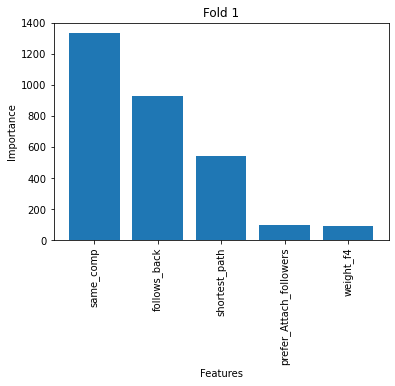

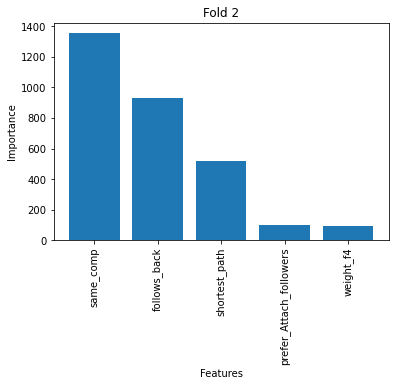

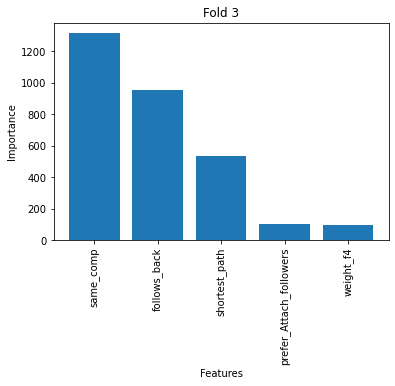

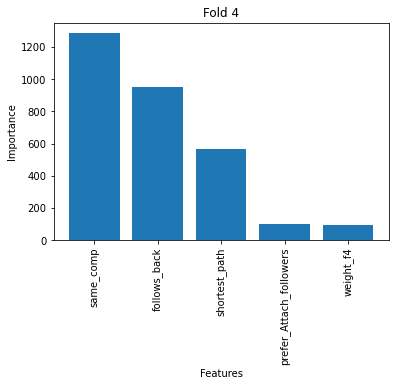

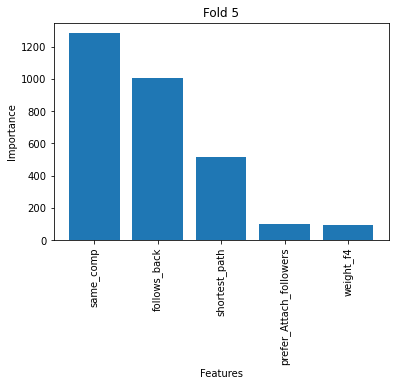

Wall time: 2.18 s


In [68]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

# classification dataset
#data_x, data_y = make_classification(n_features=9)

clm=[
 'shortest_path',
 'follows_back',
 'same_comp',
 'weight_f4',
 'prefer_Attach_followers'
]


# feature names must be declared outside the function
feature_names = list(df_final_train[clm].columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)
rfc = lgb.LGBMClassifier(boosting_type='gbdt')
print(rfc)
count = 1
# test data is not needed for fitting
for train_index, test_index in kf.split(df_final_train, y_train):
    X_train, X_test = df_final_train[clm].iloc[train_index], df_final_train[clm].iloc[test_index]
    y_train_rfc, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
    
    rfc = lgb.LGBMClassifier(boosting_type='gbdt')
    rfc.fit(X_train, y_train_rfc)
    pr=rfc.predict(X_test)
    print(pr)
    print("The f1 score is = ",f1_score(y_test,pr))
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfc.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, rfc.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()

filename = 'finalized_model_lgb_small.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [79]:
[feature_names[-i] for i in importances_index_desc]

['same_comp',
 'follows_back',
 'shortest_path',
 'prefer_Attach_followers',
 'weight_f4']

## LGB Featurization big

LGBMClassifier()
[1 1 1 ... 1 0 0]
The f1 score is =  0.9838539308887881
[1 1 1 ... 0 0 0]
The f1 score is =  0.9822940723633564
[1 1 1 ... 0 0 0]
The f1 score is =  0.9830984502733336
[1 1 1 ... 0 0 0]
The f1 score is =  0.9817219082531441
[1 1 1 ... 0 0 0]
The f1 score is =  0.9833366793816503


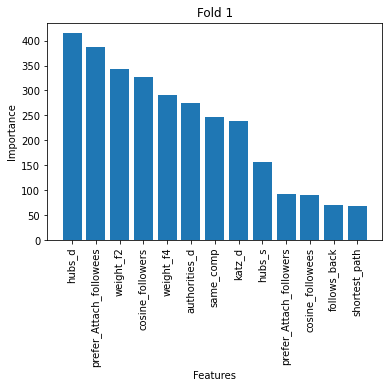

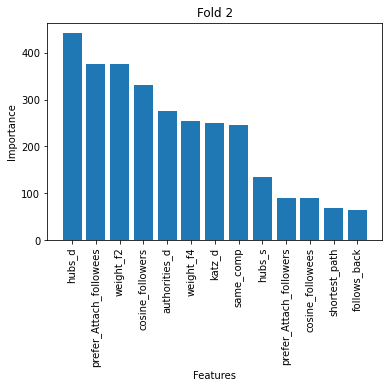

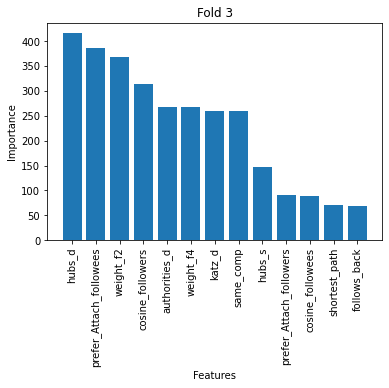

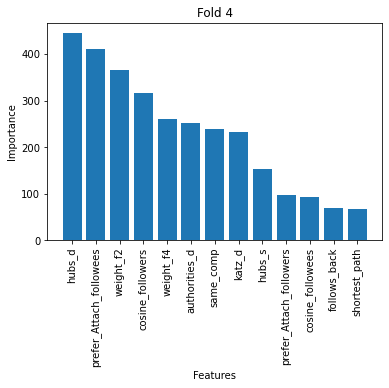

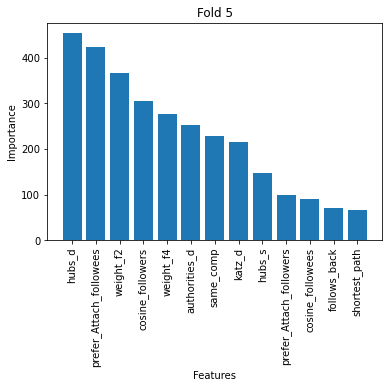

Wall time: 3.38 s


In [18]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

# classification dataset
#data_x, data_y = make_classification(n_features=9)

clm=['weight_f4', 'prefer_Attach_followers', 'prefer_Attach_followees', 'weight_f2', 'shortest_path', 'cosine_followees', 'hubs_d','hubs_s', 'follows_back', 'cosine_followers', 'katz_d', 'authorities_d', 'same_comp']



# feature names must be declared outside the function
feature_names = list(df_final_train[clm].columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)
rfc = lgb.LGBMClassifier()
print(rfc)
count = 1
# test data is not needed for fitting
for train_index, test_index in kf.split(df_final_train, y_train):
    X_train, X_test = df_final_train[clm].iloc[train_index], df_final_train[clm].iloc[test_index]
    y_train_rfc, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
    
    rfc = lgb.LGBMClassifier()
    rfc.fit(X_train, y_train_rfc)
    pr=rfc.predict(X_test)
    print(pr)
    print("The f1 score is = ",f1_score(y_test,pr))
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfc.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, rfc.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()

filename = 'finalized_model_lgb_big.sav'
pickle.dump(rfc, open(filename, 'wb'))

## Everything

In [6]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor,KerasClassifier

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(3,130),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf1 = RandomForestClassifier(random_state=25,n_jobs=-1)

clf2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

clf3= lgb.LGBMClassifier()

# def buildModel():

#     model = Sequential()

#     model.add(Dense(hidden_units, activation=hidden_layer_act))
#     model.add(Dense(hidden_units, activation=hidden_layer_act))
#     model.add(Dense(50, activation=hidden_layer_act))
#     model.add(Dense(50, activation=hidden_layer_act))
#     model.add(Dense(1, activation=output_layer_act))

#     sgd=optimizers.SGD(lr=learning_rate)
#     model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=[f1_m,recall_m])
#     return model


# clf4 = KerasRegressor(build_fn = buildModel)



param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__criterion'] = ["gini", "entropy"]
param1['classifier__max_depth'] = [40,80]
param1['classifier__min_samples_split'] = [130]
param1['classifier__min_samples_leaf'] = [40]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier'] = [clf2]

param3 = {}
param3['classifier'] = [clf3]

# param4={}
# param4['classifier__batch_size']= [0.8*len(df_final_train)]
# param4['classifier__epochs']= [10]
# param4['classifier']=[clf4]

pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2,param3]


print(params)
rf_random = RandomizedSearchCV(pipeline, param_distributions=params,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')
                                   #n_iter=5,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')

rf_random.fit(df_final_train,y_train)
print('mean test f1',rf_random.cv_results_['mean_test_f1'])
print('mean train f1',rf_random.cv_results_['mean_train_f1'])

[{'classifier__n_estimators': [10, 50, 100, 250], 'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [40, 80], 'classifier__min_samples_split': [130], 'classifier__min_samples_leaf': [40], 'classifier': [RandomForestClassifier(n_jobs=-1, random_state=25)]}, {'classifier': [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)]}, {'classifier': [LGBMClassifier()]}]
[19:37:46] WARNING: C:/Users

In [7]:
results_df = pd.DataFrame(rf_random.cv_results_)
results_df = results_df.sort_values(by=["mean_test_f1"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
results_df[["params", "mean_test_f1", "mean_test_roc_auc", "mean_test_recall","mean_test_precision","mean_test_balanced_accuracy"]].head(50)

params  \
params                                                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 10, 'classifier__...   
50_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
50_130_40_80_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
250_130_40_40_gini_RandomForestClassifier(n_job...  {'classifier__n_estimators': 250, 'classifier_...   
50_130_40_40_entropy_RandomForestClassifier(n_j...  {'classifier__n_estimators': 50, 'classifier__...   
100_130_40_80_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
100_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
250_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 250, 'classifier_...   
LGBMClassifier()                                                     {'classifier': LGBMClassifier()}   
XGBClassifier(base_score=0.5, booster='gbtree',...  {'classifier': XGBClassifier(base_score=0.5, b...   

                                                    mean_test_f1  \
params                                                             
10_130_40_40_gini_RandomForestClassifier(n_jobs...      0.973309   
50_130_40_40_gini_RandomForestClassifier(n_jobs...      0.974406   
50_130_40_80_gini_RandomForestClassifier(n_jobs...      0.974406   
250_130_40_40_gini_RandomForestClassifier(n_job...      0.974989   
50_130_40_40_entropy_RandomForestClassifier(n_j...      0.975699   
100_130_40_80_entropy_RandomForestClassifier(n_...      0.975790   
100_130_40_40_entropy_RandomForestClassifier(n_...      0.975790   
250_130_40_40_entropy_RandomForestClassifier(n_...      0.975811   
LGBMClassifier()                                        0.983391   
XGBClassifier(base_score=0.5, booster='gbtree',...      0.983802   

                                                    mean_test_roc_auc  \
params                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...           0.996426   
50_130_40_40_gini_RandomForestClassifier(n_jobs...           0.996910   
50_130_40_80_gini_RandomForestClassifier(n_jobs...           0.996910   
250_130_40_40_gini_RandomForestClassifier(n_job...           0.996979   
50_130_40_40_entropy_RandomForestClassifier(n_j...           0.997001   
100_130_40_80_entropy_RandomForestClassifier(n_...           0.997037   
100_130_40_40_entropy_RandomForestClassifier(n_...           0.997037   
250_130_40_40_entropy_RandomForestClassifier(n_...           0.997081   
LGBMClassifier()                                             0.998776   
XGBClassifier(base_score=0.5, booster='gbtree',...           0.998815   

                                                    mean_test_recall  \
params                                                                 
10_130_40_40_gini_RandomForestClassifier(n_jobs...          0.958714   
50_130_40_40_gini_RandomForestClassifier(n_jobs...          0.960059   
50_130_40_80_gini_RandomForestClassifier(n_jobs...          0.960059   
250_130_40_40_gini_RandomForestClassifier(n_job...          0.961142   
50_130_40_40_entropy_RandomForestClassifier(n_j...          0.962566   
100_130_40_80_entropy_RandomForestClassifier(n_...          0.962626   
100_130_40_40_entropy_RandomForestClassifier(n_...          0.962626   
250_130_40_40_entropy_RandomForestClassifier(n_...          0.962687   
LGBMClassifier()                                            0.976348   
XGBClassifier(base_score=0.5, booster='gbtree',...          0.977813   

                                                    mean_test_precision  \
params                                                                    
10_130_40_40_gini_RandomForestClassifier(n_jobs...             0.988360   
50_130_40_40_gini_RandomForestClassifier(n_jobs...

## Dependency between cv fold and AUC scores

                                                    split0_test_f1  \
params                                                               
10_130_40_40_gini_RandomForestClassifier(n_jobs...        0.973392   
50_130_40_40_gini_RandomForestClassifier(n_jobs...        0.972967   
50_130_40_80_gini_RandomForestClassifier(n_jobs...        0.972967   
250_130_40_40_gini_RandomForestClassifier(n_job...        0.973706   
50_130_40_40_entropy_RandomForestClassifier(n_j...        0.973994   
100_130_40_80_entropy_RandomForestClassifier(n_...        0.974745   
100_130_40_40_entropy_RandomForestClassifier(n_...        0.974745   
250_130_40_40_entropy_RandomForestClassifier(n_...        0.974490   
LGBMClassifier()                                          0.983310   
XGBClassifier(base_score=0.5, booster='gbtree',...        0.983535   

                                                    split1_test_f1  \
params                                                               
10_130_40_40_gini_R

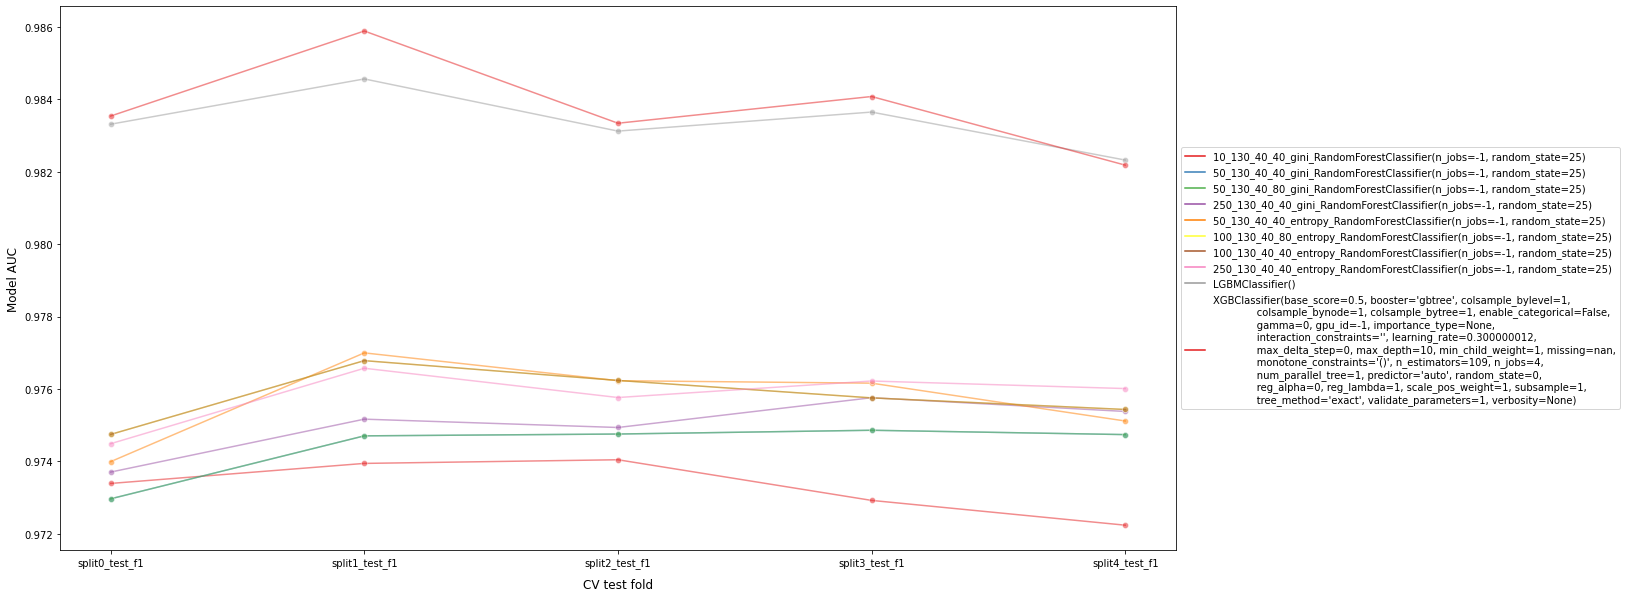

In [8]:
import seaborn as sns
model_scores = results_df.filter(regex=r"split\d*_test_f1")
print(model_scores)

fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(
    data=model_scores.transpose().iloc[:5],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Next full run

In [24]:
%%time
X_train, X_test, y_train_split, y_test_split = train_test_split(df_final_train, y_train, test_size=0.33, random_state=25)

hidden_units=150
learning_rate=0.01
hidden_layer_act='relu'
output_layer_act='sigmoid'
no_epochs=1000

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
scorers = ['f1_score']
from IPython.display import display



        


feature_names = list(df_final_train.columns)

kf = KFold(n_splits=2,random_state=25,shuffle=True)

count = 1
# test data is not needed for fitting
for train_ix, test_ix in kf.split(df_final_train, y_train):
    X_train, X_test = df_final_train[["prefer_Attach_followers","num_followers_d","prefer_Attach_followees","shortest_path","adar_index","num_followees_s","inter_followers","num_followees_d","follows_back","num_followers_s","inter_followees"]].iloc[train_ix, :],df_final_train[["prefer_Attach_followers","num_followers_d","prefer_Attach_followees","shortest_path","adar_index","num_followees_s","inter_followers","num_followees_d","follows_back","num_followers_s","inter_followees"]].iloc[test_ix, :]
    y_train_lgb, y_test_lgb = y_train.iloc[train_ix], y_train.iloc[test_ix]

    
    
    
    
    model = Sequential()

    model.add(Dense(hidden_units, activation=hidden_layer_act))
    model.add(Dense(hidden_units, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(1, activation=output_layer_act))

    sgd=optimizers.SGD(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=[f1_m,recall_m])
    
    history=model.fit(X_train, y_train_lgb, epochs=no_epochs, batch_size=len(X_train),  verbose=2)
    
    y_pred = model.predict(X_test)

    rounded = [int(round(x[0])) for x in y_pred]
    print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_lgb, rounded)))
    print('LightGBM Model f1 score: {0:0.4f}'.format(f1_score(y_test_lgb, rounded)))
    print('LightGBM Model recall score: {0:0.4f}'.format(recall_score(y_test_lgb, rounded)))



model.save("nn_model_new")
perm = PermutationImportance(model, random_state=0,scoring='neg_mean_squared_error').fit(X_train,y_train_lgb,epochs=no_epochs)
display(eli5.show_weights(perm, feature_names = X_train.columns.tolist()))

predictions = model.predict(X_test)

rounded = [int(round(x[0])) for x in predictions]



Epoch 1/1000
1/1 - 1s - loss: 11.3218 - f1_m: 0.2769 - recall_m: 0.1830 - 623ms/epoch - 623ms/step
Epoch 2/1000
1/1 - 0s - loss: 120.1093 - f1_m: 0.6674 - recall_m: 1.0000 - 186ms/epoch - 186ms/step
Epoch 3/1000
1/1 - 0s - loss: 50.6957 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - 231ms/epoch - 231ms/step
Epoch 4/1000
1/1 - 0s - loss: 8.4282 - f1_m: 0.6674 - recall_m: 1.0000 - 231ms/epoch - 231ms/step
Epoch 5/1000
1/1 - 0s - loss: 1.8363 - f1_m: 0.6674 - recall_m: 1.0000 - 197ms/epoch - 197ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.7853 - f1_m: 0.6674 - recall_m: 1.0000 - 202ms/epoch - 202ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.7587 - f1_m: 0.4911 - recall_m: 0.5931 - 212ms/epoch - 212ms/step
Epoch 8/1000
1/1 - 0s - loss: 3.3040 - f1_m: 0.6674 - recall_m: 1.0000 - 290ms/epoch - 290ms/step
Epoch 9/1000
1/1 - 0s - loss: 1.9815 - f1_m: 0.6674 - recall_m: 1.0000 - 275ms/epoch - 275ms/step
Epoch 10/1000
1/1 - 0s - loss: 1.4041 - f1_m: 0.6674 - recall_m: 1.0000 - 249ms/epoch - 249ms/step
Epoch 1

Epoch 84/1000
1/1 - 0s - loss: 0.5484 - f1_m: 0.7966 - recall_m: 0.8013 - 173ms/epoch - 173ms/step
Epoch 85/1000
1/1 - 0s - loss: 0.5450 - f1_m: 0.7707 - recall_m: 0.7138 - 171ms/epoch - 171ms/step
Epoch 86/1000
1/1 - 0s - loss: 0.5478 - f1_m: 0.7979 - recall_m: 0.8009 - 173ms/epoch - 173ms/step
Epoch 87/1000
1/1 - 0s - loss: 0.5442 - f1_m: 0.7720 - recall_m: 0.7117 - 166ms/epoch - 166ms/step
Epoch 88/1000
1/1 - 0s - loss: 0.5472 - f1_m: 0.7991 - recall_m: 0.8002 - 171ms/epoch - 171ms/step
Epoch 89/1000
1/1 - 0s - loss: 0.5434 - f1_m: 0.7717 - recall_m: 0.7095 - 165ms/epoch - 165ms/step
Epoch 90/1000
1/1 - 0s - loss: 0.5467 - f1_m: 0.8000 - recall_m: 0.8000 - 180ms/epoch - 180ms/step
Epoch 91/1000
1/1 - 0s - loss: 0.5427 - f1_m: 0.7726 - recall_m: 0.7073 - 166ms/epoch - 166ms/step
Epoch 92/1000
1/1 - 0s - loss: 0.5461 - f1_m: 0.8017 - recall_m: 0.7993 - 169ms/epoch - 169ms/step
Epoch 93/1000
1/1 - 0s - loss: 0.5418 - f1_m: 0.7728 - recall_m: 0.7062 - 163ms/epoch - 163ms/step
Epoch 94/1

1/1 - 0s - loss: 0.5219 - f1_m: 0.8048 - recall_m: 0.7780 - 149ms/epoch - 149ms/step
Epoch 167/1000
1/1 - 0s - loss: 0.5157 - f1_m: 0.7729 - recall_m: 0.6850 - 158ms/epoch - 158ms/step
Epoch 168/1000
1/1 - 0s - loss: 0.5212 - f1_m: 0.8049 - recall_m: 0.7776 - 151ms/epoch - 151ms/step
Epoch 169/1000
1/1 - 0s - loss: 0.5150 - f1_m: 0.7730 - recall_m: 0.6849 - 158ms/epoch - 158ms/step
Epoch 170/1000
1/1 - 0s - loss: 0.5206 - f1_m: 0.8052 - recall_m: 0.7776 - 154ms/epoch - 154ms/step
Epoch 171/1000
1/1 - 0s - loss: 0.5144 - f1_m: 0.7729 - recall_m: 0.6847 - 155ms/epoch - 155ms/step
Epoch 172/1000
1/1 - 0s - loss: 0.5200 - f1_m: 0.8052 - recall_m: 0.7777 - 176ms/epoch - 176ms/step
Epoch 173/1000
1/1 - 0s - loss: 0.5137 - f1_m: 0.7729 - recall_m: 0.6844 - 188ms/epoch - 188ms/step
Epoch 174/1000
1/1 - 0s - loss: 0.5195 - f1_m: 0.8051 - recall_m: 0.7774 - 152ms/epoch - 152ms/step
Epoch 175/1000
1/1 - 0s - loss: 0.5132 - f1_m: 0.7726 - recall_m: 0.6837 - 167ms/epoch - 167ms/step
Epoch 176/1000


1/1 - 0s - loss: 0.4949 - f1_m: 0.8105 - recall_m: 0.7738 - 178ms/epoch - 178ms/step
Epoch 249/1000
1/1 - 0s - loss: 0.4891 - f1_m: 0.7761 - recall_m: 0.6823 - 150ms/epoch - 150ms/step
Epoch 250/1000
1/1 - 0s - loss: 0.4984 - f1_m: 0.8122 - recall_m: 0.7804 - 154ms/epoch - 154ms/step
Epoch 251/1000
1/1 - 0s - loss: 0.4908 - f1_m: 0.7714 - recall_m: 0.6726 - 165ms/epoch - 165ms/step
Epoch 252/1000
1/1 - 0s - loss: 0.5051 - f1_m: 0.8146 - recall_m: 0.7904 - 155ms/epoch - 155ms/step
Epoch 253/1000
1/1 - 0s - loss: 0.4912 - f1_m: 0.7697 - recall_m: 0.6700 - 161ms/epoch - 161ms/step
Epoch 254/1000
1/1 - 0s - loss: 0.5038 - f1_m: 0.8142 - recall_m: 0.7888 - 158ms/epoch - 158ms/step
Epoch 255/1000
1/1 - 0s - loss: 0.4869 - f1_m: 0.7773 - recall_m: 0.6855 - 153ms/epoch - 153ms/step
Epoch 256/1000
1/1 - 0s - loss: 0.4919 - f1_m: 0.8108 - recall_m: 0.7727 - 159ms/epoch - 159ms/step
Epoch 257/1000
1/1 - 0s - loss: 0.4854 - f1_m: 0.7783 - recall_m: 0.6868 - 162ms/epoch - 162ms/step
Epoch 258/1000


1/1 - 0s - loss: 0.4729 - f1_m: 0.8199 - recall_m: 0.7870 - 170ms/epoch - 170ms/step
Epoch 331/1000
1/1 - 0s - loss: 0.4655 - f1_m: 0.7743 - recall_m: 0.6706 - 153ms/epoch - 153ms/step
Epoch 332/1000
1/1 - 0s - loss: 0.4881 - f1_m: 0.8243 - recall_m: 0.8051 - 159ms/epoch - 159ms/step
Epoch 333/1000
1/1 - 0s - loss: 0.4667 - f1_m: 0.7715 - recall_m: 0.6677 - 165ms/epoch - 165ms/step
Epoch 334/1000
1/1 - 0s - loss: 0.4833 - f1_m: 0.8229 - recall_m: 0.8002 - 148ms/epoch - 148ms/step
Epoch 335/1000
1/1 - 0s - loss: 0.4607 - f1_m: 0.7836 - recall_m: 0.6890 - 155ms/epoch - 155ms/step
Epoch 336/1000
1/1 - 0s - loss: 0.4668 - f1_m: 0.8191 - recall_m: 0.7810 - 169ms/epoch - 169ms/step
Epoch 337/1000
1/1 - 0s - loss: 0.4592 - f1_m: 0.7844 - recall_m: 0.6898 - 161ms/epoch - 161ms/step
Epoch 338/1000
1/1 - 0s - loss: 0.4688 - f1_m: 0.8207 - recall_m: 0.7870 - 157ms/epoch - 157ms/step
Epoch 339/1000
1/1 - 0s - loss: 0.4620 - f1_m: 0.7768 - recall_m: 0.6744 - 157ms/epoch - 157ms/step
Epoch 340/1000


1/1 - 0s - loss: 0.4795 - f1_m: 0.7847 - recall_m: 0.7137 - 160ms/epoch - 160ms/step
Epoch 413/1000
1/1 - 0s - loss: 0.4788 - f1_m: 0.7849 - recall_m: 0.7138 - 162ms/epoch - 162ms/step
Epoch 414/1000
1/1 - 0s - loss: 0.4781 - f1_m: 0.7848 - recall_m: 0.7135 - 158ms/epoch - 158ms/step
Epoch 415/1000
1/1 - 0s - loss: 0.4774 - f1_m: 0.7849 - recall_m: 0.7133 - 184ms/epoch - 184ms/step
Epoch 416/1000
1/1 - 0s - loss: 0.4767 - f1_m: 0.7851 - recall_m: 0.7135 - 156ms/epoch - 156ms/step
Epoch 417/1000
1/1 - 0s - loss: 0.4760 - f1_m: 0.7851 - recall_m: 0.7133 - 157ms/epoch - 157ms/step
Epoch 418/1000
1/1 - 0s - loss: 0.4753 - f1_m: 0.7853 - recall_m: 0.7136 - 150ms/epoch - 150ms/step
Epoch 419/1000
1/1 - 0s - loss: 0.4746 - f1_m: 0.7854 - recall_m: 0.7136 - 152ms/epoch - 152ms/step
Epoch 420/1000
1/1 - 0s - loss: 0.4739 - f1_m: 0.7856 - recall_m: 0.7139 - 151ms/epoch - 151ms/step
Epoch 421/1000
1/1 - 0s - loss: 0.4732 - f1_m: 0.7857 - recall_m: 0.7140 - 154ms/epoch - 154ms/step
Epoch 422/1000


1/1 - 0s - loss: 0.4371 - f1_m: 0.7876 - recall_m: 0.7009 - 144ms/epoch - 144ms/step
Epoch 495/1000
1/1 - 0s - loss: 0.4492 - f1_m: 0.8086 - recall_m: 0.7661 - 158ms/epoch - 158ms/step
Epoch 496/1000
1/1 - 0s - loss: 0.4363 - f1_m: 0.7879 - recall_m: 0.7012 - 148ms/epoch - 148ms/step
Epoch 497/1000
1/1 - 0s - loss: 0.4483 - f1_m: 0.8089 - recall_m: 0.7665 - 157ms/epoch - 157ms/step
Epoch 498/1000
1/1 - 0s - loss: 0.4352 - f1_m: 0.7884 - recall_m: 0.7020 - 154ms/epoch - 154ms/step
Epoch 499/1000
1/1 - 0s - loss: 0.4471 - f1_m: 0.8091 - recall_m: 0.7667 - 149ms/epoch - 149ms/step
Epoch 500/1000
1/1 - 0s - loss: 0.4346 - f1_m: 0.7885 - recall_m: 0.7018 - 154ms/epoch - 154ms/step
Epoch 501/1000
1/1 - 0s - loss: 0.4470 - f1_m: 0.8094 - recall_m: 0.7677 - 150ms/epoch - 150ms/step
Epoch 502/1000
1/1 - 0s - loss: 0.4338 - f1_m: 0.7887 - recall_m: 0.7019 - 159ms/epoch - 159ms/step
Epoch 503/1000
1/1 - 0s - loss: 0.4463 - f1_m: 0.8098 - recall_m: 0.7683 - 150ms/epoch - 150ms/step
Epoch 504/1000


1/1 - 0s - loss: 0.4091 - f1_m: 0.8018 - recall_m: 0.7200 - 168ms/epoch - 168ms/step
Epoch 577/1000
1/1 - 0s - loss: 0.4229 - f1_m: 0.8216 - recall_m: 0.7891 - 165ms/epoch - 165ms/step
Epoch 578/1000
1/1 - 0s - loss: 0.4084 - f1_m: 0.8021 - recall_m: 0.7205 - 160ms/epoch - 160ms/step
Epoch 579/1000
1/1 - 0s - loss: 0.4217 - f1_m: 0.8219 - recall_m: 0.7891 - 164ms/epoch - 164ms/step
Epoch 580/1000
1/1 - 0s - loss: 0.4078 - f1_m: 0.8024 - recall_m: 0.7210 - 171ms/epoch - 171ms/step
Epoch 581/1000
1/1 - 0s - loss: 0.4216 - f1_m: 0.8221 - recall_m: 0.7898 - 166ms/epoch - 166ms/step
Epoch 582/1000
1/1 - 0s - loss: 0.4074 - f1_m: 0.8027 - recall_m: 0.7212 - 161ms/epoch - 161ms/step
Epoch 583/1000
1/1 - 0s - loss: 0.4209 - f1_m: 0.8225 - recall_m: 0.7903 - 163ms/epoch - 163ms/step
Epoch 584/1000
1/1 - 0s - loss: 0.4067 - f1_m: 0.8033 - recall_m: 0.7224 - 166ms/epoch - 166ms/step
Epoch 585/1000
1/1 - 0s - loss: 0.4205 - f1_m: 0.8230 - recall_m: 0.7912 - 170ms/epoch - 170ms/step
Epoch 586/1000


1/1 - 0s - loss: 0.3919 - f1_m: 0.8144 - recall_m: 0.7383 - 243ms/epoch - 243ms/step
Epoch 659/1000
1/1 - 0s - loss: 0.4121 - f1_m: 0.8343 - recall_m: 0.8154 - 225ms/epoch - 225ms/step
Epoch 660/1000
1/1 - 0s - loss: 0.3912 - f1_m: 0.8154 - recall_m: 0.7401 - 241ms/epoch - 241ms/step
Epoch 661/1000
1/1 - 0s - loss: 0.4094 - f1_m: 0.8342 - recall_m: 0.8139 - 223ms/epoch - 223ms/step
Epoch 662/1000
1/1 - 0s - loss: 0.3912 - f1_m: 0.8153 - recall_m: 0.7398 - 223ms/epoch - 223ms/step
Epoch 663/1000
1/1 - 0s - loss: 0.4121 - f1_m: 0.8348 - recall_m: 0.8167 - 228ms/epoch - 228ms/step
Epoch 664/1000
1/1 - 0s - loss: 0.3907 - f1_m: 0.8159 - recall_m: 0.7408 - 238ms/epoch - 238ms/step
Epoch 665/1000
1/1 - 0s - loss: 0.4092 - f1_m: 0.8350 - recall_m: 0.8153 - 223ms/epoch - 223ms/step
Epoch 666/1000
1/1 - 0s - loss: 0.3904 - f1_m: 0.8160 - recall_m: 0.7410 - 168ms/epoch - 168ms/step
Epoch 667/1000
1/1 - 0s - loss: 0.4107 - f1_m: 0.8351 - recall_m: 0.8169 - 175ms/epoch - 175ms/step
Epoch 668/1000


1/1 - 0s - loss: 0.3794 - f1_m: 0.8243 - recall_m: 0.7546 - 235ms/epoch - 235ms/step
Epoch 741/1000
1/1 - 0s - loss: 0.4210 - f1_m: 0.8468 - recall_m: 0.8500 - 178ms/epoch - 178ms/step
Epoch 742/1000
1/1 - 0s - loss: 0.3797 - f1_m: 0.8309 - recall_m: 0.7684 - 176ms/epoch - 176ms/step
Epoch 743/1000
1/1 - 0s - loss: 0.3832 - f1_m: 0.8406 - recall_m: 0.8144 - 172ms/epoch - 172ms/step
Epoch 744/1000
1/1 - 0s - loss: 0.3776 - f1_m: 0.8257 - recall_m: 0.7583 - 194ms/epoch - 194ms/step
Epoch 745/1000
1/1 - 0s - loss: 0.4076 - f1_m: 0.8460 - recall_m: 0.8425 - 185ms/epoch - 185ms/step
Epoch 746/1000
1/1 - 0s - loss: 0.3802 - f1_m: 0.8281 - recall_m: 0.7592 - 193ms/epoch - 193ms/step
Epoch 747/1000
1/1 - 0s - loss: 0.3949 - f1_m: 0.8443 - recall_m: 0.8293 - 205ms/epoch - 205ms/step
Epoch 748/1000
1/1 - 0s - loss: 0.3788 - f1_m: 0.8254 - recall_m: 0.7557 - 256ms/epoch - 256ms/step
Epoch 749/1000
1/1 - 0s - loss: 0.4091 - f1_m: 0.8464 - recall_m: 0.8434 - 256ms/epoch - 256ms/step
Epoch 750/1000


1/1 - 0s - loss: 0.3640 - f1_m: 0.8400 - recall_m: 0.7860 - 240ms/epoch - 240ms/step
Epoch 823/1000
1/1 - 0s - loss: 0.3691 - f1_m: 0.8503 - recall_m: 0.8316 - 230ms/epoch - 230ms/step
Epoch 824/1000
1/1 - 0s - loss: 0.3715 - f1_m: 0.8356 - recall_m: 0.7699 - 243ms/epoch - 243ms/step
Epoch 825/1000
1/1 - 0s - loss: 0.4234 - f1_m: 0.8542 - recall_m: 0.8671 - 250ms/epoch - 250ms/step
Epoch 826/1000
1/1 - 0s - loss: 0.3694 - f1_m: 0.8393 - recall_m: 0.7800 - 247ms/epoch - 247ms/step
Epoch 827/1000
1/1 - 0s - loss: 0.3731 - f1_m: 0.8505 - recall_m: 0.8323 - 226ms/epoch - 226ms/step
Epoch 828/1000
1/1 - 0s - loss: 0.3661 - f1_m: 0.8381 - recall_m: 0.7778 - 254ms/epoch - 254ms/step
Epoch 829/1000
1/1 - 0s - loss: 0.3842 - f1_m: 0.8532 - recall_m: 0.8488 - 238ms/epoch - 238ms/step
Epoch 830/1000
1/1 - 0s - loss: 0.3714 - f1_m: 0.8366 - recall_m: 0.7699 - 231ms/epoch - 231ms/step
Epoch 831/1000
1/1 - 0s - loss: 0.4017 - f1_m: 0.8539 - recall_m: 0.8579 - 211ms/epoch - 211ms/step
Epoch 832/1000


1/1 - 0s - loss: 0.3562 - f1_m: 0.8452 - recall_m: 0.7864 - 165ms/epoch - 165ms/step
Epoch 905/1000
1/1 - 0s - loss: 0.3718 - f1_m: 0.8593 - recall_m: 0.8588 - 171ms/epoch - 171ms/step
Epoch 906/1000
1/1 - 0s - loss: 0.3693 - f1_m: 0.8382 - recall_m: 0.7644 - 170ms/epoch - 170ms/step
Epoch 907/1000
1/1 - 0s - loss: 0.4374 - f1_m: 0.8581 - recall_m: 0.8866 - 173ms/epoch - 173ms/step
Epoch 908/1000
1/1 - 0s - loss: 0.3689 - f1_m: 0.8496 - recall_m: 0.8093 - 166ms/epoch - 166ms/step
Epoch 909/1000
1/1 - 0s - loss: 0.3589 - f1_m: 0.8543 - recall_m: 0.8298 - 165ms/epoch - 165ms/step
Epoch 910/1000
1/1 - 0s - loss: 0.3534 - f1_m: 0.8496 - recall_m: 0.8091 - 167ms/epoch - 167ms/step
Epoch 911/1000
1/1 - 0s - loss: 0.3509 - f1_m: 0.8543 - recall_m: 0.8267 - 165ms/epoch - 165ms/step
Epoch 912/1000
1/1 - 0s - loss: 0.3494 - f1_m: 0.8498 - recall_m: 0.8074 - 166ms/epoch - 166ms/step
Epoch 913/1000
1/1 - 0s - loss: 0.3507 - f1_m: 0.8570 - recall_m: 0.8366 - 172ms/epoch - 172ms/step
Epoch 914/1000


1/1 - 0s - loss: 0.3609 - f1_m: 0.8579 - recall_m: 0.8488 - 220ms/epoch - 220ms/step
Epoch 987/1000
1/1 - 0s - loss: 0.3522 - f1_m: 0.8518 - recall_m: 0.8101 - 161ms/epoch - 161ms/step
Epoch 988/1000
1/1 - 0s - loss: 0.3524 - f1_m: 0.8577 - recall_m: 0.8452 - 170ms/epoch - 170ms/step
Epoch 989/1000
1/1 - 0s - loss: 0.3528 - f1_m: 0.8517 - recall_m: 0.8054 - 172ms/epoch - 172ms/step
Epoch 990/1000
1/1 - 0s - loss: 0.3656 - f1_m: 0.8594 - recall_m: 0.8583 - 170ms/epoch - 170ms/step
Epoch 991/1000
1/1 - 0s - loss: 0.3666 - f1_m: 0.8429 - recall_m: 0.7773 - 160ms/epoch - 160ms/step
Epoch 992/1000
1/1 - 0s - loss: 0.3965 - f1_m: 0.8609 - recall_m: 0.8742 - 166ms/epoch - 166ms/step
Epoch 993/1000
1/1 - 0s - loss: 0.3605 - f1_m: 0.8425 - recall_m: 0.7824 - 172ms/epoch - 172ms/step
Epoch 994/1000
1/1 - 0s - loss: 0.3573 - f1_m: 0.8584 - recall_m: 0.8483 - 160ms/epoch - 160ms/step
Epoch 995/1000
1/1 - 0s - loss: 0.3498 - f1_m: 0.8528 - recall_m: 0.8128 - 163ms/epoch - 163ms/step
Epoch 996/1000


Epoch 67/1000
1/1 - 0s - loss: 0.5889 - f1_m: 0.7398 - recall_m: 0.9149 - 204ms/epoch - 204ms/step
Epoch 68/1000
1/1 - 0s - loss: 0.5879 - f1_m: 0.7415 - recall_m: 0.9129 - 172ms/epoch - 172ms/step
Epoch 69/1000
1/1 - 0s - loss: 0.5869 - f1_m: 0.7439 - recall_m: 0.9120 - 171ms/epoch - 171ms/step
Epoch 70/1000
1/1 - 0s - loss: 0.5860 - f1_m: 0.7468 - recall_m: 0.9103 - 203ms/epoch - 203ms/step
Epoch 71/1000
1/1 - 0s - loss: 0.5851 - f1_m: 0.7506 - recall_m: 0.9083 - 193ms/epoch - 193ms/step
Epoch 72/1000
1/1 - 0s - loss: 0.5842 - f1_m: 0.7524 - recall_m: 0.9066 - 165ms/epoch - 165ms/step
Epoch 73/1000
1/1 - 0s - loss: 0.5834 - f1_m: 0.7546 - recall_m: 0.9045 - 164ms/epoch - 164ms/step
Epoch 74/1000
1/1 - 0s - loss: 0.5826 - f1_m: 0.7576 - recall_m: 0.9031 - 157ms/epoch - 157ms/step
Epoch 75/1000
1/1 - 0s - loss: 0.5817 - f1_m: 0.7605 - recall_m: 0.9015 - 172ms/epoch - 172ms/step
Epoch 76/1000
1/1 - 0s - loss: 0.5809 - f1_m: 0.7654 - recall_m: 0.8994 - 176ms/epoch - 176ms/step
Epoch 77/1

Epoch 150/1000
1/1 - 0s - loss: 0.5390 - f1_m: 0.8166 - recall_m: 0.8350 - 161ms/epoch - 161ms/step
Epoch 151/1000
1/1 - 0s - loss: 0.5387 - f1_m: 0.8167 - recall_m: 0.8343 - 169ms/epoch - 169ms/step
Epoch 152/1000
1/1 - 0s - loss: 0.5383 - f1_m: 0.8170 - recall_m: 0.8340 - 162ms/epoch - 162ms/step
Epoch 153/1000
1/1 - 0s - loss: 0.5380 - f1_m: 0.8172 - recall_m: 0.8334 - 161ms/epoch - 161ms/step
Epoch 154/1000
1/1 - 0s - loss: 0.5376 - f1_m: 0.8175 - recall_m: 0.8332 - 150ms/epoch - 150ms/step
Epoch 155/1000
1/1 - 0s - loss: 0.5373 - f1_m: 0.8175 - recall_m: 0.8325 - 160ms/epoch - 160ms/step
Epoch 156/1000
1/1 - 0s - loss: 0.5369 - f1_m: 0.8178 - recall_m: 0.8325 - 157ms/epoch - 157ms/step
Epoch 157/1000
1/1 - 0s - loss: 0.5366 - f1_m: 0.8178 - recall_m: 0.8315 - 151ms/epoch - 151ms/step
Epoch 158/1000
1/1 - 0s - loss: 0.5362 - f1_m: 0.8181 - recall_m: 0.8320 - 160ms/epoch - 160ms/step
Epoch 159/1000
1/1 - 0s - loss: 0.5359 - f1_m: 0.8180 - recall_m: 0.8308 - 166ms/epoch - 166ms/step


Epoch 232/1000
1/1 - 0s - loss: 0.5150 - f1_m: 0.8230 - recall_m: 0.8045 - 156ms/epoch - 156ms/step
Epoch 233/1000
1/1 - 0s - loss: 0.5163 - f1_m: 0.8257 - recall_m: 0.8258 - 153ms/epoch - 153ms/step
Epoch 234/1000
1/1 - 0s - loss: 0.5182 - f1_m: 0.8212 - recall_m: 0.7936 - 147ms/epoch - 147ms/step
Epoch 235/1000
1/1 - 0s - loss: 0.5253 - f1_m: 0.8248 - recall_m: 0.8364 - 150ms/epoch - 150ms/step
Epoch 236/1000
1/1 - 0s - loss: 0.5235 - f1_m: 0.8180 - recall_m: 0.7794 - 160ms/epoch - 160ms/step
Epoch 237/1000
1/1 - 0s - loss: 0.5378 - f1_m: 0.8246 - recall_m: 0.8437 - 165ms/epoch - 165ms/step
Epoch 238/1000
1/1 - 0s - loss: 0.5229 - f1_m: 0.8171 - recall_m: 0.7775 - 152ms/epoch - 152ms/step
Epoch 239/1000
1/1 - 0s - loss: 0.5348 - f1_m: 0.8245 - recall_m: 0.8413 - 162ms/epoch - 162ms/step
Epoch 240/1000
1/1 - 0s - loss: 0.5217 - f1_m: 0.8169 - recall_m: 0.7775 - 153ms/epoch - 153ms/step
Epoch 241/1000
1/1 - 0s - loss: 0.5314 - f1_m: 0.8247 - recall_m: 0.8388 - 165ms/epoch - 165ms/step


Epoch 314/1000
1/1 - 0s - loss: 0.5039 - f1_m: 0.8166 - recall_m: 0.7684 - 157ms/epoch - 157ms/step
Epoch 315/1000
1/1 - 0s - loss: 0.5078 - f1_m: 0.8267 - recall_m: 0.8233 - 150ms/epoch - 150ms/step
Epoch 316/1000
1/1 - 0s - loss: 0.5035 - f1_m: 0.8168 - recall_m: 0.7684 - 147ms/epoch - 147ms/step
Epoch 317/1000
1/1 - 0s - loss: 0.5074 - f1_m: 0.8268 - recall_m: 0.8232 - 155ms/epoch - 155ms/step
Epoch 318/1000
1/1 - 0s - loss: 0.5031 - f1_m: 0.8166 - recall_m: 0.7679 - 156ms/epoch - 156ms/step
Epoch 319/1000
1/1 - 0s - loss: 0.5070 - f1_m: 0.8266 - recall_m: 0.8228 - 158ms/epoch - 158ms/step
Epoch 320/1000
1/1 - 0s - loss: 0.5028 - f1_m: 0.8167 - recall_m: 0.7679 - 156ms/epoch - 156ms/step
Epoch 321/1000
1/1 - 0s - loss: 0.5068 - f1_m: 0.8267 - recall_m: 0.8228 - 160ms/epoch - 160ms/step
Epoch 322/1000
1/1 - 0s - loss: 0.5025 - f1_m: 0.8167 - recall_m: 0.7676 - 153ms/epoch - 153ms/step
Epoch 323/1000
1/1 - 0s - loss: 0.5068 - f1_m: 0.8269 - recall_m: 0.8231 - 148ms/epoch - 148ms/step


Epoch 396/1000
1/1 - 0s - loss: 0.4939 - f1_m: 0.8151 - recall_m: 0.7541 - 167ms/epoch - 167ms/step
Epoch 397/1000
1/1 - 0s - loss: 0.5007 - f1_m: 0.8299 - recall_m: 0.8276 - 171ms/epoch - 171ms/step
Epoch 398/1000
1/1 - 0s - loss: 0.4927 - f1_m: 0.8154 - recall_m: 0.7552 - 160ms/epoch - 160ms/step
Epoch 399/1000
1/1 - 0s - loss: 0.4969 - f1_m: 0.8301 - recall_m: 0.8252 - 164ms/epoch - 164ms/step
Epoch 400/1000
1/1 - 0s - loss: 0.4896 - f1_m: 0.8172 - recall_m: 0.7609 - 169ms/epoch - 169ms/step
Epoch 401/1000
1/1 - 0s - loss: 0.4915 - f1_m: 0.8299 - recall_m: 0.8212 - 162ms/epoch - 162ms/step
Epoch 402/1000
1/1 - 0s - loss: 0.4863 - f1_m: 0.8203 - recall_m: 0.7690 - 165ms/epoch - 165ms/step
Epoch 403/1000
1/1 - 0s - loss: 0.4875 - f1_m: 0.8299 - recall_m: 0.8179 - 170ms/epoch - 170ms/step
Epoch 404/1000
1/1 - 0s - loss: 0.4846 - f1_m: 0.8211 - recall_m: 0.7720 - 164ms/epoch - 164ms/step
Epoch 405/1000
1/1 - 0s - loss: 0.4859 - f1_m: 0.8301 - recall_m: 0.8170 - 162ms/epoch - 162ms/step


Epoch 478/1000
1/1 - 0s - loss: 0.4832 - f1_m: 0.8141 - recall_m: 0.7471 - 163ms/epoch - 163ms/step
Epoch 479/1000
1/1 - 0s - loss: 0.4776 - f1_m: 0.8340 - recall_m: 0.8237 - 163ms/epoch - 163ms/step
Epoch 480/1000
1/1 - 0s - loss: 0.4713 - f1_m: 0.8256 - recall_m: 0.7780 - 158ms/epoch - 158ms/step
Epoch 481/1000
1/1 - 0s - loss: 0.4689 - f1_m: 0.8334 - recall_m: 0.8130 - 159ms/epoch - 159ms/step
Epoch 482/1000
1/1 - 0s - loss: 0.4672 - f1_m: 0.8297 - recall_m: 0.7911 - 160ms/epoch - 160ms/step
Epoch 483/1000
1/1 - 0s - loss: 0.4661 - f1_m: 0.8336 - recall_m: 0.8114 - 169ms/epoch - 169ms/step
Epoch 484/1000
1/1 - 0s - loss: 0.4655 - f1_m: 0.8306 - recall_m: 0.7927 - 188ms/epoch - 188ms/step
Epoch 485/1000
1/1 - 0s - loss: 0.4657 - f1_m: 0.8345 - recall_m: 0.8148 - 161ms/epoch - 161ms/step
Epoch 486/1000
1/1 - 0s - loss: 0.4673 - f1_m: 0.8289 - recall_m: 0.7835 - 163ms/epoch - 163ms/step
Epoch 487/1000
1/1 - 0s - loss: 0.4719 - f1_m: 0.8355 - recall_m: 0.8250 - 165ms/epoch - 165ms/step


Epoch 560/1000
1/1 - 0s - loss: 0.4660 - f1_m: 0.8247 - recall_m: 0.7620 - 171ms/epoch - 171ms/step
Epoch 561/1000
1/1 - 0s - loss: 0.4796 - f1_m: 0.8389 - recall_m: 0.8397 - 179ms/epoch - 179ms/step
Epoch 562/1000
1/1 - 0s - loss: 0.4936 - f1_m: 0.7915 - recall_m: 0.6947 - 184ms/epoch - 184ms/step
Epoch 563/1000
1/1 - 0s - loss: 0.4937 - f1_m: 0.8380 - recall_m: 0.8444 - 174ms/epoch - 174ms/step
Epoch 564/1000
1/1 - 0s - loss: 0.4843 - f1_m: 0.8018 - recall_m: 0.7155 - 173ms/epoch - 173ms/step
Epoch 565/1000
1/1 - 0s - loss: 0.4664 - f1_m: 0.8393 - recall_m: 0.8326 - 179ms/epoch - 179ms/step
Epoch 566/1000
1/1 - 0s - loss: 0.4610 - f1_m: 0.8279 - recall_m: 0.7752 - 173ms/epoch - 173ms/step
Epoch 567/1000
1/1 - 0s - loss: 0.4553 - f1_m: 0.8391 - recall_m: 0.8207 - 174ms/epoch - 174ms/step
Epoch 568/1000
1/1 - 0s - loss: 0.4533 - f1_m: 0.8352 - recall_m: 0.7965 - 173ms/epoch - 173ms/step
Epoch 569/1000
1/1 - 0s - loss: 0.4517 - f1_m: 0.8387 - recall_m: 0.8176 - 164ms/epoch - 164ms/step


Epoch 642/1000
1/1 - 0s - loss: 0.5002 - f1_m: 0.7568 - recall_m: 0.6365 - 160ms/epoch - 160ms/step
Epoch 643/1000
1/1 - 0s - loss: 0.4851 - f1_m: 0.8419 - recall_m: 0.8507 - 154ms/epoch - 154ms/step
Epoch 644/1000
1/1 - 0s - loss: 0.4798 - f1_m: 0.7917 - recall_m: 0.6948 - 148ms/epoch - 148ms/step
Epoch 645/1000
1/1 - 0s - loss: 0.4509 - f1_m: 0.8436 - recall_m: 0.8346 - 150ms/epoch - 150ms/step
Epoch 646/1000
1/1 - 0s - loss: 0.4453 - f1_m: 0.8362 - recall_m: 0.7923 - 161ms/epoch - 161ms/step
Epoch 647/1000
1/1 - 0s - loss: 0.4410 - f1_m: 0.8430 - recall_m: 0.8216 - 154ms/epoch - 154ms/step
Epoch 648/1000
1/1 - 0s - loss: 0.4390 - f1_m: 0.8419 - recall_m: 0.8091 - 156ms/epoch - 156ms/step
Epoch 649/1000
1/1 - 0s - loss: 0.4373 - f1_m: 0.8433 - recall_m: 0.8206 - 148ms/epoch - 148ms/step
Epoch 650/1000
1/1 - 0s - loss: 0.4362 - f1_m: 0.8425 - recall_m: 0.8090 - 149ms/epoch - 149ms/step
Epoch 651/1000
1/1 - 0s - loss: 0.4358 - f1_m: 0.8435 - recall_m: 0.8236 - 165ms/epoch - 165ms/step


Epoch 724/1000
1/1 - 0s - loss: 0.4258 - f1_m: 0.8453 - recall_m: 0.8083 - 148ms/epoch - 148ms/step
Epoch 725/1000
1/1 - 0s - loss: 0.4259 - f1_m: 0.8475 - recall_m: 0.8313 - 167ms/epoch - 167ms/step
Epoch 726/1000
1/1 - 0s - loss: 0.4310 - f1_m: 0.8391 - recall_m: 0.7886 - 152ms/epoch - 152ms/step
Epoch 727/1000
1/1 - 0s - loss: 0.4395 - f1_m: 0.8475 - recall_m: 0.8430 - 160ms/epoch - 160ms/step
Epoch 728/1000
1/1 - 0s - loss: 0.4712 - f1_m: 0.7942 - recall_m: 0.6942 - 153ms/epoch - 153ms/step
Epoch 729/1000
1/1 - 0s - loss: 0.4747 - f1_m: 0.8456 - recall_m: 0.8559 - 148ms/epoch - 148ms/step
Epoch 730/1000
1/1 - 0s - loss: 0.4841 - f1_m: 0.7631 - recall_m: 0.6454 - 151ms/epoch - 151ms/step
Epoch 731/1000
1/1 - 0s - loss: 0.4406 - f1_m: 0.8477 - recall_m: 0.8426 - 165ms/epoch - 165ms/step
Epoch 732/1000
1/1 - 0s - loss: 0.4360 - f1_m: 0.8373 - recall_m: 0.7868 - 155ms/epoch - 155ms/step
Epoch 733/1000
1/1 - 0s - loss: 0.4284 - f1_m: 0.8478 - recall_m: 0.8298 - 159ms/epoch - 159ms/step


Epoch 806/1000
1/1 - 0s - loss: 0.4141 - f1_m: 0.8489 - recall_m: 0.8124 - 162ms/epoch - 162ms/step
Epoch 807/1000
1/1 - 0s - loss: 0.4138 - f1_m: 0.8512 - recall_m: 0.8362 - 157ms/epoch - 157ms/step
Epoch 808/1000
1/1 - 0s - loss: 0.4184 - f1_m: 0.8431 - recall_m: 0.7933 - 173ms/epoch - 173ms/step
Epoch 809/1000
1/1 - 0s - loss: 0.4252 - f1_m: 0.8518 - recall_m: 0.8472 - 159ms/epoch - 159ms/step
Epoch 810/1000
1/1 - 0s - loss: 0.4583 - f1_m: 0.7990 - recall_m: 0.7006 - 145ms/epoch - 145ms/step
Epoch 811/1000
1/1 - 0s - loss: 0.4618 - f1_m: 0.8498 - recall_m: 0.8605 - 167ms/epoch - 167ms/step
Epoch 812/1000
1/1 - 0s - loss: 0.4820 - f1_m: 0.7471 - recall_m: 0.6208 - 155ms/epoch - 155ms/step
Epoch 813/1000
1/1 - 0s - loss: 0.4257 - f1_m: 0.8520 - recall_m: 0.8447 - 152ms/epoch - 152ms/step
Epoch 814/1000
1/1 - 0s - loss: 0.4217 - f1_m: 0.8433 - recall_m: 0.7989 - 150ms/epoch - 150ms/step
Epoch 815/1000
1/1 - 0s - loss: 0.4157 - f1_m: 0.8520 - recall_m: 0.8343 - 155ms/epoch - 155ms/step


Epoch 888/1000
1/1 - 0s - loss: 0.4719 - f1_m: 0.7526 - recall_m: 0.6266 - 156ms/epoch - 156ms/step
Epoch 889/1000
1/1 - 0s - loss: 0.4298 - f1_m: 0.8534 - recall_m: 0.8578 - 153ms/epoch - 153ms/step
Epoch 890/1000
1/1 - 0s - loss: 0.4423 - f1_m: 0.8076 - recall_m: 0.7168 - 154ms/epoch - 154ms/step
Epoch 891/1000
1/1 - 0s - loss: 0.4100 - f1_m: 0.8550 - recall_m: 0.8442 - 173ms/epoch - 173ms/step
Epoch 892/1000
1/1 - 0s - loss: 0.4072 - f1_m: 0.8488 - recall_m: 0.8090 - 154ms/epoch - 154ms/step
Epoch 893/1000
1/1 - 0s - loss: 0.4030 - f1_m: 0.8555 - recall_m: 0.8388 - 154ms/epoch - 154ms/step
Epoch 894/1000
1/1 - 0s - loss: 0.4017 - f1_m: 0.8521 - recall_m: 0.8162 - 161ms/epoch - 161ms/step
Epoch 895/1000
1/1 - 0s - loss: 0.4010 - f1_m: 0.8555 - recall_m: 0.8408 - 158ms/epoch - 158ms/step
Epoch 896/1000
1/1 - 0s - loss: 0.4052 - f1_m: 0.8475 - recall_m: 0.7991 - 164ms/epoch - 164ms/step
Epoch 897/1000
1/1 - 0s - loss: 0.4121 - f1_m: 0.8549 - recall_m: 0.8507 - 175ms/epoch - 175ms/step


Epoch 970/1000
1/1 - 0s - loss: 0.4219 - f1_m: 0.8226 - recall_m: 0.7411 - 174ms/epoch - 174ms/step
Epoch 971/1000
1/1 - 0s - loss: 0.4324 - f1_m: 0.8556 - recall_m: 0.8652 - 177ms/epoch - 177ms/step
Epoch 972/1000
1/1 - 0s - loss: 0.4853 - f1_m: 0.6968 - recall_m: 0.5501 - 171ms/epoch - 171ms/step
Epoch 973/1000
1/1 - 0s - loss: 0.4012 - f1_m: 0.8581 - recall_m: 0.8505 - 170ms/epoch - 170ms/step
Epoch 974/1000
1/1 - 0s - loss: 0.3985 - f1_m: 0.8491 - recall_m: 0.8051 - 181ms/epoch - 181ms/step
Epoch 975/1000
1/1 - 0s - loss: 0.3929 - f1_m: 0.8583 - recall_m: 0.8436 - 159ms/epoch - 159ms/step
Epoch 976/1000
1/1 - 0s - loss: 0.3916 - f1_m: 0.8541 - recall_m: 0.8165 - 162ms/epoch - 162ms/step
Epoch 977/1000
1/1 - 0s - loss: 0.3906 - f1_m: 0.8587 - recall_m: 0.8457 - 149ms/epoch - 149ms/step
Epoch 978/1000
1/1 - 0s - loss: 0.3958 - f1_m: 0.8488 - recall_m: 0.7983 - 157ms/epoch - 157ms/step
Epoch 979/1000
1/1 - 0s - loss: 0.4033 - f1_m: 0.8582 - recall_m: 0.8565 - 163ms/epoch - 163ms/step


INFO:tensorflow:Assets written to: nn_model_new\assets


1563/1563 [==============================] - 1s 804us/step


1563/1563 [==============================] - 1s 794us/step
Wall time: 7min 44s


1563/1563 [==============================] - 1s 815us/step
0.8555456082761366


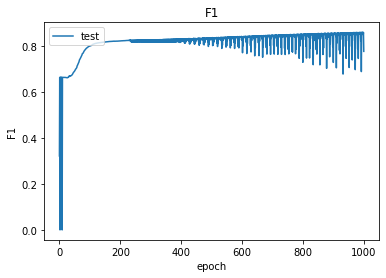

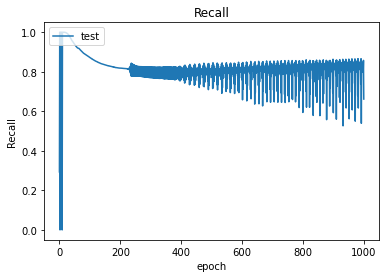

In [25]:
# f1_m(y_test_split, rounded)
# recall_m(y_test_split, rounded)
predictions = model.predict(X_test)

rounded = [int(round(x[0])) for x in predictions]

print(f1_score(y_test_lgb, rounded, average="binary"))
recall_score(y_test_lgb, rounded, average="binary")

plt.plot(history.history['f1_m'])
#plt.plot(history.history['val_acc'])
plt.title('F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['recall_m'])
#plt.plot(history.history['val_acc'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

## NN small sample

In [73]:
%%time
X_train, X_test, y_train_split, y_test_split = train_test_split(df_final_train, y_train, test_size=0.33, random_state=25)

hidden_units=150
learning_rate=0.01
hidden_layer_act='relu'
output_layer_act='sigmoid'
no_epochs=30

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
scorers = ['f1_score']
from IPython.display import display


clm=[
 'shortest_path',
 'follows_back',
 'same_comp',
 'weight_f4',
 'prefer_Attach_followers'
]

        


feature_names = list(df_final_train[clm].columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)

count = 1
# test data is not needed for fitting
for train_ix, test_ix in kf.split(df_final_train, y_train):
    X_train, X_test = df_final_train[clm].iloc[train_ix, :],df_final_train[clm].iloc[test_ix, :]
    y_train_lgb, y_test_lgb = y_train.iloc[train_ix], y_train.iloc[test_ix]

    
    model = Sequential()

    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(1, activation=output_layer_act))

    sgd=optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
    
    model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=[MeanSquaredError(),AUC(),f1_m,recall_m])
    
    history=model.fit(X_train, y_train_lgb, epochs=no_epochs, batch_size=50,  verbose=2)
    
    y_pred = model.predict(X_test)

    rounded = [int(round(x[0])) for x in y_pred]
    print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_lgb, rounded)))
    print('LightGBM Model f1 score: {0:0.4f}'.format(f1_score(y_test_lgb, rounded)))
    print('LightGBM Model recall score: {0:0.4f}'.format(recall_score(y_test_lgb, rounded)))



model.save("nn_model_new")
perm = PermutationImportance(model, random_state=0,scoring='neg_mean_squared_error').fit(X_train,y_train_lgb,epochs=no_epochs)
display(eli5.show_weights(perm, feature_names = X_train.columns.tolist()))

predictions = model.predict(X_test)

rounded = [int(round(x[0])) for x in predictions]



Epoch 1/30
1600/1600 - 3s - loss: 0.5213 - mean_squared_error: 0.0827 - auc_37: 0.9478 - f1_m: 0.8880 - recall_m: 0.8768 - 3s/epoch - 2ms/step
Epoch 2/30
1600/1600 - 2s - loss: 0.3078 - mean_squared_error: 0.0548 - auc_37: 0.9734 - f1_m: 0.9259 - recall_m: 0.9102 - 2s/epoch - 1ms/step
Epoch 3/30
1600/1600 - 2s - loss: 0.1488 - mean_squared_error: 0.0393 - auc_37: 0.9856 - f1_m: 0.9453 - recall_m: 0.9242 - 2s/epoch - 1ms/step
Epoch 4/30
1600/1600 - 2s - loss: 0.1700 - mean_squared_error: 0.0411 - auc_37: 0.9844 - f1_m: 0.9434 - recall_m: 0.9242 - 2s/epoch - 1ms/step
Epoch 5/30
1600/1600 - 2s - loss: 0.2283 - mean_squared_error: 0.0461 - auc_37: 0.9804 - f1_m: 0.9376 - recall_m: 0.9214 - 2s/epoch - 1ms/step
Epoch 6/30
1600/1600 - 2s - loss: 0.1639 - mean_squared_error: 0.0401 - auc_37: 0.9855 - f1_m: 0.9435 - recall_m: 0.9206 - 2s/epoch - 1ms/step
Epoch 7/30
1600/1600 - 2s - loss: 0.2021 - mean_squared_error: 0.0404 - auc_37: 0.9850 - f1_m: 0.9442 - recall_m: 0.9253 - 2s/epoch - 1ms/step

Epoch 27/30
1601/1601 - 2s - loss: 0.1112 - mean_squared_error: 0.0321 - auc_38: 0.9907 - f1_m: 0.9543 - recall_m: 0.9358 - 2s/epoch - 1ms/step
Epoch 28/30
1601/1601 - 2s - loss: 0.1087 - mean_squared_error: 0.0317 - auc_38: 0.9911 - f1_m: 0.9553 - recall_m: 0.9364 - 2s/epoch - 1ms/step
Epoch 29/30
1601/1601 - 2s - loss: 0.1082 - mean_squared_error: 0.0316 - auc_38: 0.9912 - f1_m: 0.9554 - recall_m: 0.9365 - 2s/epoch - 1ms/step
Epoch 30/30
1601/1601 - 2s - loss: 0.1250 - mean_squared_error: 0.0331 - auc_38: 0.9899 - f1_m: 0.9533 - recall_m: 0.9355 - 2s/epoch - 1ms/step
625/625 [==============================] - 1s 888us/step
LightGBM Model accuracy score: 0.9554
LightGBM Model f1 score: 0.9534
LightGBM Model recall score: 0.9290
Epoch 1/30
1601/1601 - 3s - loss: 0.4829 - mean_squared_error: 0.0853 - auc_39: 0.9468 - f1_m: 0.8810 - recall_m: 0.8651 - 3s/epoch - 2ms/step
Epoch 2/30
1601/1601 - 2s - loss: 0.3219 - mean_squared_error: 0.0571 - auc_39: 0.9715 - f1_m: 0.9227 - recall_m: 0.91

Epoch 22/30
1601/1601 - 2s - loss: 0.1099 - mean_squared_error: 0.0317 - auc_40: 0.9909 - f1_m: 0.9553 - recall_m: 0.9352 - 2s/epoch - 1ms/step
Epoch 23/30
1601/1601 - 2s - loss: 0.1091 - mean_squared_error: 0.0316 - auc_40: 0.9909 - f1_m: 0.9565 - recall_m: 0.9358 - 2s/epoch - 1ms/step
Epoch 24/30
1601/1601 - 2s - loss: 0.1084 - mean_squared_error: 0.0316 - auc_40: 0.9908 - f1_m: 0.9554 - recall_m: 0.9346 - 2s/epoch - 1ms/step
Epoch 25/30
1601/1601 - 2s - loss: 0.1062 - mean_squared_error: 0.0311 - auc_40: 0.9911 - f1_m: 0.9557 - recall_m: 0.9346 - 2s/epoch - 1ms/step
Epoch 26/30
1601/1601 - 2s - loss: 0.1089 - mean_squared_error: 0.0314 - auc_40: 0.9909 - f1_m: 0.9563 - recall_m: 0.9352 - 2s/epoch - 1ms/step
Epoch 27/30
1601/1601 - 2s - loss: 0.1097 - mean_squared_error: 0.0311 - auc_40: 0.9910 - f1_m: 0.9567 - recall_m: 0.9351 - 2s/epoch - 1ms/step
Epoch 28/30
1601/1601 - 2s - loss: 0.1047 - mean_squared_error: 0.0303 - auc_40: 0.9914 - f1_m: 0.9575 - recall_m: 0.9356 - 2s/epoch - 1

625/625 [==============================] - 1s 1ms/step
Wall time: 6min 8s


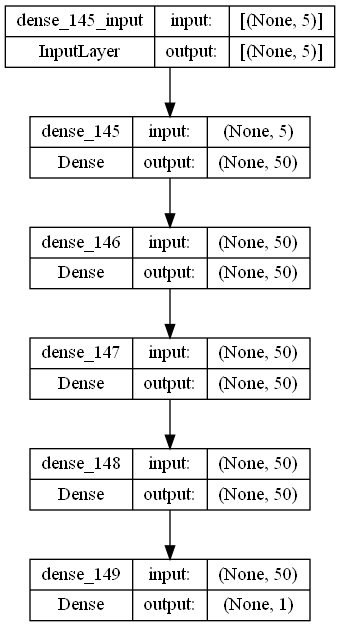

In [74]:
from keras.utils.vis_utils import plot_model

plot_model(model,to_file="model.png",show_shapes=True,show_layer_names=True)

625/625 [==============================] - 0s 731us/step
0.9687769711123521


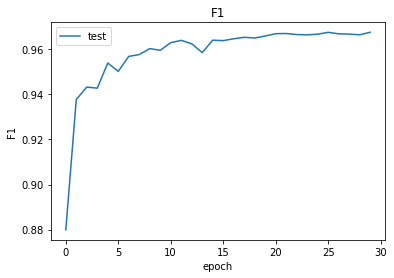

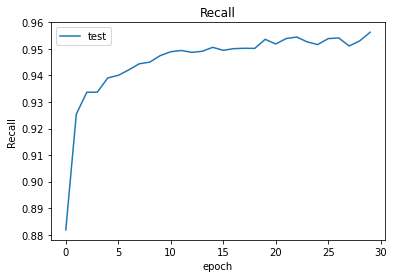

In [9]:
predictions = model.predict(X_test)

rounded = [int(round(x[0])) for x in predictions]

print(f1_score(y_test_lgb, rounded, average="binary"))
recall_score(y_test_lgb, rounded, average="binary")

plt.plot(history.history['f1_m'])
#plt.plot(history.history['val_acc'])
plt.title('F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['recall_m'])
#plt.plot(history.history['val_acc'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

## NN big sample 

In [7]:
%%time
X_train, X_test, y_train_split, y_test_split = train_test_split(df_final_train, y_train, test_size=0.33, random_state=25)

hidden_units=150
learning_rate=0.01
hidden_layer_act='relu'
output_layer_act='sigmoid'
no_epochs=30

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
scorers = ['f1_score']
from IPython.display import display


clm=['weight_f4', 'prefer_Attach_followers', 'prefer_Attach_followees', 'weight_f2', 'shortest_path', 'cosine_followees', 'hubs_d','hubs_s', 'follows_back', 'cosine_followers', 'katz_d', 'authorities_d', 'same_comp']

        


feature_names = list(df_final_train[clm].columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)

count = 1
# test data is not needed for fitting
for train_ix, test_ix in kf.split(df_final_train, y_train):
    X_train, X_test = df_final_train[clm].iloc[train_ix, :],df_final_train[clm].iloc[test_ix, :]
    y_train_lgb, y_test_lgb = y_train.iloc[train_ix], y_train.iloc[test_ix]

    
    model = Sequential()

    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(1, activation=output_layer_act))

    sgd=optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
    
    model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=[MeanSquaredError(),AUC(),f1_m,recall_m])
    
    history=model.fit(X_train, y_train_lgb, epochs=no_epochs, batch_size=50,  verbose=2)
    
    y_pred = model.predict(X_test)

    rounded = [int(round(x[0])) for x in y_pred]
    print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_lgb, rounded)))
    print('LightGBM Model f1 score: {0:0.4f}'.format(f1_score(y_test_lgb, rounded)))
    print('LightGBM Model recall score: {0:0.4f}'.format(recall_score(y_test_lgb, rounded)))



model.save("nn_model_new")
perm = PermutationImportance(model, random_state=0,scoring='neg_mean_squared_error').fit(X_train,y_train_lgb,epochs=no_epochs)
display(eli5.show_weights(perm, feature_names = X_train.columns.tolist()))

predictions = model.predict(X_test)

rounded = [int(round(x[0])) for x in predictions]



Epoch 1/30
1600/1600 - 3s - loss: 0.5194 - mean_squared_error: 0.1000 - auc_1: 0.9303 - f1_m: 0.8650 - recall_m: 0.8731 - 3s/epoch - 2ms/step
Epoch 2/30
1600/1600 - 2s - loss: 0.3017 - mean_squared_error: 0.0632 - auc_1: 0.9673 - f1_m: 0.9134 - recall_m: 0.9077 - 2s/epoch - 1ms/step
Epoch 3/30
1600/1600 - 2s - loss: 0.1965 - mean_squared_error: 0.0471 - auc_1: 0.9812 - f1_m: 0.9357 - recall_m: 0.9176 - 2s/epoch - 1ms/step
Epoch 4/30
1600/1600 - 2s - loss: 0.1740 - mean_squared_error: 0.0444 - auc_1: 0.9835 - f1_m: 0.9376 - recall_m: 0.9202 - 2s/epoch - 1ms/step
Epoch 5/30
1600/1600 - 2s - loss: 0.1678 - mean_squared_error: 0.0420 - auc_1: 0.9848 - f1_m: 0.9418 - recall_m: 0.9273 - 2s/epoch - 1ms/step
Epoch 6/30
1600/1600 - 2s - loss: 0.1296 - mean_squared_error: 0.0347 - auc_1: 0.9888 - f1_m: 0.9520 - recall_m: 0.9334 - 2s/epoch - 1ms/step
Epoch 7/30
1600/1600 - 2s - loss: 0.1299 - mean_squared_error: 0.0349 - auc_1: 0.9888 - f1_m: 0.9519 - recall_m: 0.9376 - 2s/epoch - 1ms/step
Epoch 

Epoch 28/30
1601/1601 - 2s - loss: 0.0870 - mean_squared_error: 0.0240 - auc_2: 0.9940 - f1_m: 0.9679 - recall_m: 0.9525 - 2s/epoch - 1ms/step
Epoch 29/30
1601/1601 - 2s - loss: 0.0891 - mean_squared_error: 0.0238 - auc_2: 0.9939 - f1_m: 0.9685 - recall_m: 0.9545 - 2s/epoch - 955us/step
Epoch 30/30
1601/1601 - 1s - loss: 0.1124 - mean_squared_error: 0.0289 - auc_2: 0.9918 - f1_m: 0.9608 - recall_m: 0.9507 - 1s/epoch - 931us/step
625/625 [==============================] - 0s 738us/step
LightGBM Model accuracy score: 0.9712
LightGBM Model f1 score: 0.9704
LightGBM Model recall score: 0.9589
Epoch 1/30
1601/1601 - 2s - loss: 0.6504 - mean_squared_error: 0.0978 - auc_3: 0.9323 - f1_m: 0.8666 - recall_m: 0.8659 - 2s/epoch - 1ms/step
Epoch 2/30
1601/1601 - 2s - loss: 0.3007 - mean_squared_error: 0.0553 - auc_3: 0.9736 - f1_m: 0.9249 - recall_m: 0.9147 - 2s/epoch - 1ms/step
Epoch 3/30
1601/1601 - 2s - loss: 0.1942 - mean_squared_error: 0.0439 - auc_3: 0.9829 - f1_m: 0.9394 - recall_m: 0.9277 

Epoch 23/30
1601/1601 - 2s - loss: 0.0865 - mean_squared_error: 0.0240 - auc_4: 0.9940 - f1_m: 0.9673 - recall_m: 0.9559 - 2s/epoch - 979us/step
Epoch 24/30
1601/1601 - 2s - loss: 0.0847 - mean_squared_error: 0.0233 - auc_4: 0.9942 - f1_m: 0.9692 - recall_m: 0.9561 - 2s/epoch - 974us/step
Epoch 25/30
1601/1601 - 2s - loss: 0.0853 - mean_squared_error: 0.0231 - auc_4: 0.9942 - f1_m: 0.9697 - recall_m: 0.9579 - 2s/epoch - 1ms/step
Epoch 26/30
1601/1601 - 1s - loss: 0.1059 - mean_squared_error: 0.0272 - auc_4: 0.9924 - f1_m: 0.9629 - recall_m: 0.9522 - 1s/epoch - 935us/step
Epoch 27/30
1601/1601 - 2s - loss: 0.0939 - mean_squared_error: 0.0248 - auc_4: 0.9935 - f1_m: 0.9660 - recall_m: 0.9548 - 2s/epoch - 964us/step
Epoch 28/30
1601/1601 - 2s - loss: 0.0845 - mean_squared_error: 0.0231 - auc_4: 0.9942 - f1_m: 0.9694 - recall_m: 0.9570 - 2s/epoch - 1ms/step
Epoch 29/30
1601/1601 - 2s - loss: 0.0854 - mean_squared_error: 0.0232 - auc_4: 0.9942 - f1_m: 0.9694 - recall_m: 0.9564 - 2s/epoch - 

INFO:tensorflow:Assets written to: nn_model_new\assets


2501/2501 [==============================] - 2s 846us/step


625/625 [==============================] - 1s 850us/step
Wall time: 7min 41s


625/625 [==============================] - 0s 641us/step
0.9687769711123521


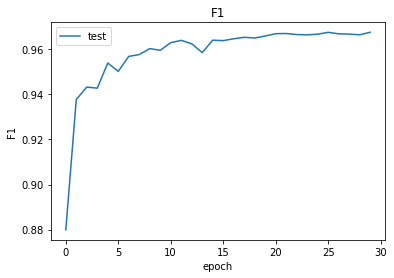

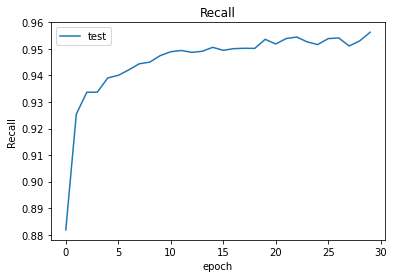

In [8]:
# f1_m(y_test_split, rounded)
# recall_m(y_test_split, rounded)
predictions = model.predict(X_test)

rounded = [int(round(x[0])) for x in predictions]

print(f1_score(y_test_lgb, rounded, average="binary"))
recall_score(y_test_lgb, rounded, average="binary")

plt.plot(history.history['f1_m'])
#plt.plot(history.history['val_acc'])
plt.title('F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['recall_m'])
#plt.plot(history.history['val_acc'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

## NN full sample

Epoch 1/30
1000/1000 - 2s - loss: 0.4847 - mean_squared_error: 0.0864 - auc_8: 0.9485 - f1_m: 0.8777 - recall_m: 0.8736 - 2s/epoch - 2ms/step
Epoch 2/30
1000/1000 - 1s - loss: 0.2043 - mean_squared_error: 0.0445 - auc_8: 0.9824 - f1_m: 0.9414 - recall_m: 0.9438 - 856ms/epoch - 856us/step
Epoch 3/30
1000/1000 - 1s - loss: 0.1466 - mean_squared_error: 0.0350 - auc_8: 0.9890 - f1_m: 0.9521 - recall_m: 0.9481 - 864ms/epoch - 864us/step
Epoch 4/30
1000/1000 - 1s - loss: 0.1295 - mean_squared_error: 0.0309 - auc_8: 0.9909 - f1_m: 0.9594 - recall_m: 0.9552 - 872ms/epoch - 872us/step
Epoch 5/30
1000/1000 - 1s - loss: 0.1011 - mean_squared_error: 0.0257 - auc_8: 0.9936 - f1_m: 0.9654 - recall_m: 0.9614 - 864ms/epoch - 864us/step
Epoch 6/30
1000/1000 - 1s - loss: 0.0885 - mean_squared_error: 0.0239 - auc_8: 0.9945 - f1_m: 0.9682 - recall_m: 0.9625 - 864ms/epoch - 864us/step
Epoch 7/30
1000/1000 - 1s - loss: 0.0790 - mean_squared_error: 0.0217 - auc_8: 0.9956 - f1_m: 0.9708 - recall_m: 0.9642 - 8

Epoch 26/30
1001/1001 - 1s - loss: 0.0581 - mean_squared_error: 0.0164 - auc_9: 0.9974 - f1_m: 0.9777 - recall_m: 0.9708 - 952ms/epoch - 951us/step
Epoch 27/30
1001/1001 - 1s - loss: 0.0581 - mean_squared_error: 0.0164 - auc_9: 0.9974 - f1_m: 0.9778 - recall_m: 0.9716 - 968ms/epoch - 967us/step
Epoch 28/30
1001/1001 - 1s - loss: 0.0572 - mean_squared_error: 0.0163 - auc_9: 0.9975 - f1_m: 0.9768 - recall_m: 0.9709 - 936ms/epoch - 935us/step
Epoch 29/30
1001/1001 - 1s - loss: 0.0556 - mean_squared_error: 0.0159 - auc_9: 0.9977 - f1_m: 0.9786 - recall_m: 0.9727 - 952ms/epoch - 951us/step
Epoch 30/30
1001/1001 - 1s - loss: 0.0559 - mean_squared_error: 0.0158 - auc_9: 0.9975 - f1_m: 0.9777 - recall_m: 0.9712 - 960ms/epoch - 959us/step
1563/1563 [==============================] - 1s 794us/step
LightGBM Model accuracy score: 0.9787
LightGBM Model f1 score: 0.9785
LightGBM Model recall score: 0.9668
INFO:tensorflow:Assets written to: nn_model_new_full\assets


INFO:tensorflow:Assets written to: nn_model_new_full\assets


1563/1563 [==============================] - 1s 676us/step


1563/1563 [==============================] - 1s 738us/step


1563/1563 [==============================] - 1s 776us/step
0.9784765869727774


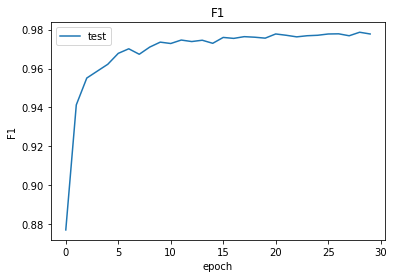

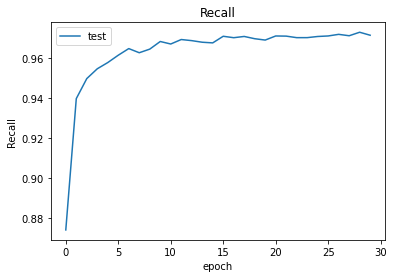

In [12]:

X_train, X_test, y_train_split, y_test_split = train_test_split(df_final_train, y_train, test_size=0.33, random_state=25)

hidden_units=150
learning_rate=0.01
hidden_layer_act='relu'
output_layer_act='sigmoid'
no_epochs=30

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
scorers = ['f1_score']
from IPython.display import display



        


feature_names = list(df_final_train.columns)

kf = KFold(n_splits=2,random_state=25,shuffle=True)

count = 1
# test data is not needed for fitting
for train_ix, test_ix in kf.split(df_final_train, y_train):
    X_train, X_test = df_final_train.iloc[train_ix, :],df_final_train.iloc[test_ix, :]
    y_train_lgb, y_test_lgb = y_train.iloc[train_ix], y_train.iloc[test_ix]

    
    model = Sequential()

    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(1, activation=output_layer_act))

    sgd=optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
    
    model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=[MeanSquaredError(),AUC(),f1_m,recall_m])
    
    history=model.fit(X_train, y_train_lgb, epochs=no_epochs, batch_size=50,  verbose=2)
    
    y_pred = model.predict(X_test)

    rounded = [int(round(x[0])) for x in y_pred]
    print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_lgb, rounded)))
    print('LightGBM Model f1 score: {0:0.4f}'.format(f1_score(y_test_lgb, rounded)))
    print('LightGBM Model recall score: {0:0.4f}'.format(recall_score(y_test_lgb, rounded)))



model.save("nn_model_new_full")
perm = PermutationImportance(model, random_state=0,scoring='neg_mean_squared_error').fit(X_train,y_train_lgb,epochs=no_epochs)
display(eli5.show_weights(perm, feature_names = X_train.columns.tolist()))

predictions = model.predict(X_test)

rounded = [int(round(x[0])) for x in predictions]



from keras.utils.vis_utils import plot_model

plot_model(model,to_file="model.png",show_shapes=True,show_layer_names=True)

# f1_m(y_test_split, rounded)
# recall_m(y_test_split, rounded)
predictions = model.predict(X_test)

rounded = [int(round(x[0])) for x in predictions]

print(f1_score(y_test_lgb, rounded, average="binary"))
recall_score(y_test_lgb, rounded, average="binary")

plt.plot(history.history['f1_m'])
#plt.plot(history.history['val_acc'])
plt.title('F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['recall_m'])
#plt.plot(history.history['val_acc'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

## Everything small sample

In [6]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor,KerasClassifier


param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(3,130),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf1 = RandomForestClassifier(random_state=25,n_jobs=-1)

clf2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

clf3= lgb.LGBMClassifier()

# def buildModel():

#     model = Sequential()

#     model.add(Dense(hidden_units, activation=hidden_layer_act))
#     model.add(Dense(hidden_units, activation=hidden_layer_act))
#     model.add(Dense(50, activation=hidden_layer_act))
#     model.add(Dense(50, activation=hidden_layer_act))
#     model.add(Dense(1, activation=output_layer_act))

#     sgd=optimizers.SGD(lr=learning_rate)
#     model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=[f1_m,recall_m])
#     return model


# clf4 = KerasRegressor(build_fn = buildModel)



param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__criterion'] = ["gini", "entropy"]
param1['classifier__max_depth'] = [40,80]
param1['classifier__min_samples_split'] = [130]
param1['classifier__min_samples_leaf'] = [40]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier'] = [clf2]

param3 = {}
param3['classifier'] = [clf3]

# param4={}
# param4['classifier__batch_size']= [0.8*len(df_final_train)]
# param4['classifier__epochs']= [10]
# param4['classifier']=[clf4]

pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2,param3]


clm=[
 'shortest_path',
 'follows_back',
 'same_comp',
 'weight_f4',
 'prefer_Attach_followers'
]


print(params)
rf_random = RandomizedSearchCV(pipeline, param_distributions=params,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')
                                   #n_iter=5,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')

rf_random.fit(df_final_train[clm],y_train)
print('mean test f1',rf_random.cv_results_['mean_test_f1'])
print('mean train f1',rf_random.cv_results_['mean_train_f1'])

[{'classifier__n_estimators': [10, 50, 100, 250], 'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [40, 80], 'classifier__min_samples_split': [130], 'classifier__min_samples_leaf': [40], 'classifier': [RandomForestClassifier(n_jobs=-1, random_state=25)]}, {'classifier': [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)]}, {'classifier': [LGBMClassifier()]}]
[16:14:05] WARNING: C:/Users

In [7]:
results_df = pd.DataFrame(rf_random.cv_results_)
results_df = results_df.sort_values(by=["mean_test_f1"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
results_df[["params", "mean_test_f1", "mean_test_roc_auc", "mean_test_recall","mean_test_precision","mean_test_balanced_accuracy"]].head(50)

params  \
params                                                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 10, 'classifier__...   
250_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 250, 'classifier_...   
50_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
50_130_40_80_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
100_130_40_80_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
100_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
50_130_40_40_entropy_RandomForestClassifier(n_j...  {'classifier__n_estimators': 50, 'classifier__...   
250_130_40_40_gini_RandomForestClassifier(n_job...  {'classifier__n_estimators': 250, 'classifier_...   
XGBClassifier(base_score=0.5, booster='gbtree',...  {'classifier': XGBClassifier(base_score=0.5, b...   
LGBMClassifier()                                                     {'classifier': LGBMClassifier()}   

                                                    mean_test_f1  \
params                                                             
10_130_40_40_gini_RandomForestClassifier(n_jobs...      0.964215   
250_130_40_40_entropy_RandomForestClassifier(n_...      0.964670   
50_130_40_40_gini_RandomForestClassifier(n_jobs...      0.964672   
50_130_40_80_gini_RandomForestClassifier(n_jobs...      0.964672   
100_130_40_80_entropy_RandomForestClassifier(n_...      0.964721   
100_130_40_40_entropy_RandomForestClassifier(n_...      0.964721   
50_130_40_40_entropy_RandomForestClassifier(n_j...      0.964811   
250_130_40_40_gini_RandomForestClassifier(n_job...      0.964813   
XGBClassifier(base_score=0.5, booster='gbtree',...      0.968719   
LGBMClassifier()                                        0.968796   

                                                    mean_test_roc_auc  \
params                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...           0.992493   
250_130_40_40_entropy_RandomForestClassifier(n_...           0.993019   
50_130_40_40_gini_RandomForestClassifier(n_jobs...           0.992887   
50_130_40_80_gini_RandomForestClassifier(n_jobs...           0.992887   
100_130_40_80_entropy_RandomForestClassifier(n_...           0.993006   
100_130_40_40_entropy_RandomForestClassifier(n_...           0.993006   
50_130_40_40_entropy_RandomForestClassifier(n_j...           0.992972   
250_130_40_40_gini_RandomForestClassifier(n_job...           0.992922   
XGBClassifier(base_score=0.5, booster='gbtree',...           0.993908   
LGBMClassifier()                                             0.994046   

                                                    mean_test_recall  \
params                                                                 
10_130_40_40_gini_RandomForestClassifier(n_jobs...          0.945133   
250_130_40_40_entropy_RandomForestClassifier(n_...          0.945715   
50_130_40_40_gini_RandomForestClassifier(n_jobs...          0.945775   
50_130_40_80_gini_RandomForestClassifier(n_jobs...          0.945775   
100_130_40_80_entropy_RandomForestClassifier(n_...          0.945213   
100_130_40_40_entropy_RandomForestClassifier(n_...          0.945213   
50_130_40_40_entropy_RandomForestClassifier(n_j...          0.944973   
250_130_40_40_gini_RandomForestClassifier(n_job...          0.945294   
XGBClassifier(base_score=0.5, booster='gbtree',...          0.954562   
LGBMClassifier()                                            0.951693   

                                                    mean_test_precision  \
params                                                                    
10_130_40_40_gini_RandomForestClassifier(n_jobs...             0.984100   
250_130_40_40_entropy_RandomForestClassifier(n_...

## Dependency between cv fold and AUC scores

                                                    split0_test_f1  \
params                                                               
10_130_40_40_gini_RandomForestClassifier(n_jobs...        0.964260   
250_130_40_40_entropy_RandomForestClassifier(n_...        0.964846   
50_130_40_40_gini_RandomForestClassifier(n_jobs...        0.964535   
50_130_40_80_gini_RandomForestClassifier(n_jobs...        0.964535   
100_130_40_80_entropy_RandomForestClassifier(n_...        0.964361   
100_130_40_40_entropy_RandomForestClassifier(n_...        0.964361   
50_130_40_40_entropy_RandomForestClassifier(n_j...        0.964888   
250_130_40_40_gini_RandomForestClassifier(n_job...        0.964495   
XGBClassifier(base_score=0.5, booster='gbtree',...        0.968080   
LGBMClassifier()                                          0.968359   

                                                    split1_test_f1  \
params                                                               
10_130_40_40_gini_R

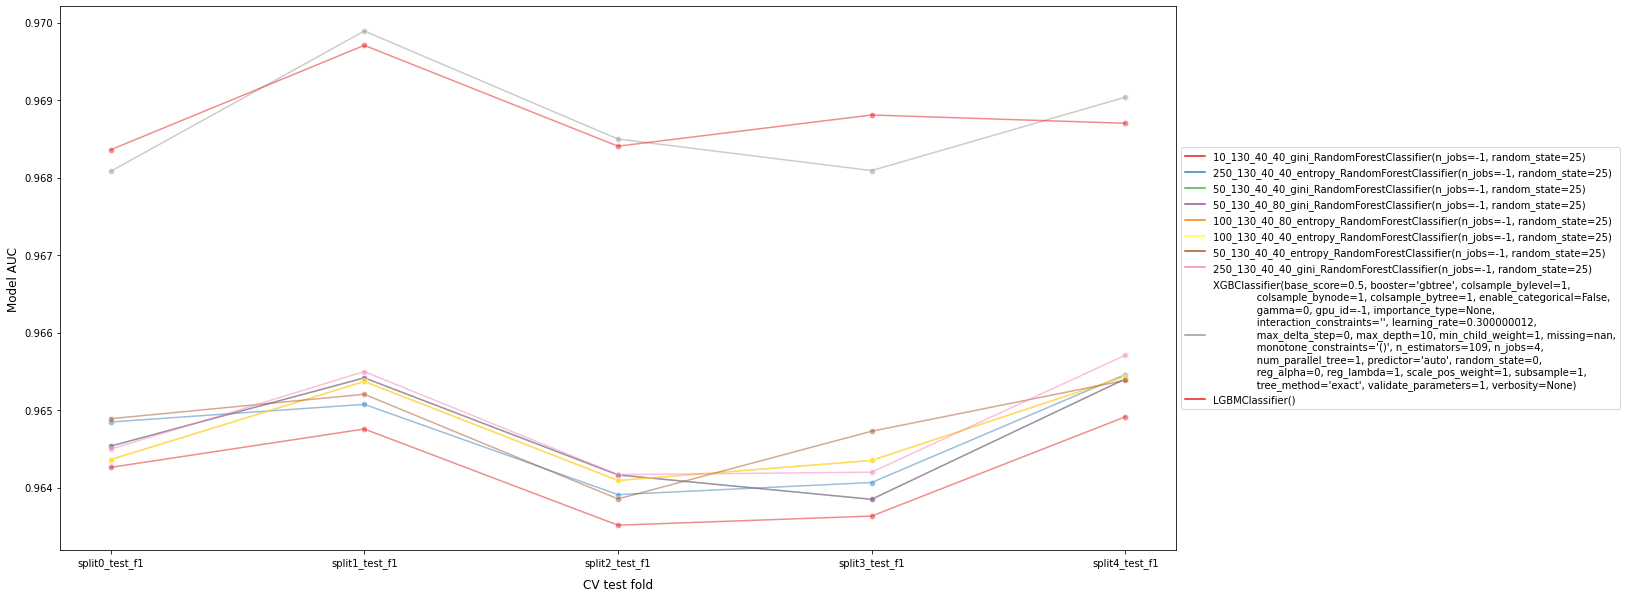

In [9]:
import seaborn as sns
model_scores = results_df.filter(regex=r"split\d*_test_f1")
print(model_scores)

fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(
    data=model_scores.transpose().iloc[:5],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('full_f1_sample.png')
plt.show()

## Everything big sample

In [10]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(3,130),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf1 = RandomForestClassifier(random_state=25,n_jobs=-1)

clf2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

clf3= lgb.LGBMClassifier()

# def buildModel():

#     model = Sequential()

#     model.add(Dense(hidden_units, activation=hidden_layer_act))
#     model.add(Dense(hidden_units, activation=hidden_layer_act))
#     model.add(Dense(50, activation=hidden_layer_act))
#     model.add(Dense(50, activation=hidden_layer_act))
#     model.add(Dense(1, activation=output_layer_act))

#     sgd=optimizers.SGD(lr=learning_rate)
#     model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=[f1_m,recall_m])
#     return model


# clf4 = KerasRegressor(build_fn = buildModel)



param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__criterion'] = ["gini", "entropy"]
param1['classifier__max_depth'] = [40,80]
param1['classifier__min_samples_split'] = [130]
param1['classifier__min_samples_leaf'] = [40]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier'] = [clf2]

param3 = {}
param3['classifier'] = [clf3]

# param4={}
# param4['classifier__batch_size']= [0.8*len(df_final_train)]
# param4['classifier__epochs']= [10]
# param4['classifier']=[clf4]

pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2,param3]


clm=['weight_f4', 'prefer_Attach_followers', 'prefer_Attach_followees', 'weight_f2', 'shortest_path', 'cosine_followees', 'hubs_d','hubs_s', 'follows_back', 'cosine_followers', 'katz_d', 'authorities_d', 'same_comp']


print(params)
rf_random = RandomizedSearchCV(pipeline, param_distributions=params,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')
                                   #n_iter=5,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')

rf_random.fit(df_final_train[clm],y_train)
print('mean test f1',rf_random.cv_results_['mean_test_f1'])
print('mean train f1',rf_random.cv_results_['mean_train_f1'])

[{'classifier__n_estimators': [10, 50, 100, 250], 'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [40, 80], 'classifier__min_samples_split': [130], 'classifier__min_samples_leaf': [40], 'classifier': [RandomForestClassifier(n_jobs=-1, random_state=25)]}, {'classifier': [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)]}, {'classifier': [LGBMClassifier()]}]
[16:43:28] WARNING: C:/Users

In [11]:
results_df = pd.DataFrame(rf_random.cv_results_)
results_df = results_df.sort_values(by=["mean_test_f1"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
results_df[["params", "mean_test_f1", "mean_test_roc_auc", "mean_test_recall","mean_test_precision","mean_test_balanced_accuracy"]].head(50)

params  \
params                                                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 10, 'classifier__...   
50_130_40_40_entropy_RandomForestClassifier(n_j...  {'classifier__n_estimators': 50, 'classifier__...   
50_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
50_130_40_80_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
100_130_40_80_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
100_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
250_130_40_40_gini_RandomForestClassifier(n_job...  {'classifier__n_estimators': 250, 'classifier_...   
250_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 250, 'classifier_...   
LGBMClassifier()                                                     {'classifier': LGBMClassifier()}   
XGBClassifier(base_score=0.5, booster='gbtree',...  {'classifier': XGBClassifier(base_score=0.5, b...   

                                                    mean_test_f1  \
params                                                             
10_130_40_40_gini_RandomForestClassifier(n_jobs...      0.965560   
50_130_40_40_entropy_RandomForestClassifier(n_j...      0.966985   
50_130_40_40_gini_RandomForestClassifier(n_jobs...      0.968020   
50_130_40_80_gini_RandomForestClassifier(n_jobs...      0.968020   
100_130_40_80_entropy_RandomForestClassifier(n_...      0.968113   
100_130_40_40_entropy_RandomForestClassifier(n_...      0.968113   
250_130_40_40_gini_RandomForestClassifier(n_job...      0.968325   
250_130_40_40_entropy_RandomForestClassifier(n_...      0.968663   
LGBMClassifier()                                        0.982765   
XGBClassifier(base_score=0.5, booster='gbtree',...      0.982938   

                                                    mean_test_roc_auc  \
params                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...           0.994415   
50_130_40_40_entropy_RandomForestClassifier(n_j...           0.995075   
50_130_40_40_gini_RandomForestClassifier(n_jobs...           0.995123   
50_130_40_80_gini_RandomForestClassifier(n_jobs...           0.995123   
100_130_40_80_entropy_RandomForestClassifier(n_...           0.995191   
100_130_40_40_entropy_RandomForestClassifier(n_...           0.995191   
250_130_40_40_gini_RandomForestClassifier(n_job...           0.995248   
250_130_40_40_entropy_RandomForestClassifier(n_...           0.995287   
LGBMClassifier()                                             0.998517   
XGBClassifier(base_score=0.5, booster='gbtree',...           0.998604   

                                                    mean_test_recall  \
params                                                                 
10_130_40_40_gini_RandomForestClassifier(n_jobs...          0.942124   
50_130_40_40_entropy_RandomForestClassifier(n_j...          0.944652   
50_130_40_40_gini_RandomForestClassifier(n_jobs...          0.947019   
50_130_40_80_gini_RandomForestClassifier(n_jobs...          0.947019   
100_130_40_80_entropy_RandomForestClassifier(n_...          0.946859   
100_130_40_40_entropy_RandomForestClassifier(n_...          0.946859   
250_130_40_40_gini_RandomForestClassifier(n_job...          0.947240   
250_130_40_40_entropy_RandomForestClassifier(n_...          0.947902   
LGBMClassifier()                                            0.974603   
XGBClassifier(base_score=0.5, booster='gbtree',...          0.976589   

                                                    mean_test_precision  \
params                                                                    
10_130_40_40_gini_RandomForestClassifier(n_jobs...             0.990197   
50_130_40_40_entropy_RandomForestClassifier(n_j...

## Dependency between cv fold and AUC scores

                                                    split0_test_f1  \
params                                                               
10_130_40_40_gini_RandomForestClassifier(n_jobs...        0.967775   
50_130_40_40_entropy_RandomForestClassifier(n_j...        0.965648   
50_130_40_40_gini_RandomForestClassifier(n_jobs...        0.968218   
50_130_40_80_gini_RandomForestClassifier(n_jobs...        0.968218   
100_130_40_80_entropy_RandomForestClassifier(n_...        0.967666   
100_130_40_40_entropy_RandomForestClassifier(n_...        0.967666   
250_130_40_40_gini_RandomForestClassifier(n_job...        0.968192   
250_130_40_40_entropy_RandomForestClassifier(n_...        0.968357   
LGBMClassifier()                                          0.982890   
XGBClassifier(base_score=0.5, booster='gbtree',...        0.983484   

                                                    split1_test_f1  \
params                                                               
10_130_40_40_gini_R

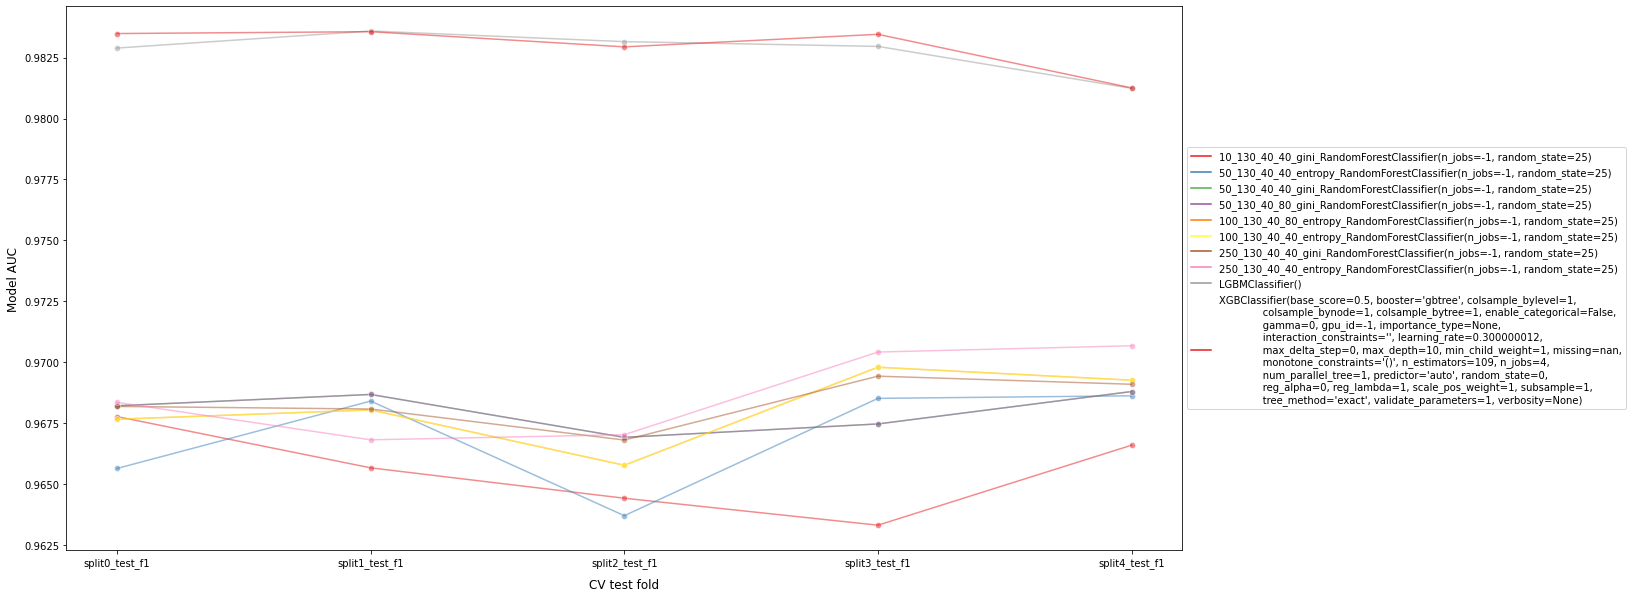

In [12]:
import seaborn as sns
model_scores = results_df.filter(regex=r"split\d*_test_f1")
print(model_scores)

fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(
    data=model_scores.transpose().iloc[:5],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## All algorithms big sample

In [33]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(3,130),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

learning_rate=0.01
hidden_layer_act='relu'
output_layer_act='sigmoid'

clf1 = RandomForestClassifier(random_state=25,n_jobs=-1)

clf2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

clf3= lgb.LGBMClassifier()

def buildModel():

    model = Sequential()

    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(1, activation=output_layer_act))

    sgd=optimizers.SGD(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[f1_m,recall_m])
    return model


clf4 = KerasRegressor(build_fn = buildModel)

clm=[
 'shortest_path',
 'follows_back',
 'same_comp',
 'weight_f4',
 'prefer_Attach_followers'
]

param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__criterion'] = ["gini", "entropy"]
param1['classifier__max_depth'] = [40,80]
param1['classifier__min_samples_split'] = [130]
param1['classifier__min_samples_leaf'] = [40]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier'] = [clf2]

param3 = {}
param3['classifier'] = [clf3]

param4={}
param4['classifier__batch_size']= [50]
param4['classifier__epochs']= [25]
param4['classifier']=[clf4]

pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2,param3]


clm=['weight_f4', 'prefer_Attach_followers', 'prefer_Attach_followees', 'weight_f2', 'shortest_path', 'cosine_followees', 'hubs_d','hubs_s', 'follows_back', 'cosine_followers', 'katz_d', 'authorities_d', 'same_comp']


print(params)
rf_random = RandomizedSearchCV(pipeline, param_distributions=params,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')
                                   #n_iter=5,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')

pipeline_nn = Pipeline([('classifier', clf4)])
params_nn = [param4]    
rf_random_nn = RandomizedSearchCV(pipeline_nn, param_distributions=params_nn,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')

rf_random.fit(df_final_train[clm],y_train)
print('mean test f1',rf_random.cv_results_['mean_test_f1'])
print('mean train f1',rf_random.cv_results_['mean_train_f1'])

rf_random_nn.fit(df_final_train[clm],y_train)
print('mean test f1',rf_random_nn.cv_results_['mean_test_f1'])
print('mean train f1',rf_random_nn.cv_results_['mean_train_f1'])

[{'classifier__n_estimators': [10, 50, 100, 250], 'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [40, 80], 'classifier__min_samples_split': [130], 'classifier__min_samples_leaf': [40], 'classifier': [RandomForestClassifier(n_jobs=-1, random_state=25)]}, {'classifier': [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)]}, {'classifier': [LGBMClassifier()]}]
[21:42:00] WARNING: C:/Users

1601/1601 [==============================] - 6s 4ms/step - loss: 0.1342 - f1_m: 0.9583 - recall_m: 0.9518
Epoch 10/25
1601/1601 [==============================] - 6s 4ms/step - loss: 0.1450 - f1_m: 0.9613 - recall_m: 0.9525
Epoch 11/25
1601/1601 [==============================] - 6s 4ms/step - loss: 0.1090 - f1_m: 0.9670 - recall_m: 0.9582
Epoch 12/25
1601/1601 [==============================] - 6s 4ms/step - loss: 0.1101 - f1_m: 0.9665 - recall_m: 0.9569
Epoch 13/25
1601/1601 [==============================] - 6s 4ms/step - loss: 0.1066 - f1_m: 0.9659 - recall_m: 0.9574
Epoch 14/25
1601/1601 [==============================] - 6s 4ms/step - loss: 0.0965 - f1_m: 0.9684 - recall_m: 0.9585
Epoch 15/25
1601/1601 [==============================] - 6s 4ms/step - loss: 0.0955 - f1_m: 0.9697 - recall_m: 0.9593
Epoch 16/25
1601/1601 [==============================] - 6s 4ms/step - loss: 0.0933 - f1_m: 0.9699 - recall_m: 0.9592
Epoch 17/25
1601/1601 [==============================] - 6s 4ms/step

In [34]:
results_df = pd.DataFrame(rf_random.cv_results_)
results_df = results_df.sort_values(by=["mean_test_f1"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
results_df[["params", "mean_test_f1", "mean_test_roc_auc", "mean_test_recall","mean_test_precision","mean_test_balanced_accuracy"]].head(50)

params  \
params                                                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 10, 'classifier__...   
50_130_40_40_entropy_RandomForestClassifier(n_j...  {'classifier__n_estimators': 50, 'classifier__...   
50_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
50_130_40_80_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
100_130_40_80_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
100_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
250_130_40_40_gini_RandomForestClassifier(n_job...  {'classifier__n_estimators': 250, 'classifier_...   
250_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 250, 'classifier_...   
LGBMClassifier()                                                     {'classifier': LGBMClassifier()}   
XGBClassifier(base_score=0.5, booster='gbtree',...  {'classifier': XGBClassifier(base_score=0.5, b...   

                                                    mean_test_f1  \
params                                                             
10_130_40_40_gini_RandomForestClassifier(n_jobs...      0.965560   
50_130_40_40_entropy_RandomForestClassifier(n_j...      0.966985   
50_130_40_40_gini_RandomForestClassifier(n_jobs...      0.968020   
50_130_40_80_gini_RandomForestClassifier(n_jobs...      0.968020   
100_130_40_80_entropy_RandomForestClassifier(n_...      0.968113   
100_130_40_40_entropy_RandomForestClassifier(n_...      0.968113   
250_130_40_40_gini_RandomForestClassifier(n_job...      0.968325   
250_130_40_40_entropy_RandomForestClassifier(n_...      0.968663   
LGBMClassifier()                                        0.982765   
XGBClassifier(base_score=0.5, booster='gbtree',...      0.982938   

                                                    mean_test_roc_auc  \
params                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...           0.994415   
50_130_40_40_entropy_RandomForestClassifier(n_j...           0.995075   
50_130_40_40_gini_RandomForestClassifier(n_jobs...           0.995123   
50_130_40_80_gini_RandomForestClassifier(n_jobs...           0.995123   
100_130_40_80_entropy_RandomForestClassifier(n_...           0.995191   
100_130_40_40_entropy_RandomForestClassifier(n_...           0.995191   
250_130_40_40_gini_RandomForestClassifier(n_job...           0.995248   
250_130_40_40_entropy_RandomForestClassifier(n_...           0.995287   
LGBMClassifier()                                             0.998517   
XGBClassifier(base_score=0.5, booster='gbtree',...           0.998604   

                                                    mean_test_recall  \
params                                                                 
10_130_40_40_gini_RandomForestClassifier(n_jobs...          0.942124   
50_130_40_40_entropy_RandomForestClassifier(n_j...          0.944652   
50_130_40_40_gini_RandomForestClassifier(n_jobs...          0.947019   
50_130_40_80_gini_RandomForestClassifier(n_jobs...          0.947019   
100_130_40_80_entropy_RandomForestClassifier(n_...          0.946859   
100_130_40_40_entropy_RandomForestClassifier(n_...          0.946859   
250_130_40_40_gini_RandomForestClassifier(n_job...          0.947240   
250_130_40_40_entropy_RandomForestClassifier(n_...          0.947902   
LGBMClassifier()                                            0.974603   
XGBClassifier(base_score=0.5, booster='gbtree',...          0.976589   

                                                    mean_test_precision  \
params                                                                    
10_130_40_40_gini_RandomForestClassifier(n_jobs...             0.990197   
50_130_40_40_entropy_RandomForestClassifier(n_j...

In [35]:
results_df_dict=results_df[['params','split0_test_f1','split1_test_f1','split2_test_f1','split3_test_f1','split4_test_f1']].to_dict()
results_df_dict

{'params': {'10_130_40_40_gini_RandomForestClassifier(n_jobs=-1, random_state=25)': {'classifier__n_estimators': 10,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
  '50_130_40_40_entropy_RandomForestClassifier(n_jobs=-1, random_state=25)': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'entropy',
   'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
  '50_130_40_40_gini_RandomForestClassifier(n_jobs=-1, random_state=25)': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
  '50_130

In [39]:
results_df_dict={'params': {'10_130_40_40_gini_RandomForestClassifier': {'classifier__n_estimators': 10,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': 'RandomForestClassifier'},
  '50_130_40_40_entropy_RandomForestClassifier': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'entropy',
   'classifier': 'RandomForestClassifier'},
  '50_130_40_40_gini_RandomForestClassifier': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': 'RandomForestClassifier'},
  '50_130_40_80_gini_RandomForestClassifier': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 80,
   'classifier__criterion': 'gini',
   'classifier': 'RandomForestClassifier'},
  '100_130_40_80_entropy_RandomForestClassifier': {'classifier__n_estimators': 100,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 80,
   'classifier__criterion': 'entropy',
   'classifier': 'RandomForestClassifier'},
  '100_130_40_40_entropy_RandomForestClassifier': {'classifier__n_estimators': 100,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'entropy',
   'classifier': 'RandomForestClassifier'},
  '250_130_40_40_gini_RandomForestClassifier': {'classifier__n_estimators': 250,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': 'RandomForestClassifier'},
  '250_130_40_40_entropy_RandomForestClassifier': {'classifier__n_estimators': 250,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'entropy',
   'classifier': 'RandomForestClassifier'},
  'LGBMClassifier': {'classifier': 'LGBMClassifier'},
  "XGBClassifier": {'classifier': 'XGBClassifier'},
    "Neural_Network":{'classifier': 'Neural_Network'}},
 'split0_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9677750410509031,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9656484624087216,
  '50_130_40_40_gini_RandomForestClassifier': 0.9682181669058848,
  '50_130_40_80_gini_RandomForestClassifier': 0.9682181669058848,
  '100_130_40_80_entropy_RandomForestClassifier': 0.9676657770478341,
  '100_130_40_40_entropy_RandomForestClassifier': 0.9676657770478341,
  '250_130_40_40_gini_RandomForestClassifier': 0.9681920788015597,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9683573516590595,
  'LGBMClassifier': 0.9828895413587122,
  "XGBClassifier": 0.9834840143441588,
                   'Neural_Network':0.9585},
 'split1_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9656729437118375,
  '50_130_40_40_entropy_RandomForestClassifier': 0.96841243024625,
  '50_130_40_40_gini_RandomForestClassifier': 0.9686828369665336,
  '50_130_40_80_gini_RandomForestClassifier': 0.9686828369665336,
  '100_130_40_80_entropy_RandomForestClassifier': 0.9680491551459295,
  '100_130_40_40_entropy_RandomForestClassifier': 0.9680491551459295,
  '250_130_40_40_gini_RandomForestClassifier': 0.9680856513498284,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9668222142454234,
  'LGBMClassifier': 0.9835883452002221,
  "XGBClassifier": 0.9835602622289461,
                   'Neural_Network':0.9644},
 'split2_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9644272844272843,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9637113402061855,
  '50_130_40_40_gini_RandomForestClassifier': 0.9669234720082178,
  '50_130_40_80_gini_RandomForestClassifier': 0.9669234720082178,
  '100_130_40_80_entropy_RandomForestClassifier': 0.9657798590027273,
  '100_130_40_40_entropy_RandomForestClassifier': 0.9657798590027273,
  '250_130_40_40_gini_RandomForestClassifier': 0.966813931983972,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9670329670329672,
  'LGBMClassifier': 0.9831520364280292,
  "XGBClassifier": 0.9829379101463906,
                    'Neural_Network':0.9675},
 'split3_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9633216567071915,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9685225058956218,
  '50_130_40_40_gini_RandomForestClassifier': 0.9674738354196594,
  '50_130_40_80_gini_RandomForestClassifier': 0.9674738354196594,
  '100_130_40_80_entropy_RandomForestClassifier': 0.9697993447993448,
  '100_130_40_40_entropy_RandomForestClassifier': 0.9697993447993448,
  '250_130_40_40_gini_RandomForestClassifier': 0.969433208745072,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9704226793572818,
  'LGBMClassifier': 0.9829565569210539,
  "XGBClassifier": 0.983452729290687,
                    'Neural_Network':0.9727},
 'split4_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9666015825711645,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9686282550748411,
  '50_130_40_40_gini_RandomForestClassifier': 0.9688028277239896,
  '50_130_40_80_gini_RandomForestClassifier': 0.9688028277239896,
  '100_130_40_80_entropy_RandomForestClassifier': 0.9692685925015365,
  '100_130_40_40_entropy_RandomForestClassifier': 0.9692685925015365,
  '250_130_40_40_gini_RandomForestClassifier': 0.9691006917755574,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9706800388886047,
  'LGBMClassifier': 0.981237040408638,
  "XGBClassifier": 0.9812541054014451,
                   'Neural_Network':0.9653}}

## Dependency between cv fold and AUC scores

In [42]:
results_df_new=pd.DataFrame.from_dict(results_df_dict)

                                              split0_test_f1  split1_test_f1  \
10_130_40_40_gini_RandomForestClassifier            0.967775        0.965673   
50_130_40_40_entropy_RandomForestClassifier         0.965648        0.968412   
50_130_40_40_gini_RandomForestClassifier            0.968218        0.968683   
50_130_40_80_gini_RandomForestClassifier            0.968218        0.968683   
100_130_40_80_entropy_RandomForestClassifier        0.967666        0.968049   
100_130_40_40_entropy_RandomForestClassifier        0.967666        0.968049   
250_130_40_40_gini_RandomForestClassifier           0.968192        0.968086   
250_130_40_40_entropy_RandomForestClassifier        0.968357        0.966822   
LGBMClassifier                                      0.982890        0.983588   
XGBClassifier                                       0.983484        0.983560   
Neural_Network                                      0.958500        0.964400   

                                       

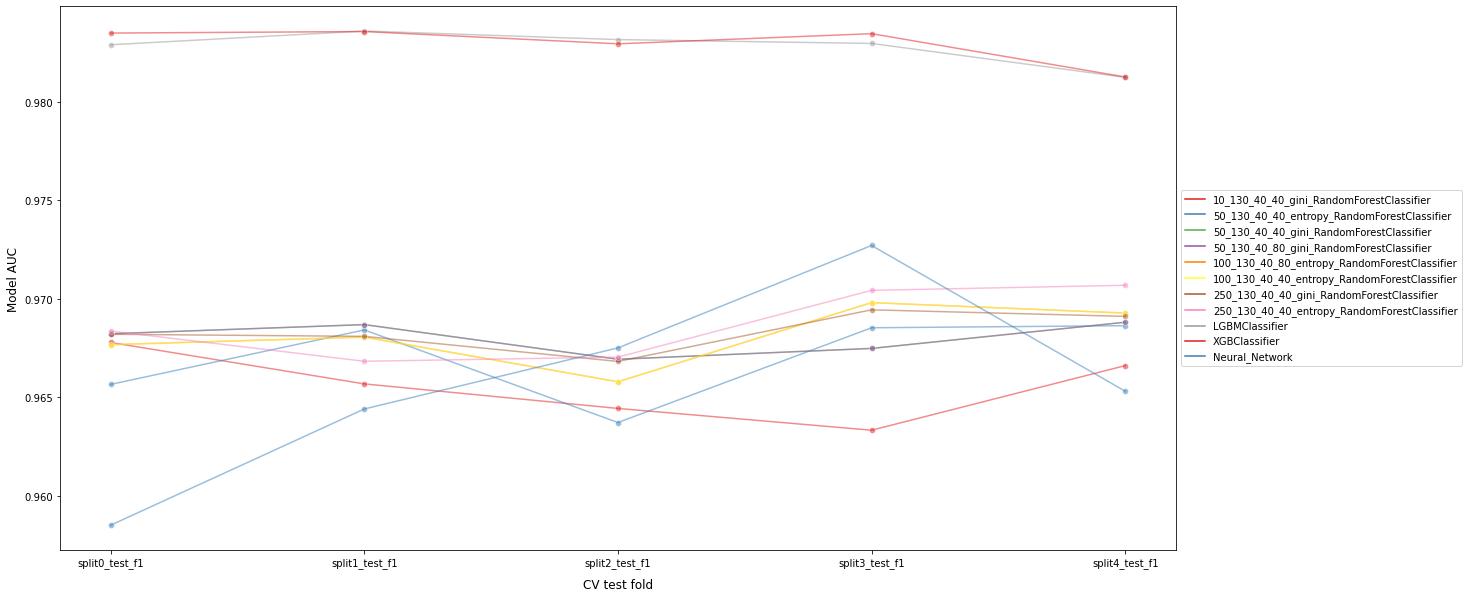

In [43]:
import seaborn as sns
model_scores = results_df_new.filter(regex=r"split\d*_test_f1")
print(model_scores)

fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(
    data=model_scores.transpose().iloc[:5],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## All testing with small samples

In [46]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(3,130),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

learning_rate=0.01
hidden_layer_act='relu'
output_layer_act='sigmoid'

clf1 = RandomForestClassifier(random_state=25,n_jobs=-1)

clf2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

clf3= lgb.LGBMClassifier()

def buildModel():

    model = Sequential()

    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(1, activation=output_layer_act))

    sgd=optimizers.SGD(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[f1_m,recall_m])
    return model


clf4 = KerasRegressor(build_fn = buildModel)

clm=[
 'shortest_path',
 'follows_back',
 'same_comp',
 'weight_f4',
 'prefer_Attach_followers'
]

param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__criterion'] = ["gini", "entropy"]
param1['classifier__max_depth'] = [40,80]
param1['classifier__min_samples_split'] = [130]
param1['classifier__min_samples_leaf'] = [40]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier'] = [clf2]

param3 = {}
param3['classifier'] = [clf3]

param4={}
param4['classifier__batch_size']= [50]
param4['classifier__epochs']= [25]
param4['classifier']=[clf4]

pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2,param3]




print(params)
rf_random = RandomizedSearchCV(pipeline, param_distributions=params,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')
                                   #n_iter=5,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')

pipeline_nn = Pipeline([('classifier', clf4)])
params_nn = [param4]    
rf_random_nn = RandomizedSearchCV(pipeline_nn, param_distributions=params_nn,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')

rf_random.fit(df_final_train[clm],y_train)
print('mean test f1',rf_random.cv_results_['mean_test_f1'])
print('mean train f1',rf_random.cv_results_['mean_train_f1'])

rf_random_nn.fit(df_final_train[clm],y_train)
print('mean test f1',rf_random_nn.cv_results_['mean_test_f1'])
print('mean train f1',rf_random_nn.cv_results_['mean_train_f1'])

[{'classifier__n_estimators': [10, 50, 100, 250], 'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [40, 80], 'classifier__min_samples_split': [130], 'classifier__min_samples_leaf': [40], 'classifier': [RandomForestClassifier(n_jobs=-1, random_state=25)]}, {'classifier': [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)]}, {'classifier': [LGBMClassifier()]}]
[23:17:42] WARNING: C:/Users

1601/1601 [==============================] - 2s 1ms/step - loss: 0.1061 - f1_m: 0.9469 - recall_m: 0.9139
Epoch 22/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.1007 - f1_m: 0.9492 - recall_m: 0.9179
Epoch 23/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.0986 - f1_m: 0.9490 - recall_m: 0.9176
Epoch 24/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.0968 - f1_m: 0.9490 - recall_m: 0.9161
Epoch 25/25
1601/1601 [==============================] - 1s 830us/step
Epoch 1/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.4560 - f1_m: 0.8871 - recall_m: 0.8799
Epoch 2/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.3139 - f1_m: 0.9290 - recall_m: 0.9081
Epoch 3/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.2403 - f1_m: 0.9371 - recall_m: 0.9093
Epoch 4/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.1748 - f1_m: 0.9414 - recall_m: 0.9178
E

In [47]:
results_df = pd.DataFrame(rf_random.cv_results_)
results_df = results_df.sort_values(by=["mean_test_f1"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
results_df[["params", "mean_test_f1", "mean_test_roc_auc", "mean_test_recall","mean_test_precision","mean_test_balanced_accuracy"]].head(50)

params  \
params                                                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 10, 'classifier__...   
250_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 250, 'classifier_...   
50_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
50_130_40_80_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
100_130_40_80_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
100_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
50_130_40_40_entropy_RandomForestClassifier(n_j...  {'classifier__n_estimators': 50, 'classifier__...   
250_130_40_40_gini_RandomForestClassifier(n_job...  {'classifier__n_estimators': 250, 'classifier_...   
XGBClassifier(base_score=0.5, booster='gbtree',...  {'classifier': XGBClassifier(base_score=0.5, b...   
LGBMClassifier()                                                     {'classifier': LGBMClassifier()}   

                                                    mean_test_f1  \
params                                                             
10_130_40_40_gini_RandomForestClassifier(n_jobs...      0.964215   
250_130_40_40_entropy_RandomForestClassifier(n_...      0.964670   
50_130_40_40_gini_RandomForestClassifier(n_jobs...      0.964672   
50_130_40_80_gini_RandomForestClassifier(n_jobs...      0.964672   
100_130_40_80_entropy_RandomForestClassifier(n_...      0.964721   
100_130_40_40_entropy_RandomForestClassifier(n_...      0.964721   
50_130_40_40_entropy_RandomForestClassifier(n_j...      0.964811   
250_130_40_40_gini_RandomForestClassifier(n_job...      0.964813   
XGBClassifier(base_score=0.5, booster='gbtree',...      0.968719   
LGBMClassifier()                                        0.968796   

                                                    mean_test_roc_auc  \
params                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...           0.992493   
250_130_40_40_entropy_RandomForestClassifier(n_...           0.993019   
50_130_40_40_gini_RandomForestClassifier(n_jobs...           0.992887   
50_130_40_80_gini_RandomForestClassifier(n_jobs...           0.992887   
100_130_40_80_entropy_RandomForestClassifier(n_...           0.993006   
100_130_40_40_entropy_RandomForestClassifier(n_...           0.993006   
50_130_40_40_entropy_RandomForestClassifier(n_j...           0.992972   
250_130_40_40_gini_RandomForestClassifier(n_job...           0.992922   
XGBClassifier(base_score=0.5, booster='gbtree',...           0.993908   
LGBMClassifier()                                             0.994046   

                                                    mean_test_recall  \
params                                                                 
10_130_40_40_gini_RandomForestClassifier(n_jobs...          0.945133   
250_130_40_40_entropy_RandomForestClassifier(n_...          0.945715   
50_130_40_40_gini_RandomForestClassifier(n_jobs...          0.945775   
50_130_40_80_gini_RandomForestClassifier(n_jobs...          0.945775   
100_130_40_80_entropy_RandomForestClassifier(n_...          0.945213   
100_130_40_40_entropy_RandomForestClassifier(n_...          0.945213   
50_130_40_40_entropy_RandomForestClassifier(n_j...          0.944973   
250_130_40_40_gini_RandomForestClassifier(n_job...          0.945294   
XGBClassifier(base_score=0.5, booster='gbtree',...          0.954562   
LGBMClassifier()                                            0.951693   

                                                    mean_test_precision  \
params                                                                    
10_130_40_40_gini_RandomForestClassifier(n_jobs...             0.984100   
250_130_40_40_entropy_RandomForestClassifier(n_...

In [48]:
results_df_dict=results_df[['params','split0_test_f1','split1_test_f1','split2_test_f1','split3_test_f1','split4_test_f1']].to_dict()
results_df_dict

{'params': {'10_130_40_40_gini_RandomForestClassifier(n_jobs=-1, random_state=25)': {'classifier__n_estimators': 10,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
  '250_130_40_40_entropy_RandomForestClassifier(n_jobs=-1, random_state=25)': {'classifier__n_estimators': 250,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'entropy',
   'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
  '50_130_40_40_gini_RandomForestClassifier(n_jobs=-1, random_state=25)': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
  '50_1

In [52]:
results_df_dict={'params': {'10_130_40_40_gini_RandomForestClassifier': {'classifier__n_estimators': 10,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': 'RandomForestClassifier'},
  '250_130_40_40_entropy_RandomForestClassifier': {'classifier__n_estimators': 250,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'entropy',
   'classifier': 'RandomForestClassifier'},
  '50_130_40_40_gini_RandomForestClassifier': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': 'RandomForestClassifier'},
  '50_130_40_80_gini_RandomForestClassifier': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 80,
   'classifier__criterion': 'gini',
   'classifier': 'RandomForestClassifier'},
  '100_130_40_80_entropy_RandomForestClassifier': {'classifier__n_estimators': 100,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 80,
   'classifier__criterion': 'entropy',
   'classifier': 'RandomForestClassifier'},
  '100_130_40_40_entropy_RandomForestClassifier': {'classifier__n_estimators': 100,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'entropy',
   'classifier': 'RandomForestClassifier'},
  '50_130_40_40_entropy_RandomForestClassifier': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'entropy',
   'classifier': 'RandomForestClassifier'},
  '250_130_40_40_gini_RandomForestClassifier': {'classifier__n_estimators': 250,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': 'RandomForestClassifier'},
  "XGBClassifier": {'classifier': 'XGBClassifier'},
  'LGBMClassifier': {'classifier': 'LGBMClassifier'},
   "Neural_Network":{'classifier': 'Neural_Network'}},
 'split0_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9642600390263941,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9648457517679616,
  '50_130_40_40_gini_RandomForestClassifier': 0.9645346453464535,
  '50_130_40_80_gini_RandomForestClassifier': 0.9645346453464535,
  '100_130_40_80_entropy_RandomForestClassifier': 0.9643608020101534,
  '100_130_40_40_entropy_RandomForestClassifier': 0.9643608020101534,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9648880004100672,
  '250_130_40_40_gini_RandomForestClassifier': 0.9644946126218574,
  "XGBClassifier": 0.9680802321437662,
  'LGBMClassifier': 0.9683586362009916,
   'Neural_Network':0.9476},
 'split1_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9647552304465702,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9650735294117647,
  '50_130_40_40_gini_RandomForestClassifier': 0.9654150702426565,
  '50_130_40_80_gini_RandomForestClassifier': 0.9654150702426565,
  '100_130_40_80_entropy_RandomForestClassifier': 0.9653692920625191,
  '100_130_40_40_entropy_RandomForestClassifier': 0.9653692920625191,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9652036175974656,
  '250_130_40_40_gini_RandomForestClassifier': 0.9654960895568164,
  "XGBClassifier": 0.9698911606143831,
  'LGBMClassifier': 0.9697062423500612,
   'Neural_Network':0.9491},
 'split2_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9635141376302151,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9639085409617554,
  '50_130_40_40_gini_RandomForestClassifier': 0.9641630351192001,
  '50_130_40_80_gini_RandomForestClassifier': 0.9641630351192001,
  '100_130_40_80_entropy_RandomForestClassifier': 0.9640915153380528,
  '100_130_40_40_entropy_RandomForestClassifier': 0.9640915153380528,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9638529472170878,
  '250_130_40_40_gini_RandomForestClassifier': 0.964166709386374,
  "XGBClassifier": 0.9684971245355998,
  'LGBMClassifier': 0.9684049079754601,
   'Neural_Network':0.9538},
 'split3_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.963631726600357,
  '250_130_40_40_entropy_RandomForestClassifier': 0.964064816234729,
  '50_130_40_40_gini_RandomForestClassifier': 0.9638480392156862,
  '50_130_40_80_gini_RandomForestClassifier': 0.9638480392156862,
  '100_130_40_80_entropy_RandomForestClassifier': 0.9643496496342898,
  '100_130_40_40_entropy_RandomForestClassifier': 0.9643496496342898,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9647263605180977,
  '250_130_40_40_gini_RandomForestClassifier': 0.9641980360065466,
  "XGBClassifier": 0.9680899791337981,
  'LGBMClassifier': 0.9688073394495413,
   'Neural_Network':0.9573},
 'split4_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9649122807017544,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9654573326520183,
  '50_130_40_40_gini_RandomForestClassifier': 0.9654009301374763,
  '50_130_40_80_gini_RandomForestClassifier': 0.9654009301374763,
  '100_130_40_80_entropy_RandomForestClassifier': 0.965432603804459,
  '100_130_40_40_entropy_RandomForestClassifier': 0.965432603804459,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9653832387380478,
  '250_130_40_40_gini_RandomForestClassifier': 0.9657075688659477,
  "XGBClassifier": 0.9690364636382155,
  'LGBMClassifier': 0.9687005361245852,
   'Neural_Network':0.9551}}

In [53]:
results_df_new=pd.DataFrame.from_dict(results_df_dict)

## Dependency between cv fold and AUC scores

                                              split0_test_f1  split1_test_f1  \
10_130_40_40_gini_RandomForestClassifier            0.964260        0.964755   
250_130_40_40_entropy_RandomForestClassifier        0.964846        0.965074   
50_130_40_40_gini_RandomForestClassifier            0.964535        0.965415   
50_130_40_80_gini_RandomForestClassifier            0.964535        0.965415   
100_130_40_80_entropy_RandomForestClassifier        0.964361        0.965369   
100_130_40_40_entropy_RandomForestClassifier        0.964361        0.965369   
50_130_40_40_entropy_RandomForestClassifier         0.964888        0.965204   
250_130_40_40_gini_RandomForestClassifier           0.964495        0.965496   
XGBClassifier                                       0.968080        0.969891   
LGBMClassifier                                      0.968359        0.969706   
Neural_Network                                      0.947600        0.949100   

                                       

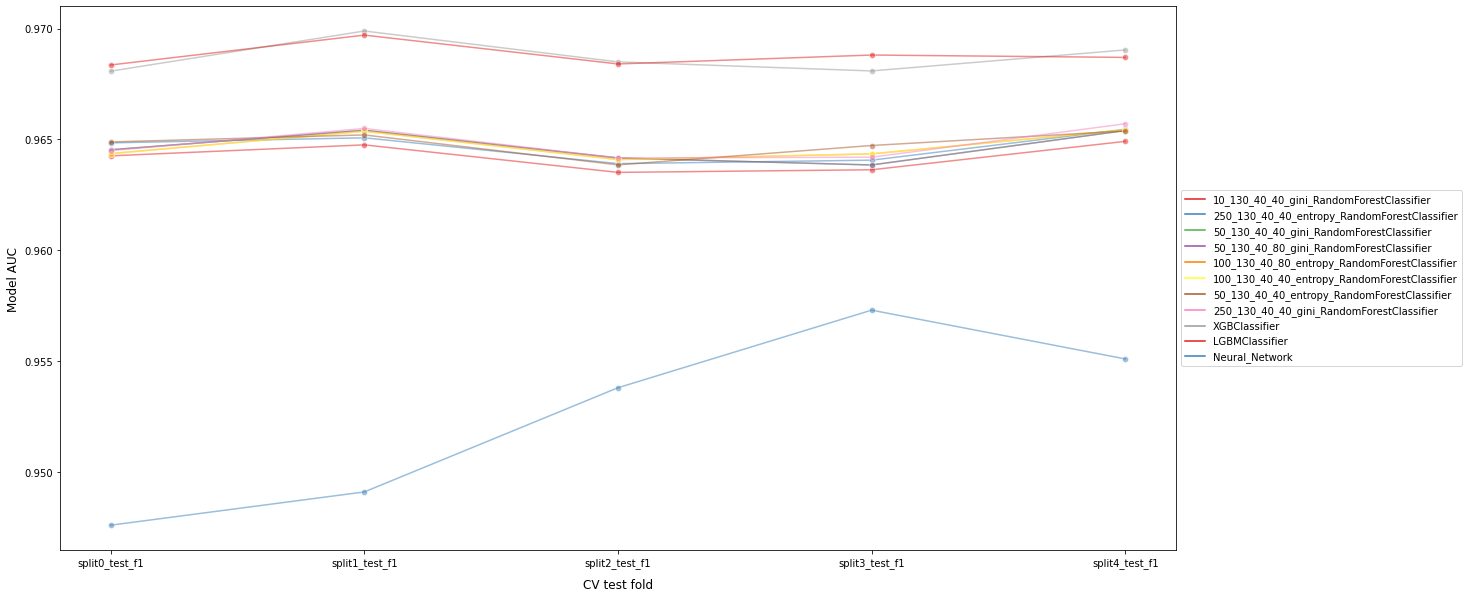

In [54]:
import seaborn as sns
model_scores = results_df_new.filter(regex=r"split\d*_test_f1")
print(model_scores)

fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(
    data=model_scores.transpose().iloc[:5],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## All testing with all samples

In [55]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(3,130),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

learning_rate=0.01
hidden_layer_act='relu'
output_layer_act='sigmoid'

clf1 = RandomForestClassifier(random_state=25,n_jobs=-1)

clf2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

clf3= lgb.LGBMClassifier()

def buildModel():

    model = Sequential()

    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(50, activation=hidden_layer_act))
    model.add(Dense(1, activation=output_layer_act))

    sgd=optimizers.SGD(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[f1_m,recall_m])
    return model


clf4 = KerasRegressor(build_fn = buildModel)



param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__criterion'] = ["gini", "entropy"]
param1['classifier__max_depth'] = [40,80]
param1['classifier__min_samples_split'] = [130]
param1['classifier__min_samples_leaf'] = [40]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier'] = [clf2]

param3 = {}
param3['classifier'] = [clf3]

param4={}
param4['classifier__batch_size']= [50]
param4['classifier__epochs']= [25]
param4['classifier']=[clf4]

pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2,param3]




print(params)
rf_random = RandomizedSearchCV(pipeline, param_distributions=params,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')
                                   #n_iter=5,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')

pipeline_nn = Pipeline([('classifier', clf4)])
params_nn = [param4]    
rf_random_nn = RandomizedSearchCV(pipeline_nn, param_distributions=params_nn,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')

rf_random.fit(df_final_train,y_train)
print('mean test f1',rf_random.cv_results_['mean_test_f1'])
print('mean train f1',rf_random.cv_results_['mean_train_f1'])

rf_random_nn.fit(df_final_train,y_train)
print('mean test f1',rf_random_nn.cv_results_['mean_test_f1'])
print('mean train f1',rf_random_nn.cv_results_['mean_train_f1'])

[{'classifier__n_estimators': [10, 50, 100, 250], 'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [40, 80], 'classifier__min_samples_split': [130], 'classifier__min_samples_leaf': [40], 'classifier': [RandomForestClassifier(n_jobs=-1, random_state=25)]}, {'classifier': [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)]}, {'classifier': [LGBMClassifier()]}]
[23:43:42] WARNING: C:/Users

1601/1601 [==============================] - 2s 1ms/step - loss: 0.0654 - f1_m: 0.9795 - recall_m: 0.9760
Epoch 10/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.0637 - f1_m: 0.9799 - recall_m: 0.9752
Epoch 11/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.0628 - f1_m: 0.9803 - recall_m: 0.9759
Epoch 12/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.0785 - f1_m: 0.9775 - recall_m: 0.9742
Epoch 13/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.0611 - f1_m: 0.9798 - recall_m: 0.9754
Epoch 14/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.0596 - f1_m: 0.9806 - recall_m: 0.9760
Epoch 15/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.0606 - f1_m: 0.9809 - recall_m: 0.9766
Epoch 16/25
1601/1601 [==============================] - 2s 1ms/step - loss: 0.0596 - f1_m: 0.9812 - recall_m: 0.9769
Epoch 17/25
1601/1601 [==============================] - 2s 1ms/step

In [59]:
results_df = pd.DataFrame(rf_random.cv_results_)
results_df = results_df.sort_values(by=["mean_test_f1"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
results_df[["params", "mean_test_f1", "mean_test_roc_auc", "mean_test_recall","mean_test_precision","mean_test_balanced_accuracy"]].head(50)

params  \
params                                                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 10, 'classifier__...   
50_130_40_40_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
50_130_40_80_gini_RandomForestClassifier(n_jobs...  {'classifier__n_estimators': 50, 'classifier__...   
250_130_40_40_gini_RandomForestClassifier(n_job...  {'classifier__n_estimators': 250, 'classifier_...   
50_130_40_40_entropy_RandomForestClassifier(n_j...  {'classifier__n_estimators': 50, 'classifier__...   
100_130_40_80_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
100_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 100, 'classifier_...   
250_130_40_40_entropy_RandomForestClassifier(n_...  {'classifier__n_estimators': 250, 'classifier_...   
LGBMClassifier()                                                     {'classifier': LGBMClassifier()}   
XGBClassifier(base_score=0.5, booster='gbtree',...  {'classifier': XGBClassifier(base_score=0.5, b...   

                                                    mean_test_f1  \
params                                                             
10_130_40_40_gini_RandomForestClassifier(n_jobs...      0.973309   
50_130_40_40_gini_RandomForestClassifier(n_jobs...      0.974406   
50_130_40_80_gini_RandomForestClassifier(n_jobs...      0.974406   
250_130_40_40_gini_RandomForestClassifier(n_job...      0.974989   
50_130_40_40_entropy_RandomForestClassifier(n_j...      0.975699   
100_130_40_80_entropy_RandomForestClassifier(n_...      0.975790   
100_130_40_40_entropy_RandomForestClassifier(n_...      0.975790   
250_130_40_40_entropy_RandomForestClassifier(n_...      0.975811   
LGBMClassifier()                                        0.983391   
XGBClassifier(base_score=0.5, booster='gbtree',...      0.983802   

                                                    mean_test_roc_auc  \
params                                                                  
10_130_40_40_gini_RandomForestClassifier(n_jobs...           0.996426   
50_130_40_40_gini_RandomForestClassifier(n_jobs...           0.996910   
50_130_40_80_gini_RandomForestClassifier(n_jobs...           0.996910   
250_130_40_40_gini_RandomForestClassifier(n_job...           0.996979   
50_130_40_40_entropy_RandomForestClassifier(n_j...           0.997001   
100_130_40_80_entropy_RandomForestClassifier(n_...           0.997037   
100_130_40_40_entropy_RandomForestClassifier(n_...           0.997037   
250_130_40_40_entropy_RandomForestClassifier(n_...           0.997081   
LGBMClassifier()                                             0.998776   
XGBClassifier(base_score=0.5, booster='gbtree',...           0.998815   

                                                    mean_test_recall  \
params                                                                 
10_130_40_40_gini_RandomForestClassifier(n_jobs...          0.958714   
50_130_40_40_gini_RandomForestClassifier(n_jobs...          0.960059   
50_130_40_80_gini_RandomForestClassifier(n_jobs...          0.960059   
250_130_40_40_gini_RandomForestClassifier(n_job...          0.961142   
50_130_40_40_entropy_RandomForestClassifier(n_j...          0.962566   
100_130_40_80_entropy_RandomForestClassifier(n_...          0.962626   
100_130_40_40_entropy_RandomForestClassifier(n_...          0.962626   
250_130_40_40_entropy_RandomForestClassifier(n_...          0.962687   
LGBMClassifier()                                            0.976348   
XGBClassifier(base_score=0.5, booster='gbtree',...          0.977813   

                                                    mean_test_precision  \
params                                                                    
10_130_40_40_gini_RandomForestClassifier(n_jobs...             0.988360   
50_130_40_40_gini_RandomForestClassifier(n_jobs...

In [60]:
results_df_dict=results_df[['params','split0_test_f1','split1_test_f1','split2_test_f1','split3_test_f1','split4_test_f1']].to_dict()
results_df_dict

{'params': {'10_130_40_40_gini_RandomForestClassifier(n_jobs=-1, random_state=25)': {'classifier__n_estimators': 10,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
  '50_130_40_40_gini_RandomForestClassifier(n_jobs=-1, random_state=25)': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
  '50_130_40_80_gini_RandomForestClassifier(n_jobs=-1, random_state=25)': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 80,
   'classifier__criterion': 'gini',
   'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
  '250_130_40_4

In [62]:
results_df_dict={'params': {'10_130_40_40_gini_RandomForestClassifier': {'classifier__n_estimators': 10,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': 'RandomForestClassifier'},
  '50_130_40_40_gini_RandomForestClassifier': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': 'RandomForestClassifier'},
  '50_130_40_80_gini_RandomForestClassifier': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 80,
   'classifier__criterion': 'gini',
   'classifier': 'RandomForestClassifier'},
  '250_130_40_40_gini_RandomForestClassifier': {'classifier__n_estimators': 250,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'gini',
   'classifier': 'RandomForestClassifier'},
  '50_130_40_40_entropy_RandomForestClassifier': {'classifier__n_estimators': 50,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'entropy',
   'classifier': 'RandomForestClassifier'},
  '100_130_40_80_entropy_RandomForestClassifier': {'classifier__n_estimators': 100,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 80,
   'classifier__criterion': 'entropy',
   'classifier': 'RandomForestClassifier'},
  '100_130_40_40_entropy_RandomForestClassifier': {'classifier__n_estimators': 100,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'entropy',
   'classifier': 'RandomForestClassifier'},
  '250_130_40_40_entropy_RandomForestClassifier': {'classifier__n_estimators': 250,
   'classifier__min_samples_split': 130,
   'classifier__min_samples_leaf': 40,
   'classifier__max_depth': 40,
   'classifier__criterion': 'entropy',
   'classifier': 'RandomForestClassifier'},
  'LGBMClassifier': {'classifier': 'LGBMClassifier'},
  "XGBClassifier": {'classifier': 'XGBClassifier'},
    "Neural_Network":{'classifier': 'Neural_Network'}},
 'split0_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9733917830563767,
  '50_130_40_40_gini_RandomForestClassifier': 0.9729674589411405,
  '50_130_40_80_gini_RandomForestClassifier': 0.9729674589411405,
  '250_130_40_40_gini_RandomForestClassifier': 0.9737056665307787,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9739935874599216,
  '100_130_40_80_entropy_RandomForestClassifier': 0.974745417515275,
  '100_130_40_40_entropy_RandomForestClassifier': 0.974745417515275,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9744895361270941,
  'LGBMClassifier': 0.9833097309326321,
  "XGBClassifier": 0.9835353535353535,
                 'Neural_Network':0.9751},
 'split1_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9739448422977297,
  '50_130_40_40_gini_RandomForestClassifier': 0.9747054043071921,
  '50_130_40_80_gini_RandomForestClassifier': 0.9747054043071921,
  '250_130_40_40_gini_RandomForestClassifier': 0.9751663196384135,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9769963518443453,
  '100_130_40_80_entropy_RandomForestClassifier': 0.9767819121971003,
  '100_130_40_40_entropy_RandomForestClassifier': 0.9767819121971003,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9765720081135904,
  'LGBMClassifier': 0.9845594913714805,
  "XGBClassifier": 0.9858828274679843,
                 'Neural_Network':0.9793},
 'split2_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9740458015267176,
  '50_130_40_40_gini_RandomForestClassifier': 0.9747557003257329,
  '50_130_40_80_gini_RandomForestClassifier': 0.9747557003257329,
  '250_130_40_40_gini_RandomForestClassifier': 0.9749363219561894,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9762280478493256,
  '100_130_40_80_entropy_RandomForestClassifier': 0.976235306091293,
  '100_130_40_40_entropy_RandomForestClassifier': 0.976235306091293,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9757637474541752,
  'LGBMClassifier': 0.9831193773375114,
  "XGBClassifier": 0.983336699656635,
                 'Neural_Network':0.9817},
 'split3_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9729234527687296,
  '50_130_40_40_gini_RandomForestClassifier': 0.9748600508905851,
  '50_130_40_80_gini_RandomForestClassifier': 0.9748600508905851,
  '250_130_40_40_gini_RandomForestClassifier': 0.9757584997713067,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9761602195903013,
  '100_130_40_80_entropy_RandomForestClassifier': 0.9757535708839525,
  '100_130_40_40_entropy_RandomForestClassifier': 0.9757535708839525,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9762195121951219,
  'LGBMClassifier': 0.9836446239273096,
  "XGBClassifier": 0.9840741860699526,
                 'Neural_Network':0.9826},
 'split4_test_f1': {'10_130_40_40_gini_RandomForestClassifier': 0.9722392324964277,
  '50_130_40_40_gini_RandomForestClassifier': 0.9747402729680178,
  '50_130_40_80_gini_RandomForestClassifier': 0.9747402729680178,
  '250_130_40_40_gini_RandomForestClassifier': 0.9753789805677077,
  '50_130_40_40_entropy_RandomForestClassifier': 0.9751157701898122,
  '100_130_40_80_entropy_RandomForestClassifier': 0.9754335995117237,
  '100_130_40_40_entropy_RandomForestClassifier': 0.9754335995117237,
  '250_130_40_40_entropy_RandomForestClassifier': 0.9760113844277292,
  'LGBMClassifier': 0.9823196605374824,
  "XGBClassifier": 0.9821798172547832,
                   'Neural_Network':0.9792}}

In [63]:
results_df_new=pd.DataFrame.from_dict(results_df_dict)

## Dependency between cv fold and AUC scores

                                              split0_test_f1  split1_test_f1  \
10_130_40_40_gini_RandomForestClassifier            0.973392        0.973945   
50_130_40_40_gini_RandomForestClassifier            0.972967        0.974705   
50_130_40_80_gini_RandomForestClassifier            0.972967        0.974705   
250_130_40_40_gini_RandomForestClassifier           0.973706        0.975166   
50_130_40_40_entropy_RandomForestClassifier         0.973994        0.976996   
100_130_40_80_entropy_RandomForestClassifier        0.974745        0.976782   
100_130_40_40_entropy_RandomForestClassifier        0.974745        0.976782   
250_130_40_40_entropy_RandomForestClassifier        0.974490        0.976572   
LGBMClassifier                                      0.983310        0.984559   
XGBClassifier                                       0.983535        0.985883   
Neural_Network                                      0.975100        0.979300   

                                       

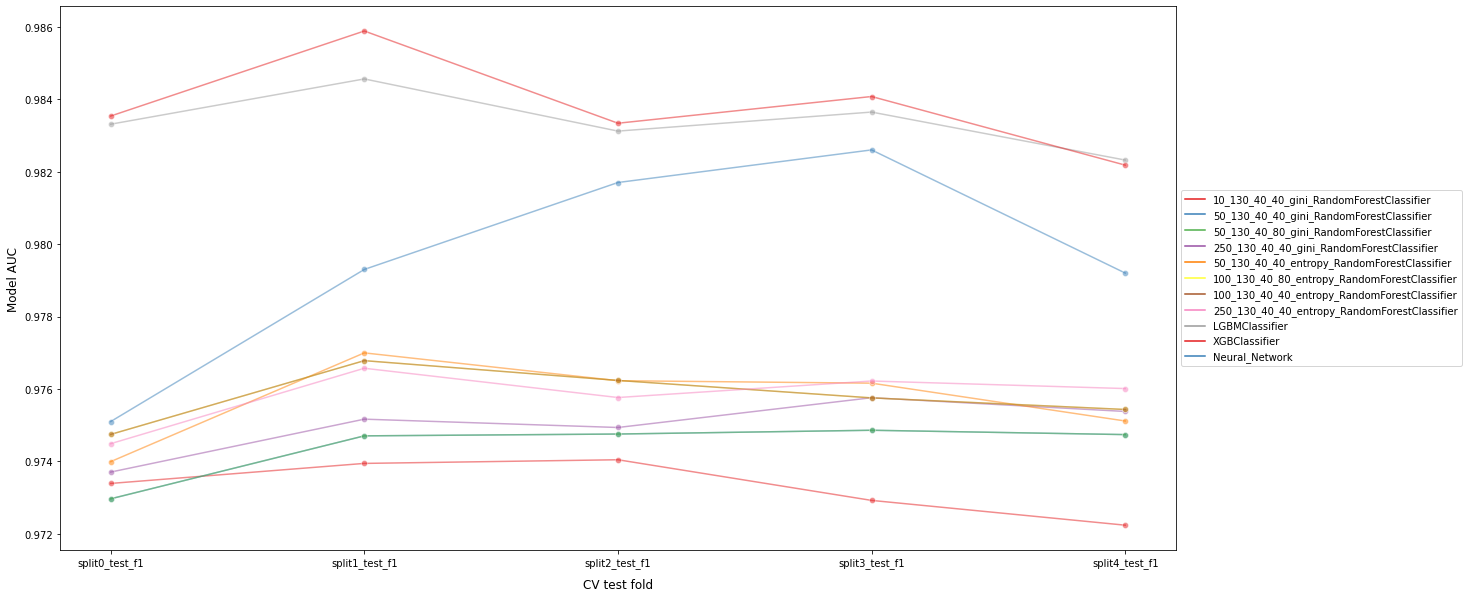

In [64]:
import seaborn as sns
model_scores = results_df_new.filter(regex=r"split\d*_test_f1")
print(model_scores)

fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(
    data=model_scores.transpose().iloc[:5],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()